In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime, date
import seaborn as sns

%matplotlib inline

## Part 1
### Raw CSV File

Part 1 is accompanied by a Data Quality Report, also included in this submission as a PDF.

In [2]:
# read the provided raw file
df = pd.read_csv('datasets/ppr-15323151.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [3]:
# number of rows
print("This dataset has", df.shape[0], "rows and", df.shape[1], "columns")

This dataset has 10000 rows and 9 columns


In [4]:
# print first 5 rows
print("First 5 rows")
df.head()

First 5 rows


,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/08/2017,"APARTMENT 27, GALWAY BAY SEA VIEW APTS, SALTHILL",NaN,Galway,"€90,575.00",No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
1,28/08/2017,"38A LR BEECHWOOD AVE, RANELAGH, DUBLIN 6",Dublin 6,Dublin,"€515,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
2,17/06/2010,"4 Ard na Greine, Lis na Dara, Dundalk",NaN,Louth,"€305,785.12",No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
3,18/12/2020,"1 CATHEDRAL VIEW COURT, OFF NEW ST, DUBLIN 8",Dublin 8,Dublin,"€345,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,08/02/2019,"190 ARDMORE DR, ARTANE, DUBLIN 5",Dublin 5,Dublin,"€390,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [5]:
print("Last 5 rows")
df.tail()

Last 5 rows


,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
9995,15/11/2019,"23 Oak Park Avenue, Oak Park, Craddockstown",NaN,Kildare,"€288,546.25",No,Yes,New Dwelling house /Apartment,NaN
9996,27/04/2017,"PORRIDGETOWN, ROSCAHILL, CO GALWAY",NaN,Galway,"€250,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9997,27/03/2018,"34 CORBAWN CLOSE, SHANKILL, DUBLIN",Dublin 18,Dublin,"€485,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9998,26/02/2019,"177 ROBERTSHILL, CIRCULAR RD, KILKENNY",NaN,Kilkenny,"€170,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9999,16/02/2021,"5 MAPLE SPRINGS APTS, KILCOHAN, WATERFORD",NaN,Waterford,"€105,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


Convert features to appropriate datatypes (continuous vs categorical). First step is to check the current pandas datatype that has been assigned by default. Can see that they are currently all set to objects, which is essentially plain text. Some cleaning is required before I convert them to appropriate data types as we can see in the segments of the dataframe above (e.g. date format, price).

In [6]:
# first show the datatypes in each column
df.dtypes

Date of Sale (dd/mm/yyyy)    object
Address                      object
Postal Code                  object
County                       object
Price (€)                    object
Not Full Market Price        object
VAT Exclusive                object
Description of Property      object
Property Size Description    object
dtype: object

<b>Initial Findings</b>

- We are dealing with quite a large dataset of 10,000 data points, each with 9 features, one of which being the target feature, Price.
- We only have one numerical column, with the remainder being either datetime or categorical. We could explore the possibility of converting those with Yes/No options to boolean, however it may be more straightforward to analyse as categorical.

Next I get a preliminary feel for the contents of the data. Can see that two columns have between 10%-20% of their values filled in. I will need to inspect these more closely to see if they have any value in staying in the dataframe. Additionally we can see that the 3 of the columns only have two different options used.

In [7]:
df.describe().T

,count,unique,top,freq
Date of Sale (dd/mm/yyyy),10000,2738,22/12/2014,25
Address,10000,9983,"42 DOWNSHIRE PLACE, EDENDERRY, OFFALY",2
Postal Code,1924,22,Dublin 15,239
County,10000,26,Dublin,3217
Price (€),10000,2313,"€150,000.00",129
Not Full Market Price,10000,2,No,9541
VAT Exclusive,10000,2,No,8367
Description of Property,10000,2,Second-Hand Dwelling house /Apartment,8334
Property Size Description,1054,4,greater than or equal to 38 sq metres and less...,789


Now checking what the Vat Exclusive and Not Full Market Price options consist of. They may warrant a conversion to a boolean datatype should they be a simple Yes/No....

In [8]:
# check that options are Yes/No
df['VAT Exclusive'].unique()

array(['No', 'Yes'], dtype=object)

In [9]:
# check that options are Yes/No
df['Not Full Market Price'].unique()

array(['No', 'Yes'], dtype=object)

Therefore we could appropriately convert the 2 above columns to boolean. However, I will keep these as categorical features for simplicity.

Price (€) column should be a float but needs to have the € symbols and commas removed beforehand

In [10]:
# remove € sign from price column entries
df['Price (€)'] = df['Price (€)'].str.lstrip('€')
# remove commas in price column
df['Price (€)'] = df['Price (€)'].str.replace(',', '').astype(float)

Date column can be converted to datetime datatype. Care must be taken to ensure that pandas knows the day comes first in our format, otherwise days less than 13 in the month will be reversed in the output. Changing the data also changes the format of the entries and so the column name must be updated accordingly

In [11]:
# can see in the below that the first entry has been converted incorrectly for example
df['Date of Sale (dd/mm/yyyy)'].astype('datetime64[ns]')

0      2017-01-08
1      2017-08-28
2      2010-06-17
3      2020-12-18
4      2019-08-02
          ...    
9995   2019-11-15
9996   2017-04-27
9997   2018-03-27
9998   2019-02-26
9999   2021-02-16
Name: Date of Sale (dd/mm/yyyy), Length: 10000, dtype: datetime64[ns]

In [12]:
# converting to datetime and specifying the day comes first in original data
df['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(df['Date of Sale (dd/mm/yyyy)'], dayfirst=True)
df.rename(columns={'Date of Sale (dd/mm/yyyy)':'Date of Sale (yyyy-mm-dd)'},inplace=True)
df['Date of Sale (yyyy-mm-dd)'] = df['Date of Sale (yyyy-mm-dd)'].astype('datetime64[ns]')

Check that the dataframe has been correctly updated. Date appropriately matches entries and Price (€) has been stripped of non-number symbols.

In [13]:
df.head()

,Date of Sale (yyyy-mm-dd),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,2017-08-01,"APARTMENT 27, GALWAY BAY SEA VIEW APTS, SALTHILL",NaN,Galway,90575.00,No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
1,2017-08-28,"38A LR BEECHWOOD AVE, RANELAGH, DUBLIN 6",Dublin 6,Dublin,515000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
2,2010-06-17,"4 Ard na Greine, Lis na Dara, Dundalk",NaN,Louth,305785.12,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
3,2020-12-18,"1 CATHEDRAL VIEW COURT, OFF NEW ST, DUBLIN 8",Dublin 8,Dublin,345000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
4,2019-02-08,"190 ARDMORE DR, ARTANE, DUBLIN 5",Dublin 5,Dublin,390000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


Need to decide how to treat the remaining columns. They should be changed to categories or remain as objects, depending on whether or not they are split into recurring buckets. Take a look at the description of the dataframe once more...

In [14]:
object_cols = df.select_dtypes(['object']).columns
df[object_cols].describe().T

,count,unique,top,freq
Address,10000,9983,"42 DOWNSHIRE PLACE, EDENDERRY, OFFALY",2
Postal Code,1924,22,Dublin 15,239
County,10000,26,Dublin,3217
Not Full Market Price,10000,2,No,9541
VAT Exclusive,10000,2,No,8367
Description of Property,10000,2,Second-Hand Dwelling house /Apartment,8334
Property Size Description,1054,4,greater than or equal to 38 sq metres and less...,789


Clearly, Postal Code, County, Not Full Market Price, VAT Exclusive and Property Size Description are all bucketed into categories and can be converted. Address seems to more closely resemble a string category given that it does not conform to specific categories and thus I chose to keep this as an object.

Need to check that Description of Property is also categorised before converting it by creating a list of its options.

In [15]:
df['Description of Property'].unique().tolist()

['New Dwelling house /Apartment', 'Second-Hand Dwelling house /Apartment']

Appropriate to convert this (and other objects) to a category

In [16]:
categorical_cols = ["Postal Code", "County", "Not Full Market Price", "VAT Exclusive", 
                    "Description of Property", "Property Size Description"]
for feature in categorical_cols:
    df[feature] = df[feature].astype('category')

Confirm all columns have been converted as required

In [17]:
df.dtypes

Date of Sale (yyyy-mm-dd)    datetime64[ns]
Address                              object
Postal Code                        category
County                             category
Price (€)                           float64
Not Full Market Price              category
VAT Exclusive                      category
Description of Property            category
Property Size Description          category
dtype: object

In [18]:
# convert all of the addresses to lower case to ensure that duplicates are identified
df["Address"] = df["Address"].str.lower()

Next take a look at the duplicate rows and columns (if any)

In [19]:
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())
# transpose dataset to use same method to find duplicated columns (cleaner than df.columns.duplicated())
dfT = df.T
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())

Number of duplicate (excluding first) rows in the table is:  2
Number of duplicate (excluding first) columns in the table is:  0


In [20]:
duplicatedRows=df[df.duplicated(keep=False)]
duplicatedRows

,Date of Sale (yyyy-mm-dd),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
49,2010-10-08,"116 seabury lawns, mornington, duleek",NaN,Meath,189427.31,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
3036,2010-10-08,"116 seabury lawns, mornington, duleek",NaN,Meath,189427.31,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
5153,2011-01-31,"84 lower main street, letterkenny",NaN,Donegal,84375.00,Yes,No,Second-Hand Dwelling house /Apartment,NaN
8162,2011-01-31,"84 lower main street, letterkenny",NaN,Donegal,84375.00,Yes,No,Second-Hand Dwelling house /Apartment,NaN


We can clearly deduce that both of the duplicates above should not be there - the same property would not have been sold twice on the same day. Therefore we can go ahead and delete them, confirming that the number of rows in the dataframe has reduced by 2.

In [21]:
df.drop_duplicates(inplace=True)
df.shape

(9998, 9)

In [22]:
print('Number of duplicate (excluding first) rows in the table now is: ', df.duplicated().sum())

Number of duplicate (excluding first) rows in the table now is:  0


Given that all columns have more than 1 unique value we can say that there are no constant columns.

I will now take a look at the different categories used in each of the categorical columns to see that all of the options make sense. I already know the two categories I considered to be boolean have only 2 options.

In [23]:
# taking a look at those prices that are new and how VAT has been applied
newProperties = df[df["Description of Property"].str.match("New Dwelling house /Apartment")]
newProperties["VAT Exclusive"].describe()

count     1665
unique       2
top        Yes
freq      1632
Name: VAT Exclusive, dtype: object

In [24]:
# taking a look at breakdown of the VAT Exclusive column
vatExclusive = df[df["VAT Exclusive"].str.match("Yes")]
vatExclusive["Description of Property"].describe()

count                              1632
unique                                1
top       New Dwelling house /Apartment
freq                               1632
Name: Description of Property, dtype: object

Only new properties are marked as not inclusive of VAT, however, not all new properties are marked as exclusive. The sale prices for these will need to be updated to reflect this.

In [25]:
# looking at the categorites for Property Size Description
df["Property Size Description"].value_counts(dropna=False)

NaN                                                                  8945
greater than or equal to 38 sq metres and less than 125 sq metres     788
greater than 125 sq metres                                            131
greater than or equal to 125 sq metres                                 77
less than 38 sq metres                                                 57
Name: Property Size Description, dtype: int64

'greater than 125 sq metres' is essentially the same as 'greater than or equal to 125 sq metres'. These can be added together to remove one of the categories.

In [26]:
# postal codes are only for Dublin properties
# below is a full list of the postal codes in Dublin (verified)
df['Postal Code'].value_counts(dropna=False)

NaN          8074
Dublin 15     239
Dublin 24     162
Dublin 18     136
Dublin 13     119
Dublin 4      113
Dublin 11     109
Dublin 12     105
Dublin 8      104
Dublin 9       97
Dublin 16      96
Dublin 14      94
Dublin 7       92
Dublin 3       83
Dublin 6       82
Dublin 1       64
Dublin 22      64
Dublin 5       60
Dublin 2       34
Dublin 10      23
Dublin 20      22
Dublin 17      16
Dublin 6w      10
Name: Postal Code, dtype: int64

In [27]:
# 3 counties with postal codes
postalCounties = df[df["Postal Code"].notnull()]
postalCounties['County'].unique().tolist()


['Dublin', 'Kilkenny', 'Leitrim']

In [28]:
incorrectPostal = postalCounties[postalCounties["County"].isin(["Kilkenny", "Leitrim"])]
incorrectPostal

,Date of Sale (yyyy-mm-dd),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
2263,2016-04-29,"castletown, carrick on suir, killkenny",Dublin 5,Kilkenny,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
3164,2019-12-17,"ballycallen, fenagh, leitrim",Dublin 11,Leitrim,225000.0,No,No,Second-Hand Dwelling house /Apartment,NaN


The two above entries clearly are not in Dublin and so the Postal Code should not be there...

In [29]:
dublinCounties = df[df["County"].isin(["Dublin"])]
dublinCountiesNoPostalCode = dublinCounties[dublinCounties["Postal Code"].isnull()]
dublinCountiesNoPostalCode

,Date of Sale (yyyy-mm-dd),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
7,2012-05-02,"apartment 3, castlepark court, dalkey",NaN,Dublin,233481.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
32,2010-06-01,"apartment 44 waterside drive, wateside swords,...",NaN,Dublin,195555.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
39,2018-03-08,"2 ard na greine, tivoli rd, dun laoghaire",NaN,Dublin,861000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
42,2013-12-19,"dooyork, skerries, co dublin",NaN,Dublin,505000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
70,2021-08-06,"21 castleland court, balbriggan, dublin",NaN,Dublin,165000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
...,...,...,...,...,...,...,...,...,...
9945,2012-10-05,"57 griffith downs, drumcondra",NaN,Dublin,645000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
9948,2010-08-11,"apartment 1 the maples, monkstown valley, monk...",NaN,Dublin,300000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
9955,2020-02-25,"27 odonnell gardens, glasthule, dublin",NaN,Dublin,540000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
9957,2010-06-15,"10 blackberry rise, portmarnock",NaN,Dublin,422000.0,No,No,Second-Hand Dwelling house /Apartment,NaN


Can see that quite a few entries that are in Dublin city do not have Postal Codes. Would be nice to get Postal Code data for these for a more in depth analysis.

In [30]:
# all counties in the Republic are represented
df['County'].value_counts(dropna=False)

Dublin       3217
Cork         1090
Kildare       536
Galway        517
Meath         423
Wexford       351
Limerick      347
Wicklow       318
Donegal       292
Kerry         290
Louth         262
Tipperary     261
Waterford     259
Clare         237
Mayo          222
Westmeath     202
Kilkenny      165
Sligo         147
Laois         146
Cavan         137
Roscommon     121
Offaly        115
Carlow        107
Leitrim        88
Monaghan       76
Longford       72
Name: County, dtype: int64

In [31]:
df['Description of Property'].value_counts(dropna=False)

Second-Hand Dwelling house /Apartment    8333
New Dwelling house /Apartment            1665
Name: Description of Property, dtype: int64

All of the above make sense - there are no entries with spelling mistakes that would cause the same result to be duplicated.

Now searching through the address to see if any of them are block purchases, a common trait of data entries on the PPR website.

In [32]:
# defining a list of words that may indicate a property is part of a block purchase
propertyGroup = ['-', '&', 'inclusive', 'units', 'apartments']
# iterate through dataframe
for index, row in df.iterrows():
    for term in propertyGroup:
        if term in row['Address']:
            print(row['Address'], row['Price (€)'])
            break

5-7  9-13  15  17 & 19, somerton walk (incl.), newcastle road  lucan 2834266.16
rear of 4 & 6 thorncastle st, ringsend, dublin 4 420000.0
apartment 159 neptune block, honeypark, dun-laoghaire 396475.78
apartment 10  block f, mount argus apartments 468351.0
apartment 62 neptune block, honeypark, dun-laoghaire 484581.5
apartment 57 & car space 57, the forum, sandyford 259200.71
14 units at ardan na mara, youghal 1590062.85
apartment 28, arranmore, 13-17 pembroke road 233000.0
19 the orchard apartments, cloverhill road, clondalkin 60000.0
3 cnoc dubh close, 3 cnoc dubh lawn, 4  5 & 8 cnoc dubh green 1950000.0
property at castletown demesne, carrick-on-suir, kilkenny 12600000.0
apartment no 6, the malton, 31-33 merrion road 630000.0
9 riverside apartments, main street, arklow 80000.0
grogan & corroe, ballycumber, co offaly 250000.0
apartment 98 neptune block, honeypark, dun-laoghaire 308370.05
units 1-16 millteog, blackfriary, athboy road 4282378.85
apt.5 - the avon, the courtyard, newtown

We can see that many of the above properties contain clues that they pertain to the purchase of more than one property.

In [33]:
# conducting some logical integrity tests on the date column
print("Earliest date in dataframe is", df["Date of Sale (yyyy-mm-dd)"].min())
print("Latest date in dataframe is", df["Date of Sale (yyyy-mm-dd)"].max())

Earliest date in dataframe is 2010-01-05 00:00:00
Latest date in dataframe is 2022-01-10 00:00:00


<AxesSubplot:>

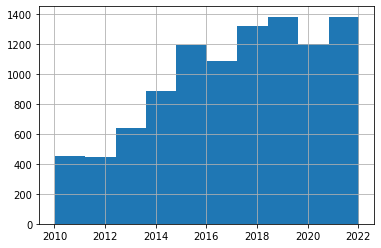

In [34]:
df["Date of Sale (yyyy-mm-dd)"].hist()

Interesting to note most of the observations come towards the second half of the period, but this is a subset of data and I have no knowledge of how the data was sampled to draw any conclusions from this.

In [35]:
# conducting some logical integrity tests on the price column
print("Minimum price in dataframe is", df["Price (€)"].min())
print("Maximum price in dataframe is", df["Price (€)"].max())

Minimum price in dataframe is 5500.0
Maximum price in dataframe is 26286500.0


In [36]:
# quite a few properties with low prices
smallPrices = df[df["Price (€)"]< 8000] 
smallPrices

,Date of Sale (yyyy-mm-dd),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
254,2016-01-11,"21 ship street, drogheda, county louth",NaN,Louth,7250.00,No,No,Second-Hand Dwelling house /Apartment,NaN
722,2010-12-03,"apartment 3, kilmainham square, kilmainham",Dublin 8,Dublin,6629.38,No,No,Second-Hand Dwelling house /Apartment,NaN
2946,2017-09-15,"flat 2, doochary village, county donegal",NaN,Donegal,7500.00,No,No,Second-Hand Dwelling house /Apartment,NaN
3103,2015-02-06,"233 cratloewood, old cratloe road",NaN,Limerick,7500.00,No,Yes,New Dwelling house /Apartment,less than 38 sq metres
4210,2015-02-06,"236 cratloewood, old cratloe road",NaN,Limerick,7500.00,No,Yes,New Dwelling house /Apartment,less than 38 sq metres
5695,2012-10-26,"lawcus, stoneyford",NaN,Kilkenny,6000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
7698,2015-01-20,"apartment 11, 63 great water street, co longford",NaN,Longford,6847.31,No,No,Second-Hand Dwelling house /Apartment,NaN
8239,2017-04-13,"pollagh, keel, achill",NaN,Mayo,6000.00,Yes,No,Second-Hand Dwelling house /Apartment,NaN
8242,2016-06-28,"apartment 36, broad leaf, broad street",NaN,Limerick,7222.00,No,Yes,New Dwelling house /Apartment,less than 38 sq metres
8483,2015-11-23,"ballyellis, buttevant",NaN,Cork,5500.00,No,No,Second-Hand Dwelling house /Apartment,NaN


All dates occur between 2010 and 2022, meaning there is likely no mistakes with this field (or at least none that would be possible to observe). Additionally, the minimum and maximum prices look to be reasonable (no negatives for example) although there are quite a few that are very small (although not outside the realm of expectations with a dataset this large). Also worth noting most of these small values are marked as Not Full Market Price.

Also necessary to check if the duplicate addresses are there more than once for a reason other than being sold more than once over the same time period. As per below we can see that none of entries with duplicate addresses were sold on the same day, meaning that they were just the same property sold more than once.

In [37]:
duplicatedAddresses = df[df["Address"].duplicated(keep=False)]
duplicatedAddresses
duplicateAddDate = duplicatedAddresses[duplicatedAddresses["Date of Sale (yyyy-mm-dd)"].duplicated(keep=False)]
duplicateAddDate

,Date of Sale (yyyy-mm-dd),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description


Lastly, clean the names of the columns to remove white spaces

In [38]:
# Clean the column names to remove white space after the name or in the name
df.columns = df.columns.str.replace(' ', '')

In [39]:
df.columns

Index(['DateofSale(yyyy-mm-dd)', 'Address', 'PostalCode', 'County', 'Price(€)',
       'NotFullMarketPrice', 'VATExclusive', 'DescriptionofProperty',
       'PropertySizeDescription'],
      dtype='object')

<b>Observations</b>

- We have 9 features in the dateset, all of which may offer some value in terms of analysing relationships.
- This is despite the high level of Null entries for Postal Codes and Property Size Description. Having looked at the set of Postal Codes it is clear that these are only the postal codes of Dublin City, and therefore it is likely the case that postal codes in Dublin County and beyond are not collected. Further Investigation will be required to deduce why Property Size Description is not fully populated.
- The counties used are the 26 in the Republic of Ireland.
- The data covers a period from 05/01/2010 to 10/01/2022, with the majority of the sales coming towards the second half of this period.

In [40]:
# export data frame to a csv
df.to_csv('datasets/PPRFileCleaned.csv', index=False)

### Cleaned CSV File

Now that the CSV file has been cleaned and the logical integrity checked we can begin to create the data quality report. First we need to open the newly created csv and reassign the chosen datatypes as per the above.

In [41]:
# use commas as separator
dfclean = pd.read_csv('datasets/PPRFileCleaned.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [42]:
# check datatypes again
dfclean.dtypes

DateofSale(yyyy-mm-dd)      object
Address                     object
PostalCode                  object
County                      object
Price(€)                   float64
NotFullMarketPrice          object
VATExclusive                object
DescriptionofProperty       object
PropertySizeDescription     object
dtype: object

In [43]:
# check data looks correct - it does
dfclean.head()

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
0,2017-08-01,"apartment 27, galway bay sea view apts, salthill",NaN,Galway,90575.00,No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
1,2017-08-28,"38a lr beechwood ave, ranelagh, dublin 6",Dublin 6,Dublin,515000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
2,2010-06-17,"4 ard na greine, lis na dara, dundalk",NaN,Louth,305785.12,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
3,2020-12-18,"1 cathedral view court, off new st, dublin 8",Dublin 8,Dublin,345000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
4,2019-02-08,"190 ardmore dr, artane, dublin 5",Dublin 5,Dublin,390000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


In [44]:
# converting once again
dfclean['DateofSale(yyyy-mm-dd)'] = dfclean['DateofSale(yyyy-mm-dd)'].astype('datetime64[ns]')
categorical_cols = ["PostalCode", "County", "NotFullMarketPrice", "VATExclusive", 
                    "DescriptionofProperty", "PropertySizeDescription"]

for feature in categorical_cols:
    dfclean[feature] = dfclean[feature].astype('category')

dfclean.dtypes

DateofSale(yyyy-mm-dd)     datetime64[ns]
Address                            object
PostalCode                       category
County                           category
Price(€)                          float64
NotFullMarketPrice               category
VATExclusive                     category
DescriptionofProperty            category
PropertySizeDescription          category
dtype: object

### Numerical and Datetime Data

A discussion of trends observed here is included in the Data Quality Report.

In order to ascertain whether or not there are any interesting trends with the datetime column I will use the datetime_is_numeric parameter to get some summary statistics.

In [45]:
numerical_columns = dfclean.select_dtypes(['int64', 'float64']).columns
# round datapoints to 2 decimal points
pricedescription = dfclean[numerical_columns].describe().T.round(2)
pricedescription

,count,mean,std,min,25%,50%,75%,max
Price(€),9998.0,265447.47,496033.78,5500.0,120000.0,200000.0,307500.0,26286500.0


Every entry has a price value populated and thus there is no need to prepare statistics relating to missing values for numerical data.

In [46]:
notmarketprice = dfclean[dfclean["NotFullMarketPrice"].isin(["Yes"])]
notmarketprice.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Price(€),458.0,149976.23,165345.86,6000.0,61800.89,120000.0,199559.47,1950000.0


Interesting to note that the mean price for those properties that were not sold for full price is considerably lower.

In [47]:
datetime = dfclean.select_dtypes(['datetime']).columns
timedescription = dfclean[datetime].describe(datetime_is_numeric=True).T
timedescription

,count,mean,min,25%,50%,75%,max
DateofSale(yyyy-mm-dd),9998,2017-02-16 01:13:44.564912896,2010-01-05,2014-11-18 06:00:00,2017-06-30,2019-09-06,2022-01-10


Remove times from output

In [48]:
timedescription['mean'] = pd.to_datetime(timedescription['mean']).dt.date
timedescription['min'] = pd.to_datetime(timedescription['min']).dt.date
timedescription['25%'] = pd.to_datetime(timedescription['25%']).dt.date
timedescription['50%'] = pd.to_datetime(timedescription['50%']).dt.date
timedescription['75%'] = pd.to_datetime(timedescription['75%']).dt.date
timedescription['max'] = pd.to_datetime(timedescription['max']).dt.date
timedescription

,count,mean,min,25%,50%,75%,max
DateofSale(yyyy-mm-dd),9998,2017-02-16,2010-01-05,2014-11-18,2017-06-30,2019-09-06,2022-01-10


In [49]:
# combine both for the PDF
numericaldateQualityReportTable = pd.concat([pricedescription, timedescription], axis=0)
numericaldateQualityReportTable

,count,mean,std,min,25%,50%,75%,max
Price(€),9998.0,265447.47,496033.78,5500.0,120000.0,200000.0,307500.0,26286500.0
DateofSale(yyyy-mm-dd),9998,2017-02-16,NaN,2010-01-05,2014-11-18,2017-06-30,2019-09-06,2022-01-10


We know that there are 9998 datapoints and from the above can see that everyone has a price and date associated, therefore there is no need to prepare a missing column. Additionally, as both are continuous numerical data, as opposed to discrete, preparing cardinality would be essentially meaningless.

### Continuous Plots

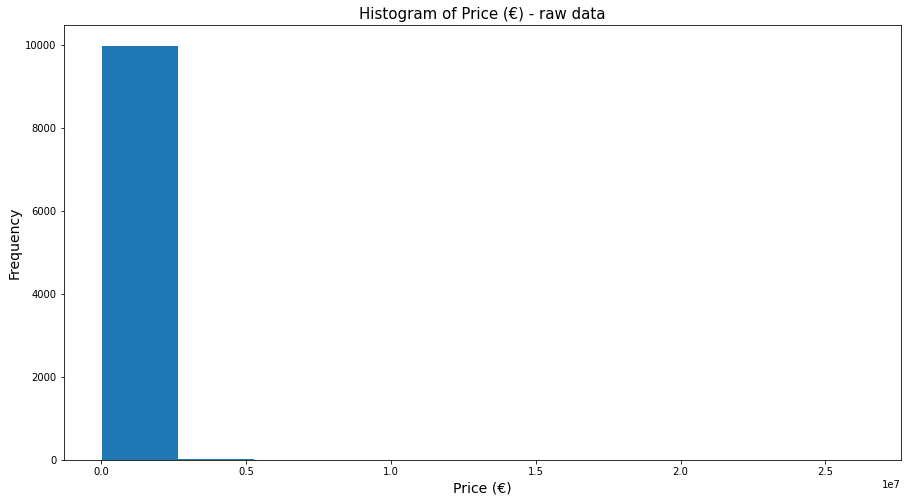

In [50]:
# plotting the price data
plt.figure(figsize=(15,8))
plt.title("Histogram of Price (€) - raw data", fontsize=15)
plt.xlabel("Price (€)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.hist(dfclean['Price(€)'])
plt.show()

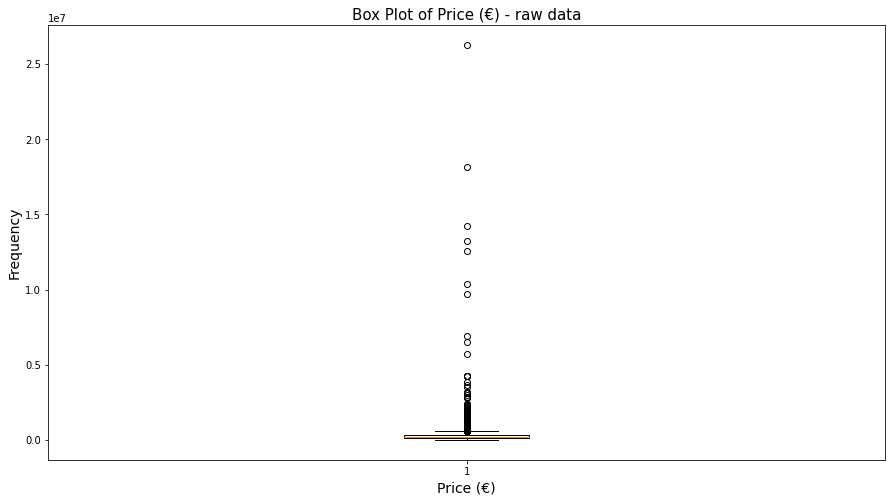

In [51]:
plt.figure(figsize=(15,8))
plt.title("Box Plot of Price (€) - raw data", fontsize=15)
plt.xlabel("Price (€)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.boxplot(dfclean['Price(€)'])
plt.show()

The results of the above are relatively meaningless due to the presence of outliers. I will now remove these from the plots to get a better view of how the data is distributed.

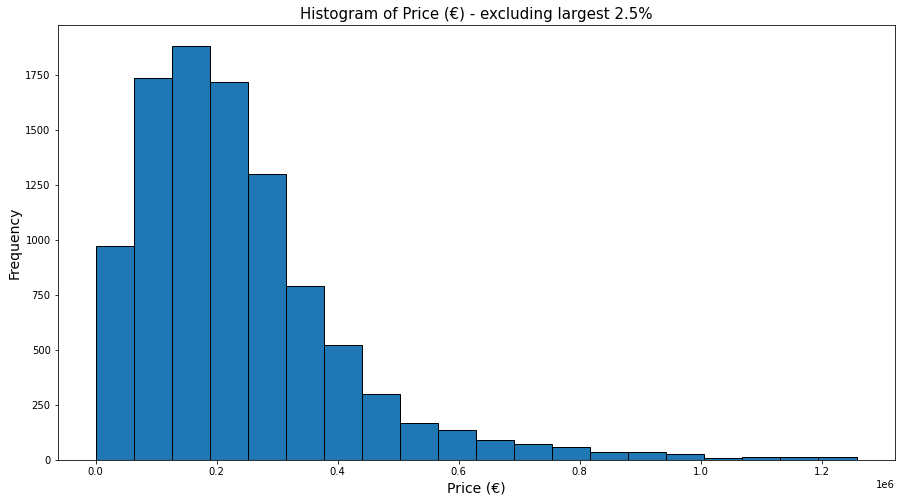

In [52]:
# calculate value 2 standard deviations above the mean
twoSDs = int(dfclean['Price(€)'].mean() + (2*dfclean['Price(€)'].std()))
prices = list(dfclean['Price(€)'])
bins = []

# set 20 bins up to 2 standard deviations above the mean
for price in range(0, twoSDs, twoSDs//20):
    bins.append(price)

plt.figure(figsize=(15,8))
plt.title("Histogram of Price (€) - excluding largest 2.5%", fontsize=15)
plt.xlabel("Price (€)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.hist(prices, bins, edgecolor="black")

plt.show()

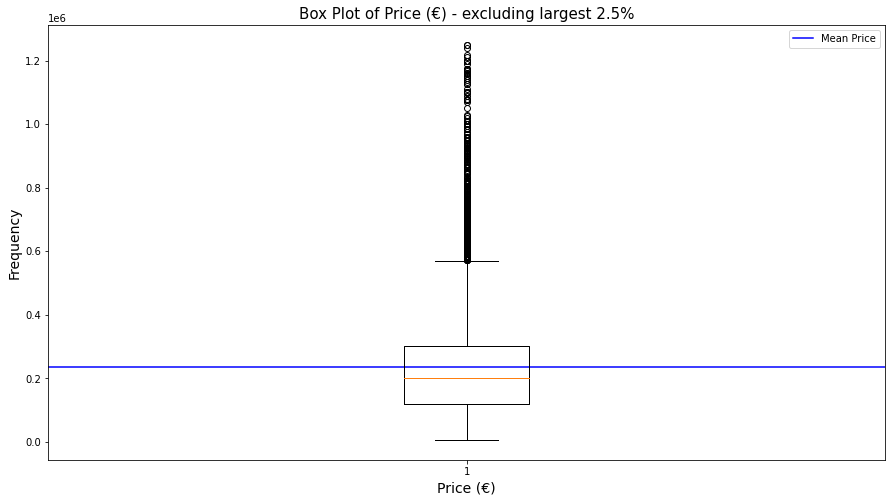

In [53]:
# box plot with prices up to 2 standard deviations above the mean
boxprices = [x for x in prices if x < twoSDs]
meanPrice = sum(boxprices)/len(boxprices)
plt.figure(figsize=(15,8))
plt.axhline(y=meanPrice, color="blue", label="Mean Price")
plt.title("Box Plot of Price (€) - excluding largest 2.5%", fontsize=15)
plt.xlabel("Price (€)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.boxplot(boxprices)

plt.show()

<Figure size 432x288 with 0 Axes>

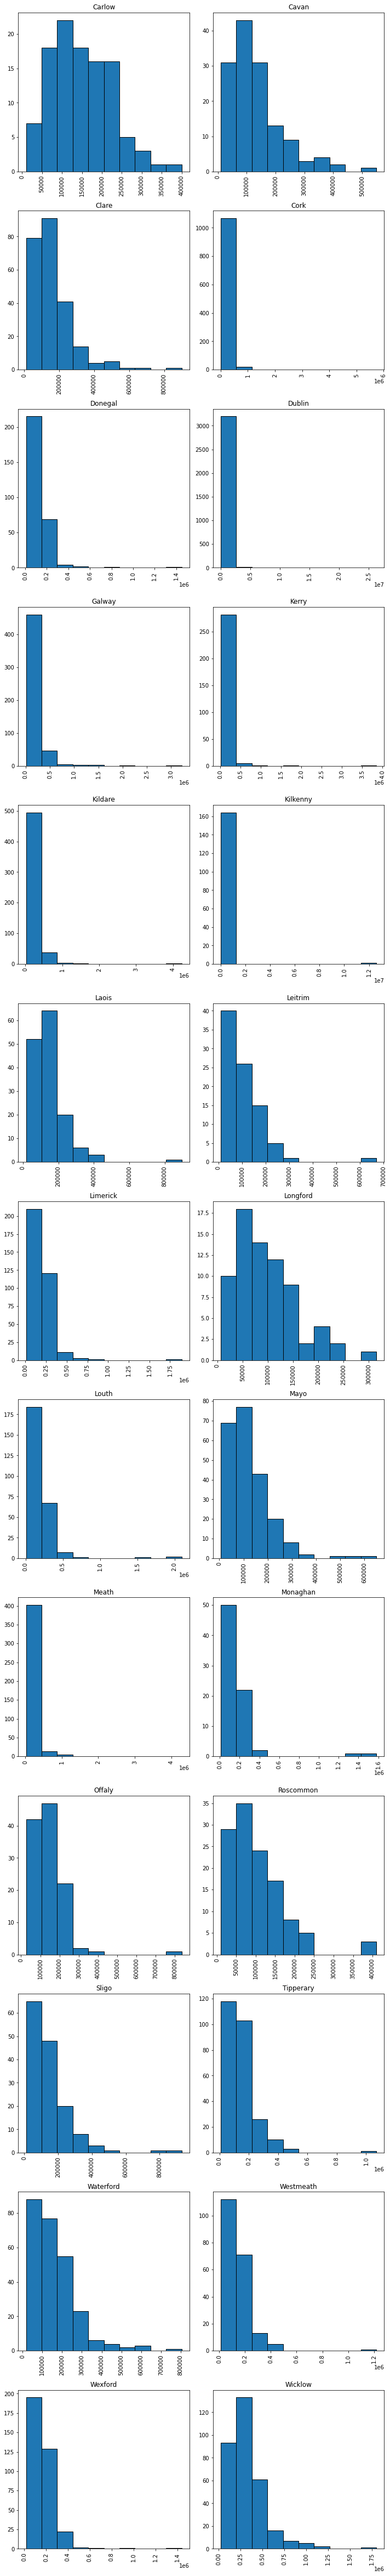

In [54]:
# price distribution for each county
plt.figure()
dfclean['Price(€)'].hist(by=dfclean['County'], figsize=(10,5*26), layout=(26,2), edgecolor="black")
plt.ylabel = ("Frequency")
plt.xlabel = ("Price (€)")
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

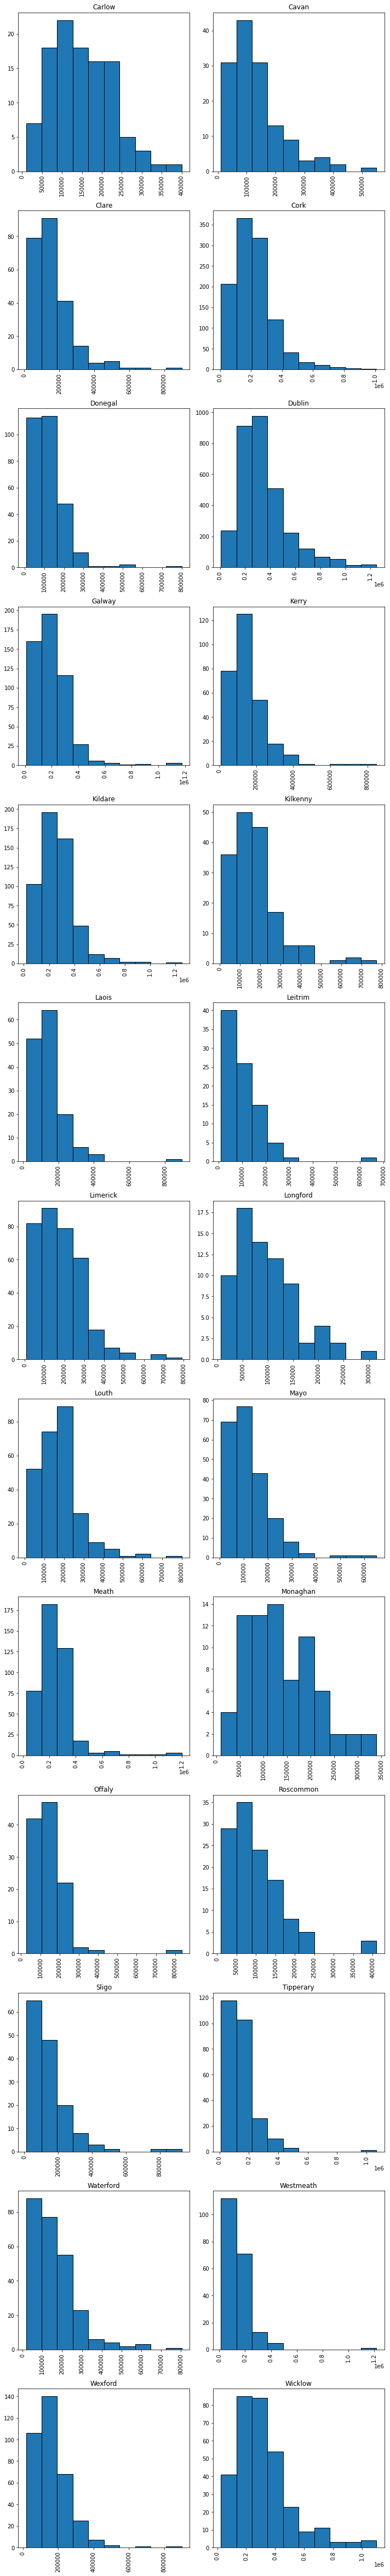

In [55]:
# get new plots using the max value
lowprices = dfclean[dfclean["Price(€)"]<twoSDs]
plt.figure()

lowprices['Price(€)'].hist(by=lowprices['County'], figsize=(10,5*26), layout=(26,2), edgecolor="black")
plt.ylabel = ("Frequency")
plt.xlabel = ("Price (€)")
plt.tight_layout()
plt.show()


<Figure size 432x288 with 0 Axes>

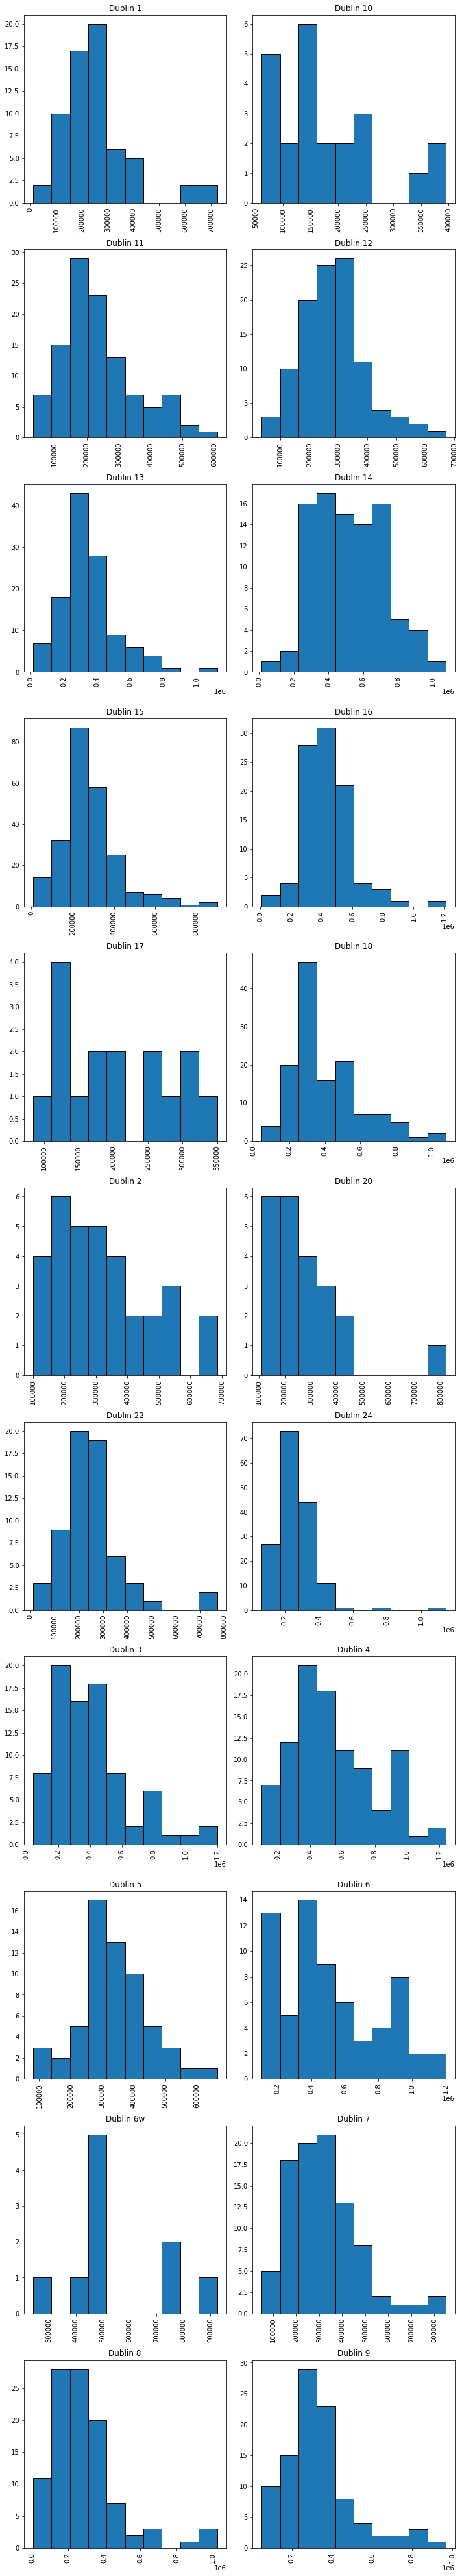

In [56]:
# similar plots for the Postal Codes
plt.figure()

lowprices['Price(€)'].hist(by=lowprices['PostalCode'], figsize=(10,5*26), layout=(26,2), edgecolor="black")
plt.ylabel = ("Frequency")
plt.xlabel = ("Price (€)")
plt.tight_layout()
plt.show()


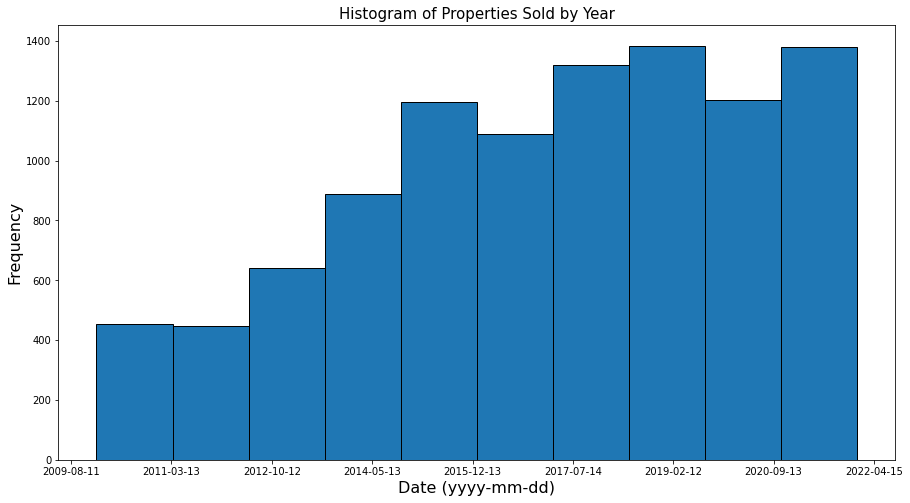

In [57]:
# had to reimport these...
from importlib import reload
reload(plt)
from datetime import datetime
# function to convert datetime to string
def datetimeString(x,pos):
    return datetime.strftime(datetime.fromtimestamp(x),"%Y-%m-%d")

# format for the x axis
dateformat = FuncFormatter(datetimeString)

dateConverted = list(map(lambda x: datetime.timestamp(x), list(dfclean['DateofSale(yyyy-mm-dd)'])))


plt.figure(figsize=(15,8))
plt.title("Histogram of Properties Sold by Year", fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Date (yyyy-mm-dd)', fontsize=16)
plt.hist(dateConverted, edgecolor="black")
plt.gca().xaxis.set_major_formatter(dateformat)
plt.show()

As the data begins in January of 2010, simply resizing the bins to 4 times the amount of years will give the breakdown of sales by quarter. There are 12 full years in our dataset, as well as a partial quarter in 2022. Therefore we need 12.25*4 = 49 bins.

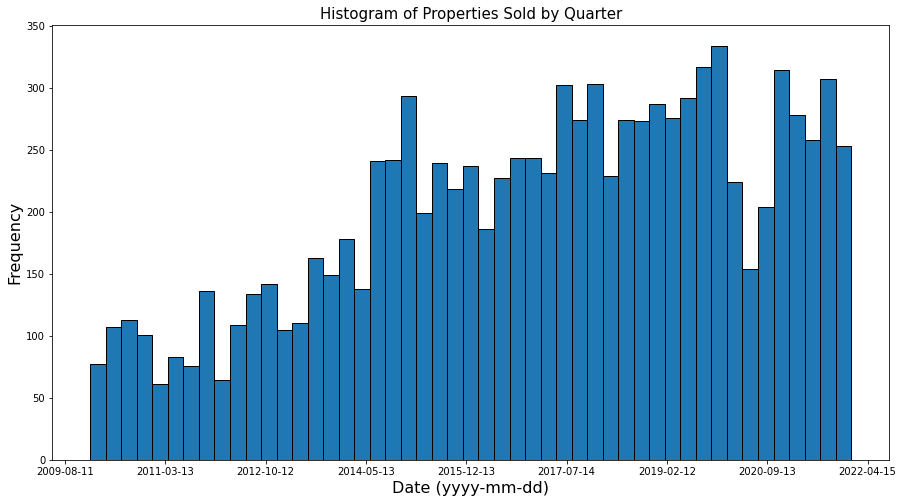

In [58]:
plt.figure(figsize=(15,8))
plt.title("Histogram of Properties Sold by Quarter", fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Date (yyyy-mm-dd)', fontsize=16)
plt.hist(dateConverted, edgecolor="black", bins=49)
plt.gca().xaxis.set_major_formatter(dateformat)

plt.show()

### Categorical Data

A discussion of trends observed here is included in the Data Quality Report.

In [59]:
# look at the categorical columns we have once more
categorical_columns = dfclean.select_dtypes(['category']).columns
dfclean[categorical_columns].head()

,PostalCode,County,NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
0,NaN,Galway,No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
1,Dublin 6,Dublin,No,No,Second-Hand Dwelling house /Apartment,NaN
2,NaN,Louth,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
3,Dublin 8,Dublin,No,No,Second-Hand Dwelling house /Apartment,NaN
4,Dublin 5,Dublin,No,No,Second-Hand Dwelling house /Apartment,NaN


In [60]:
# I have null values in some columns so need to prepare stats on these
dfclean[categorical_columns].isnull().sum()

PostalCode                 8074
County                        0
NotFullMarketPrice            0
VATExclusive                  0
DescriptionofProperty         0
PropertySizeDescription    8945
dtype: int64

In [61]:
# only include count and unique as modes calculated later
categorical_table = dfclean[categorical_columns].describe().loc[['count','unique']].T
categorical_table

,count,unique
PostalCode,1924,22
County,9998,26
NotFullMarketPrice,9998,2
VATExclusive,9998,2
DescriptionofProperty,9998,2
PropertySizeDescription,1053,4


There is a high level of Null entries for Postal Codes and Property Size Description. Having looked at the set of Postal Codes it is clear that these are only the postal codes of Dublin City, and therefore it is likely the case that postal codes in Dublin County and beyond are not collected. Further Investigation will be required to deduce why Property Size Description is not fully populated.

In [62]:
# value counts of each category
for column in categorical_columns:
    print("\u0332".join(column))
    print(dfclean[column].value_counts(dropna=False), "\n")

P̲o̲s̲t̲a̲l̲C̲o̲d̲e
NaN          8074
Dublin 15     239
Dublin 24     162
Dublin 18     136
Dublin 13     119
Dublin 4      113
Dublin 11     109
Dublin 12     105
Dublin 8      104
Dublin 9       97
Dublin 16      96
Dublin 14      94
Dublin 7       92
Dublin 3       83
Dublin 6       82
Dublin 1       64
Dublin 22      64
Dublin 5       60
Dublin 2       34
Dublin 10      23
Dublin 20      22
Dublin 17      16
Dublin 6w      10
Name: PostalCode, dtype: int64 

C̲o̲u̲n̲t̲y
Dublin       3217
Cork         1090
Kildare       536
Galway        517
Meath         423
Wexford       351
Limerick      347
Wicklow       318
Donegal       292
Kerry         290
Louth         262
Tipperary     261
Waterford     259
Clare         237
Mayo          222
Westmeath     202
Kilkenny      165
Sligo         147
Laois         146
Cavan         137
Roscommon     121
Offaly        115
Carlow        107
Leitrim        88
Monaghan       76
Longford       72
Name: County, dtype: int64 

N̲o̲t̲F̲u̲l̲l̲M̲a̲r̲k̲e̲

In [63]:
# value counts of each category, but now excluding null values
for column in categorical_columns:
    print("\u0332".join(column))
    print(dfclean[column].value_counts(normalize=True, dropna=True), "\n")

P̲o̲s̲t̲a̲l̲C̲o̲d̲e
Dublin 15    0.124220
Dublin 24    0.084200
Dublin 18    0.070686
Dublin 13    0.061850
Dublin 4     0.058732
Dublin 11    0.056653
Dublin 12    0.054574
Dublin 8     0.054054
Dublin 9     0.050416
Dublin 16    0.049896
Dublin 14    0.048857
Dublin 7     0.047817
Dublin 3     0.043139
Dublin 6     0.042620
Dublin 1     0.033264
Dublin 22    0.033264
Dublin 5     0.031185
Dublin 2     0.017672
Dublin 10    0.011954
Dublin 20    0.011435
Dublin 17    0.008316
Dublin 6w    0.005198
Name: PostalCode, dtype: float64 

C̲o̲u̲n̲t̲y
Dublin       0.321764
Cork         0.109022
Kildare      0.053611
Galway       0.051710
Meath        0.042308
Wexford      0.035107
Limerick     0.034707
Wicklow      0.031806
Donegal      0.029206
Kerry        0.029006
Louth        0.026205
Tipperary    0.026105
Waterford    0.025905
Clare        0.023705
Mayo         0.022204
Westmeath    0.020204
Kilkenny     0.016503
Sligo        0.014703
Laois        0.014603
Cavan        0.013703
Roscommon

In [64]:
# calculated mode and second mode for each category
categorical_modes = pd.DataFrame(index = categorical_table.index, columns=
                                 ['Mode', 'ModeFreq','Mode%', 'Mode2', 'Mode2Freq','Mode2%'])
for column in categorical_columns:
    categorical_modes.loc[column]['Mode'] = dfclean[column].value_counts().keys()[0]
    categorical_modes.loc[column]['ModeFreq'] = dfclean[column].value_counts()[categorical_modes.loc[column]['Mode']]
    categorical_modes.loc[column]['Mode%'] = (dfclean[column].value_counts(normalize=True)*100).round(2)[categorical_modes.loc[column]['Mode']]
 
    if df[column].value_counts().size > 1:
        categorical_modes.loc[column]['Mode2'] = df[column].value_counts().keys()[1]
        categorical_modes.loc[column]['Mode2Freq'] = df[column].value_counts()[categorical_modes.loc[column]['Mode2']]
        categorical_modes.loc[column]['Mode2%'] = (df[column].value_counts(normalize=True)*100).round(2)[categorical_modes.loc[column]['Mode2']]
    else:
        categorical_modes.loc[column] = '-'
categorical_modes

,Mode,ModeFreq,Mode%,Mode2,Mode2Freq,Mode2%
PostalCode,Dublin 15,239,12.42,Dublin 24,162,8.42
County,Dublin,3217,32.18,Cork,1090,10.9
NotFullMarketPrice,No,9540,95.42,Yes,458,4.58
VATExclusive,No,8366,83.68,Yes,1632,16.32
DescriptionofProperty,Second-Hand Dwelling house /Apartment,8333,83.35,New Dwelling house /Apartment,1665,16.65
PropertySizeDescription,greater than or equal to 38 sq metres and less...,788,74.83,greater than 125 sq metres,131,12.44


In [65]:
# caculate the amount missing for categories
categorical_missing = pd.DataFrame(round((dfclean[categorical_columns].isnull().sum()/dfclean.shape[0]) * 100, 2), columns=['Missing%'])
categorical_missing

,Missing%
PostalCode,80.76
County,0.00
NotFullMarketPrice,0.00
VATExclusive,0.00
DescriptionofProperty,0.00
PropertySizeDescription,89.47


In [66]:
# data quality report table for categories
categoricalQualityReportTable = pd.concat([categorical_table, categorical_modes, categorical_missing], axis=1)
categoricalQualityReportTable

,count,unique,Mode,ModeFreq,Mode%,Mode2,Mode2Freq,Mode2%,Missing%
PostalCode,1924,22,Dublin 15,239,12.42,Dublin 24,162,8.42,80.76
County,9998,26,Dublin,3217,32.18,Cork,1090,10.9,0.00
NotFullMarketPrice,9998,2,No,9540,95.42,Yes,458,4.58,0.00
VATExclusive,9998,2,No,8366,83.68,Yes,1632,16.32,0.00
DescriptionofProperty,9998,2,Second-Hand Dwelling house /Apartment,8333,83.35,New Dwelling house /Apartment,1665,16.65,0.00
PropertySizeDescription,1053,4,greater than or equal to 38 sq metres and less...,788,74.83,greater than 125 sq metres,131,12.44,89.47


### Categorical Plots

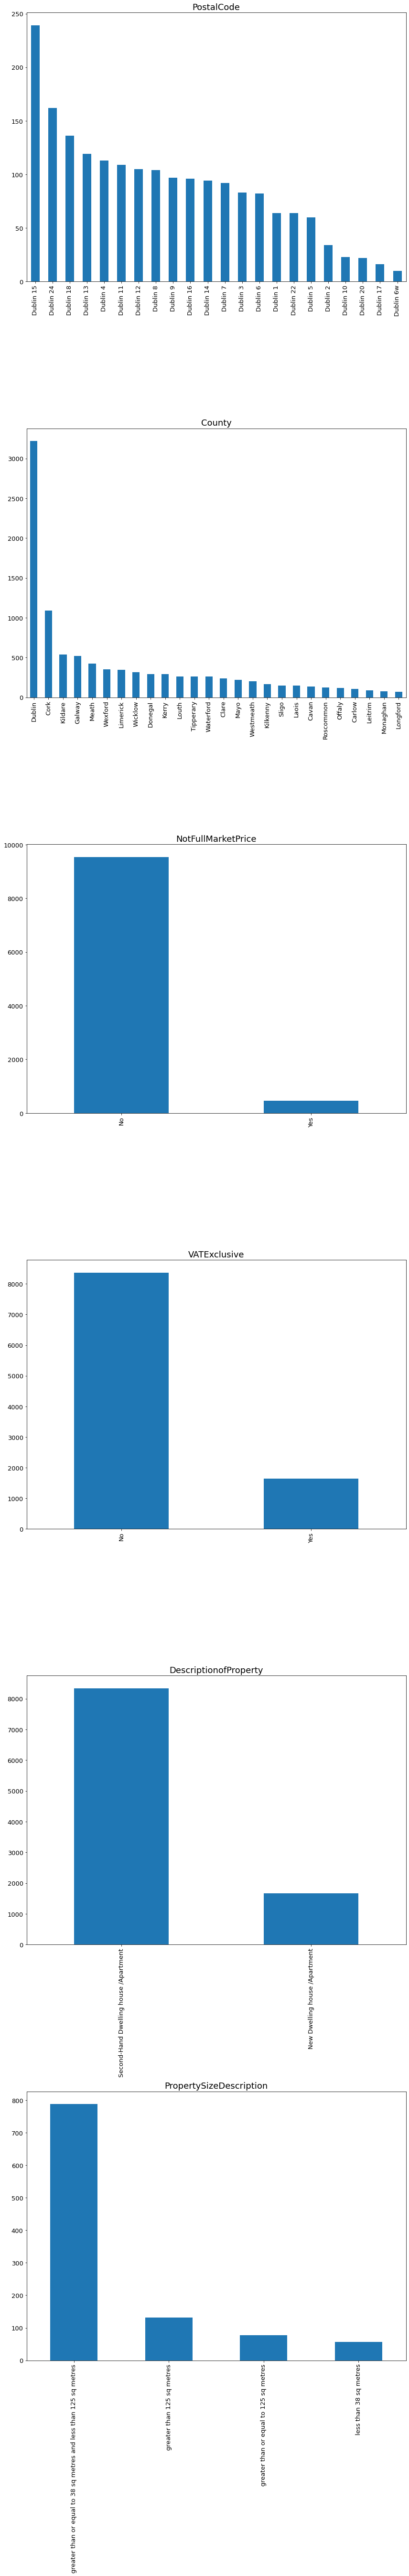

In [67]:
fig, axes = plt.subplots(len(categorical_columns))
fig.set_figheight(75)
fig.set_figwidth(12)
# loop through each category and plot the distribution
for category, i in enumerate(categorical_columns):
    dfclean[categorical_columns[category]].value_counts().plot(ax=axes[category],kind='bar')
    axes[category].set_title(categorical_columns[category], fontsize = 18) 
    axes[category].tick_params(axis='both', which='major', labelsize = 13)
    plt.tight_layout()
   

## Part 2 - Prepare a data quality plan for the cleaned CSV file.

In this section I implemented solutions to some of the problems found in Part 1, the Data Quality Report. A Data Quality Plan accompanies this part which explains the range of the potential solutions for each problem, and the reason I chose the solution for each.

Below is a summary of the problems I identified in the dataset.

- Addresses in current format have little value
- Missing Postal Codes
- Some Dublin Postal Codes are not in Dublin
- Missing Property Size Descriptions
- Duplicated Property Size Description Category
- Not all new build properties are inclusive of VAT
- Some prices not at market value
- Dataset contains block purchases
- Prices are not normalised - significant outliers



- Cardinality of Counties is quite high

<b>Issue 1: Addresses in current format have little value</b><br>

In their current format, the addresses pose little value. We can clearly see that the format applied is inconsistent. For example, some end with the county, some with the postal code. In addition, I note that some addresses contain the postal code when it is not contained in the postal code field. Therefore, it should be possible to extract useful information from this field to be additive to Postal Code. A difficulty with this is that the location of the Postal Code is not the same for each address.

In [68]:
# convert address field to list split by commas
dfclean['Address'] = dfclean['Address'].apply(lambda x: x.split(","))

# check this was correctly applied
dfclean.head()

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
0,2017-08-01,"[apartment 27, galway bay sea view apts, sal...",NaN,Galway,90575.00,No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
1,2017-08-28,"[38a lr beechwood ave, ranelagh, dublin 6]",Dublin 6,Dublin,515000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
2,2010-06-17,"[4 ard na greine, lis na dara, dundalk]",NaN,Louth,305785.12,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
3,2020-12-18,"[1 cathedral view court, off new st, dublin 8]",Dublin 8,Dublin,345000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
4,2019-02-08,"[190 ardmore dr, artane, dublin 5]",Dublin 5,Dublin,390000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


<b>Issue 2: Missing Postal Codes</b><br>
80.76% of the data points do not have associated postal codes. I discovered in Part 1 that the Postal Code fields were only used for addresses in Dublin City, however, not all addresses in Dublin City have postal codes.

In [69]:
# create a dataframe of rows with postal codes
postalCounties = df[df["PostalCode"].notnull()]
# create a list of post codes
postCodes = postalCounties['PostalCode'].unique().tolist()

In [70]:
# create list of postcodes with no spaces and in lower case
# creating copied list to check against those in the address
# will need the original to slot the post code into the dataframe
postcodesChanged = [x for x in postCodes]
# strip whitespace in case any stray spaces in the address field
for i in range(len(postCodes)):
    postcodesChanged[i] = postcodesChanged[i].lower()
    postcodesChanged[i] = postcodesChanged[i].replace(" ", "")

# slice of all entries with county equalling Dublin
dublinCounties = dfclean[dfclean["County"].isin(["Dublin"])]
dublinCountiesNoPostalCode = dublinCounties[dublinCounties["PostalCode"].isnull()]
initialMissing = dublinCountiesNoPostalCode.shape[0]

# search through all counties in Dublin without a postal code to see if they give the postal code in the address field
for index, row in dublinCountiesNoPostalCode.iterrows():
    # loop through contents of address field
    for i in row['Address']:
        # loop through contents of postalcodes list
        for j in range(len(postcodesChanged)):
            
            if i.lower().replace(" ", "") == postcodesChanged[j]:
                # update the value in the main dataframe
                dfclean.loc[index,'PostalCode'] = postCodes[j]

In [71]:
dublinCounties = dfclean[dfclean["County"].isin(["Dublin"])]
dublinCountiesNoPostalCode = dublinCounties[dublinCounties["PostalCode"].isnull()]
newMissing = dublinCountiesNoPostalCode.shape[0]
print("Initially,", initialMissing, "datapoints in Dublin had no postal Codes. After Cleaning", newMissing, 
      "are without postalCodes (" + str(initialMissing-newMissing) + " increase).")

Initially, 1295 datapoints in Dublin had no postal Codes. After Cleaning 1105 are without postalCodes (190 increase).


<b>Issue 3: Some Dublin Postal Codes are not in Dublin</b><br>

It was discovered in part 1 that some addresses outside of Dublin were assigned Dublin Postal Codes. Clearly this is an error.

It seems reasonable to assume that the postal codes here were entered mistakenly. Therefore I will remove the post code.

In [72]:
# I know from part 1 that rows 2263 and 3163 have incorrect postal codes
dfclean.loc[2263,'PostalCode'] = np.nan
dfclean.loc[3163,'PostalCode'] = np.nan
# check one is appropriately updated
dfclean.loc[[2263]]

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
2263,2016-04-29,"[castletown, carrick on suir, killkenny]",NaN,Kilkenny,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN


<b>Issue 4: Missing Property Size Descriptions</b><br>

89.47% of the datapoints do not have an entry for Property Size Description

In [73]:
populatedPropertySize = dfclean[dfclean["PropertySizeDescription"].notnull()]
# no second hand dwellings with property size description (but not all of them)
populatedPropertySize["DescriptionofProperty"].unique().tolist()

['New Dwelling house /Apartment']

In [74]:
populatedPropertySize.shape[0]

1053

In [75]:
newProperties = dfclean[dfclean["DescriptionofProperty"].str.match("New Dwelling house /Apartment")]
newProperties.shape[0]

1665

Only New Dwellings have a description for the size of the property, however, there are 1665 new properties in the database that are new, meaning that some new properties do not have a Property Size Description. Need to check if there is a reason for this. Check county dates of each entry.

In [76]:
newPropertiesNoDesc = newProperties[newProperties["PropertySizeDescription"].isnull()]
print("Earliest date where property size is provided is", populatedPropertySize["DateofSale(yyyy-mm-dd)"].min())
print("Latest date where property size is provided is", populatedPropertySize["DateofSale(yyyy-mm-dd)"].max())
print("Earliest date where property size is not provided but property is new is", newPropertiesNoDesc["DateofSale(yyyy-mm-dd)"].min())
print("Latest date where property size is not provided but property is new is", newPropertiesNoDesc["DateofSale(yyyy-mm-dd)"].max())


Earliest date where property size is provided is 2010-01-13 00:00:00
Latest date where property size is provided is 2020-05-15 00:00:00
Earliest date where property size is not provided but property is new is 2018-11-26 00:00:00
Latest date where property size is not provided but property is new is 2022-01-10 00:00:00


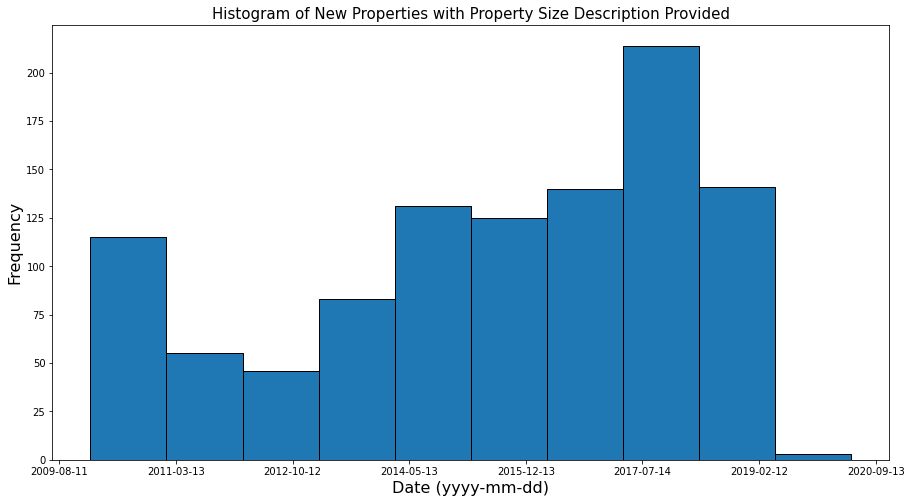

<Figure size 432x288 with 0 Axes>

In [77]:
dateformat = FuncFormatter(datetimeString)
dateConvert = list(map(lambda x: datetime.timestamp(x), list(populatedPropertySize['DateofSale(yyyy-mm-dd)'])))
plt.figure(figsize=(15,8))
plt.title("Histogram of New Properties with Property Size Description Provided", fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Date (yyyy-mm-dd)', fontsize=16)
plt.hist(dateConvert, edgecolor="black")
plt.gca().xaxis.set_major_formatter(dateformat)
plt.show()
plt.savefig('sizes')

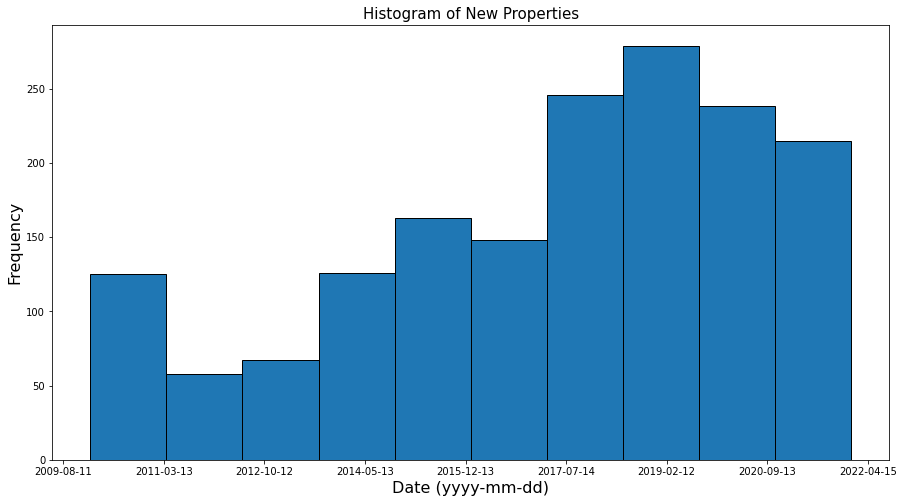

In [78]:
dateformat = FuncFormatter(datetimeString)
dateConvert = list(map(lambda x: datetime.timestamp(x), list(newProperties['DateofSale(yyyy-mm-dd)'])))
plt.figure(figsize=(15,8))
plt.title("Histogram of New Properties", fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Date (yyyy-mm-dd)', fontsize=16)
plt.hist(dateConvert, edgecolor="black")
plt.gca().xaxis.set_major_formatter(dateformat)
plt.show()

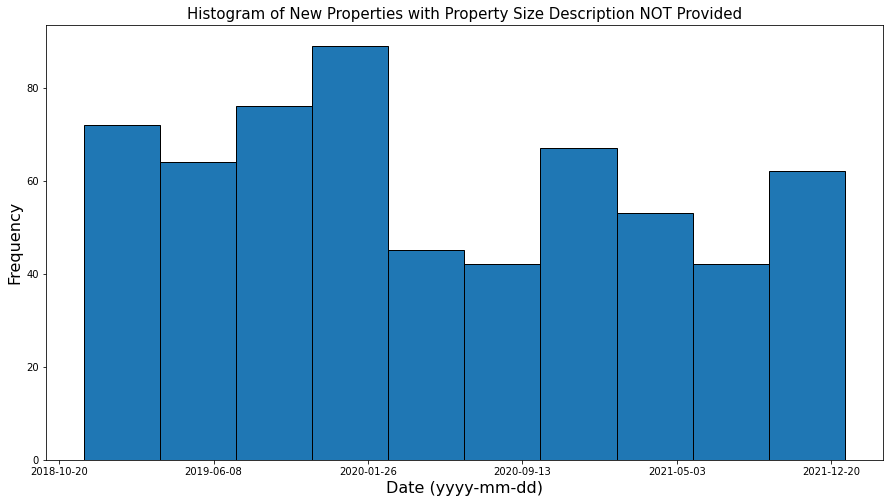

In [79]:
dateformat = FuncFormatter(datetimeString)
dateConvert = list(map(lambda x: datetime.timestamp(x), list(newPropertiesNoDesc['DateofSale(yyyy-mm-dd)'])))
plt.figure(figsize=(15,8))
plt.title("Histogram of New Properties with Property Size Description NOT Provided", fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Date (yyyy-mm-dd)', fontsize=16)
plt.hist(dateConvert, edgecolor="black")
plt.gca().xaxis.set_major_formatter(dateformat)
plt.show()

It's clear that only recently data began to not be populated for the Property Size Description Field. This will need to be taken into consideration for analysis.

In [80]:
# look at all of the properties that have the same address and sort them by address
duplicatedAddresses = dfclean[dfclean["Address"].duplicated(keep=False)].sort_values("Address")
duplicatedAddresses

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
7523,2019-08-13,"[28 rosary road, maryland, dublin 8]",Dublin 8,Dublin,345000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
1411,2014-05-22,"[28 rosary road, maryland, dublin 8]",Dublin 8,Dublin,175000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
9073,2015-11-19,"[3 windy arbour, athboy, meath]",NaN,Meath,102500.0,No,No,Second-Hand Dwelling house /Apartment,NaN
2639,2019-02-25,"[3 windy arbour, athboy, meath]",NaN,Meath,137500.0,No,No,Second-Hand Dwelling house /Apartment,NaN
668,2019-07-26,"[3 woodside demense, aikens village, stepaside]",NaN,Dublin,590000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
9106,2016-03-03,"[3 woodside demense, aikens village, stepaside]",NaN,Dublin,436123.0,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
589,2016-12-08,"[42 downshire place, edenderry, offaly]",NaN,Offaly,44053.0,No,No,Second-Hand Dwelling house /Apartment,NaN
3848,2016-12-15,"[42 downshire place, edenderry, offaly]",NaN,Offaly,68000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
5526,2018-10-09,"[43 palmerston rd, rathmines, dublin 6]",Dublin 6,Dublin,2100000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
1150,2021-07-14,"[43 palmerston rd, rathmines, dublin 6]",Dublin 6,Dublin,2400000.0,No,No,Second-Hand Dwelling house /Apartment,NaN


Can see that two rows with the same address do not have the same property size description. However, we know now that this is only populated for properties that are new, which it is not the second time. Therefore we will leave this unchanged.

<b>Issue 5: Duplicated Property Size Description Category</b><br>

In task 1 I observed that 2 of the description fields are essentially the same. We can update 'greater than 125 sq metres' to 'greater than or equal to 125 sq metres'. In this section I will also reduce the size of 'greater than or equal to 38 sq metres and less than 125 sq metres' to 'between 38 and 125 sq metres' so that it is more legible in charts further on.

In [81]:
# add the new reduced wording category to replace 'greater than or equal to 38 sq metres and less than 125 sq metres'
dfclean['PropertySizeDescription'] = dfclean['PropertySizeDescription'].cat.add_categories("between 38 and 125 sq metres")

In [82]:
# iterate through rows to make both changes
for index, row in dfclean.iterrows():
    if row["PropertySizeDescription"]=="greater than 125 sq metres":
        dfclean.loc[index,"PropertySizeDescription"] = "greater than or equal to 125 sq metres"
    if row["PropertySizeDescription"]=="greater than or equal to 38 sq metres and less than 125 sq metres":
        dfclean.loc[index,"PropertySizeDescription"] = "between 38 and 125 sq metres"

In [83]:
# look at the categories now - 2 with 0 values
dfclean["PropertySizeDescription"].value_counts(dropna=False)

NaN                                                                  8945
between 38 and 125 sq metres                                          788
greater than or equal to 125 sq metres                                208
less than 38 sq metres                                                 57
greater than 125 sq metres                                              0
greater than or equal to 38 sq metres and less than 125 sq metres       0
Name: PropertySizeDescription, dtype: int64

In [84]:
# remove the empty categories
dfclean['PropertySizeDescription'] = dfclean['PropertySizeDescription'].cat.remove_categories(["greater than 125 sq metres", "greater than or equal to 38 sq metres and less than 125 sq metres"])

<b>Issue 6: Not all new build properties are inclusive of VAT</b><br>

As discovered in task 1, only new properties are marked as not inclusive of VAT, however, not all new properties are marked as exclusive. The sale prices for these will need to be updated to reflect this. Not all new properties are exclusive of VAT, and so the conversion is justified for uniformity.

The VAT rate is 13.5% and so we can simply update the price for each property that was included in the dataframe as VAT exclusive.

In [85]:
# iterate through the rows
for index, row in dfclean.iterrows():
    # update VAT exclusive rows
    if row["VATExclusive"]=="Yes":
        dfclean.loc[index,'Price(€)'] = round(row['Price(€)'] * 1.135, 2)

<b>Issue 7: Some prices not at market value</b><br>

I saw in part 1 that a considerable amount of the properties in the dataframe were not listed at full market price. This means that the data we have for some properties is not reflective of the actual valuation.

In [86]:
notmarketprice = dfclean[dfclean["NotFullMarketPrice"].isin(["Yes"])]
notmarketprice.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Price(€),458.0,155074.32,181830.99,6000.0,61800.89,120000.0,204250.0,2213250.0


In [87]:
marketprice = dfclean[dfclean["NotFullMarketPrice"].isin(["No"])]
marketprice.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Price(€),9540.0,277602.8,515195.06,5500.0,125000.0,210000.0,325000.0,26286500.0


Clearly the of prices of properties not priced at their full price is signifcantly smaller than those priced at market value.

<b>Issue 8: Dataset contains block purchases</b><br>

As seen in part 1, there are quite a few entries that relate to block purchases of properties, which distorts the distribution of the data that is supposed to represent single property purchases.

In [88]:
# noting that the below list of terms are associated with purchases of blocks of properties
propertyGroup = ['-', '&', 'inclusive', 'units', 'apartments']
for index, row in dfclean.iterrows():
    for term in propertyGroup:
        # only search the first part of each address
        if term in row['Address'][0]:
            print(row['Address'], row['Price(€)'])
            # break to prevent duplicates showing up if more than 1 match
            break

['5-7  9-13  15  17 & 19', ' somerton walk (incl.)', ' newcastle road  lucan'] 3216892.09
['rear of 4 & 6 thorncastle st', ' ringsend', ' dublin 4'] 420000.0
['apartment 57 & car space 57', ' the forum', ' sandyford'] 259200.71
['14 units at ardan na mara', ' youghal'] 1804721.33
['19 the orchard apartments', ' cloverhill road', ' clondalkin'] 60000.0
['9 riverside apartments', ' main street', ' arklow'] 80000.0
['grogan & corroe', ' ballycumber', ' co offaly'] 250000.0
['units 1-16 millteog', ' blackfriary', ' athboy road'] 4860499.99
['apt.5 - the avon', ' the courtyard', ' newtownforbes'] 86000.0
['1 high st apartments', ' tralee', ' co kerry'] 248076.0
['1-10 (inclusive) creig ard', ' roscam', ' galway'] 3650000.0
['40-47 (inclusive) springfield grove', ' rossmore village', ' dundrum road  tipperary'] 1214434.11
['nos. 22 & 23 bounds court', ' airport road'] 317518.52
['apt 1 & 2', ' bridge st', ' swinford'] 12000.0
['nos. 12  13  14  & 15', ' pairc na coille', ' showgrounds road  

In [89]:
# update property group to remove '&' and 'apartments' which are not always blocks
propertyGroup = ['-', 'inclusive', 'units']
for index, row in dfclean.iterrows():
    for term in propertyGroup:
        if term in row['Address'][0]:
            print(row['Address'], row['Price(€)'])
            break

['5-7  9-13  15  17 & 19', ' somerton walk (incl.)', ' newcastle road  lucan'] 3216892.09
['14 units at ardan na mara', ' youghal'] 1804721.33
['units 1-16 millteog', ' blackfriary', ' athboy road'] 4860499.99
['apt.5 - the avon', ' the courtyard', ' newtownforbes'] 86000.0
['1-10 (inclusive) creig ard', ' roscam', ' galway'] 3650000.0
['40-47 (inclusive) springfield grove', ' rossmore village', ' dundrum road  tipperary'] 1214434.11
['120-122  &120a', ' lower kilmacud road', ' stillorgan'] 225000.0
['apt.9 - rivercourt', ' the dolmen hotel', ' carlow road'] 10000.0
['11 units at baunoge', ' loughrea'] 873950.0
['1 -5', ' 79 parnell street', ' dublin 1'] 585000.0
['unit.90e  - first floor', ' danesfort drive', ' loughrea'] 70000.0
['13-22 leana theas', ' cappgh road', ' galway'] 2355824.0
['21 units', ' clover court retirement village', ' shinrone  co offaly'] 834437.0
['apt.2 - carlyle house', ' church road', ' howth'] 160000.0
['32  34-61  belville court', ' johnstown rd', ' cabintee

All of the above with high prices look to be block purchases. Not overly significant if the price is low but perhaps if we filter for those with a price above 1 standard deviation above the mean.

In [90]:
# set a new column equal to Price(€) column
dfclean['CleanedPrice(€)'] = dfclean['Price(€)']

In [91]:
propertyGroup = ['-', 'inclusive', 'units']
for index, row in dfclean.iterrows():
    for term in propertyGroup:
        if term in row['Address'][0]:
            # only interested in properties with prices above one standard deviation above the mean
            if row["CleanedPrice(€)"]>(dfclean["Price(€)"].mean()+dfclean["Price(€)"].std()):
                print(row['Address'], row['Price(€)'])
                break

['5-7  9-13  15  17 & 19', ' somerton walk (incl.)', ' newcastle road  lucan'] 3216892.09
['14 units at ardan na mara', ' youghal'] 1804721.33
['units 1-16 millteog', ' blackfriary', ' athboy road'] 4860499.99
['1-10 (inclusive) creig ard', ' roscam', ' galway'] 3650000.0
['40-47 (inclusive) springfield grove', ' rossmore village', ' dundrum road  tipperary'] 1214434.11
['11 units at baunoge', ' loughrea'] 873950.0
['13-22 leana theas', ' cappgh road', ' galway'] 2355824.0
['21 units', ' clover court retirement village', ' shinrone  co offaly'] 834437.0
['32  34-61  belville court', ' johnstown rd', ' cabinteely dublin 18'] 10394000.0
['21-31 maple grove', ' smithborough', ' co. monaghan'] 1448000.08
['apts 7-16 block4', ' brian friel hall', ' mccaffery student village'] 800000.0


In [92]:
# now remove them
# initialise counter to see how many removed
counter = 0
for index, row in dfclean.iterrows():
    for term in propertyGroup:
        if term in row['Address'][0]:
            if row["Price(€)"] > (dfclean["Price(€)"].mean()+dfclean["Price(€)"].std()):
                dfclean.loc[index,'CleanedPrice(€)'] = np.nan
                counter += 1
                break
print(counter, "prices of block purchases removed from new price column.")

11 prices of block purchases removed from new price column.


<b>Issue 9: Prices are not normalised - significant outliers</b><br>

As mentioned in part 1, it appears as though the prices follow a lognormal distribution, a feature generally associated with house price distributions.

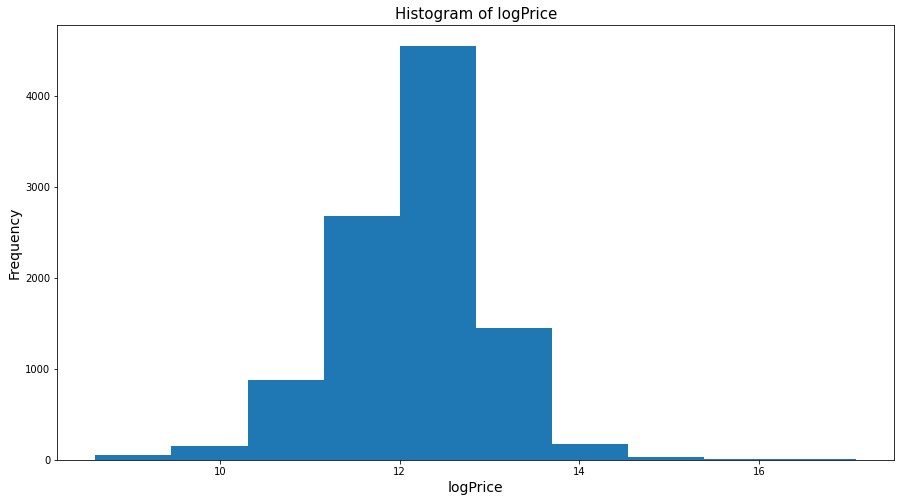

In [93]:
# set a log price column from the CleanedPrice(€) column
dfclean['logPrice'] = dfclean['CleanedPrice(€)'].apply(lambda row: np.log(row))
dfclean['logPrice'] = dfclean['logPrice'].astype(float)


# plotting the logPrice to see if it is now normal data
plt.figure(figsize=(15,8))
plt.title("Histogram of logPrice", fontsize=15)
plt.xlabel("logPrice", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.hist(dfclean['logPrice'])
plt.show()

The distribution of the log price seems to follow roughly a normal distribution.

In [94]:
# create a list of all counties
allcounties = dfclean['County'].unique().tolist()

In [95]:
# initialise counter to see how may prices removed
pricecounter = 0
# loop through county list
for county in allcounties:
    # create a new dataframe for county
    subdataframe = dfclean[dfclean['County'].isin([county])]
    # iterate through this dataframe
    for index, row in subdataframe.iterrows():
        # check if log price is above 2 standard deviations above the mean
        if row['logPrice'] > (subdataframe["logPrice"].mean() + 2*subdataframe["logPrice"].std()):
            # apply change to dfclean, not new dataframe
            dfclean.loc[index,'logPrice'] = np.nan
            pricecounter += 1

# set CleanedPrice(€) to exponent of what is left of logPrice column
dfclean['CleanedPrice(€)'] = dfclean['logPrice'].apply(lambda row: np.exp(row))

# no need for logPrice column any more
dfclean.drop('logPrice', axis=1, inplace=True)

print(pricecounter, "prices of outliers removed from new price column.")

167 prices of outliers removed from new price column.


In [96]:
dfclean.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Price(€),9998.0,271989.87,505404.30,5500.0,120000.0,205000.0,319999.99,26286500.0
CleanedPrice(€),9820.0,237978.01,170029.05,5500.0,120000.0,200000.0,310000.00,1250000.0


In [97]:
print("Standard deviation of CleanedPrice(€) is now " 
      + str(round(((dfclean["Price(€)"].std()-dfclean["CleanedPrice(€)"].std())/dfclean["Price(€)"].std())*100,1))
      + "% lower than Price(€).")

Standard deviation of CleanedPrice(€) is now 66.4% lower than Price(€).


### Summary of data quality plan:

| Feature                    | Issue Description           | Chosen Solution              |
|------------------------------------|-------------------------------|--------------------------------|
| Address                          | Addresses in current format have little value                         | Change format to list to allow for information extraction                           |
| Postal Code                   | Missing Postal Codes| Extract Postal Codes from the Address Field using lists  |
| Postal Code                    | Some Dublin Postal Codes are not in Dublin             | Remove Postal Code from the rows    |
| Property Size Description                        | Missing Property Size Descriptions                       | No action                           |
| Property Size Description                   | Duplicated Property Size Description Category                | Merge categories                      |
| VAT Exclusive                 | Not all new build properties are inclusive of VAT               | Add VAT to properties exclusive of VAT|
| Not Full Market Price                       | Some prices not at market value              | No action     |
| Price (€)                       | Dataset contains block purchases              | Remove properties identified as duplicates from a new price column                   |
| Price (€)                  | Prices are not normalised - significant outliers|Remove log prices that are 2 standard deviations above the mean of each county     |

In [98]:
# export data frame to a csv
dfclean.to_csv('datasets/PPRFileFullyCleaned.csv', index=False)

## Part 3 - Exploring relationships between feature pairs.

In [99]:
from ast import literal_eval
# use commas as separator
dffullyclean = pd.read_csv('datasets/PPRFileFullyCleaned.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, converters={'Address': literal_eval})

In [100]:
# converting once again
dffullyclean['DateofSale(yyyy-mm-dd)'] = dffullyclean['DateofSale(yyyy-mm-dd)'].astype('datetime64[ns]')
categorical_cols = ["PostalCode", "County", "NotFullMarketPrice", "VATExclusive", 
                    "DescriptionofProperty", "PropertySizeDescription"]

for feature in categorical_cols:
    dffullyclean[feature] = dffullyclean[feature].astype('category')

In [101]:
dffullyclean.dtypes

DateofSale(yyyy-mm-dd)     datetime64[ns]
Address                            object
PostalCode                       category
County                           category
Price(€)                          float64
NotFullMarketPrice               category
VATExclusive                     category
DescriptionofProperty            category
PropertySizeDescription          category
CleanedPrice(€)                   float64
dtype: object

<b>Date vs Price</b>

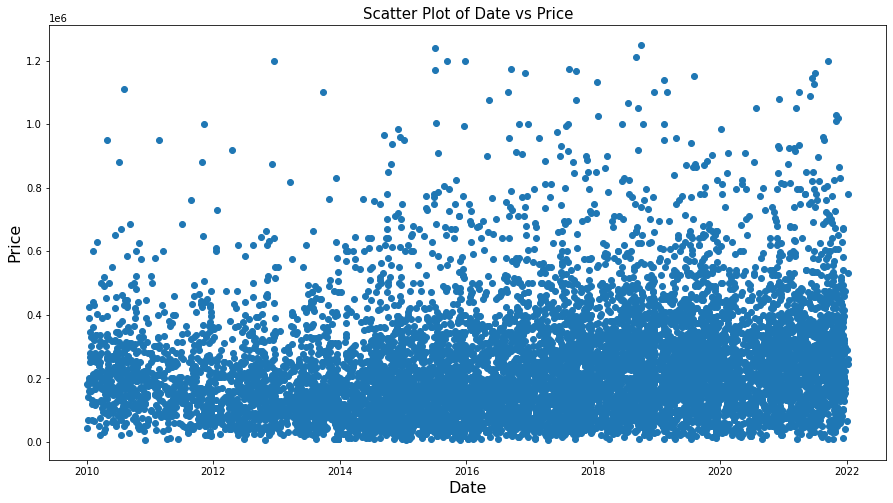

In [102]:
# list of dates and prices
dates = list(dffullyclean['DateofSale(yyyy-mm-dd)'])
prices = list(dffullyclean['CleanedPrice(€)'])
plt.figure(figsize=(15,8))
plt.title("Scatter Plot of Date vs Price", fontsize=15)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.scatter(dates, prices)
plt.show()

- It is difficult to see a strong relationship in the above chart, however, in general it looks as though prices are generally larger as time goes by.
- However, I would caveat this by noting that the number of entries in later years is greater, and therefore it may just be that the extra datapoints in later years are making it look as though prices are rising.

/var/folders/sk/nrbzmqq1715frfmf08t0c02c0000gn/T/ipykernel_15459/4222063717.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newlabels)


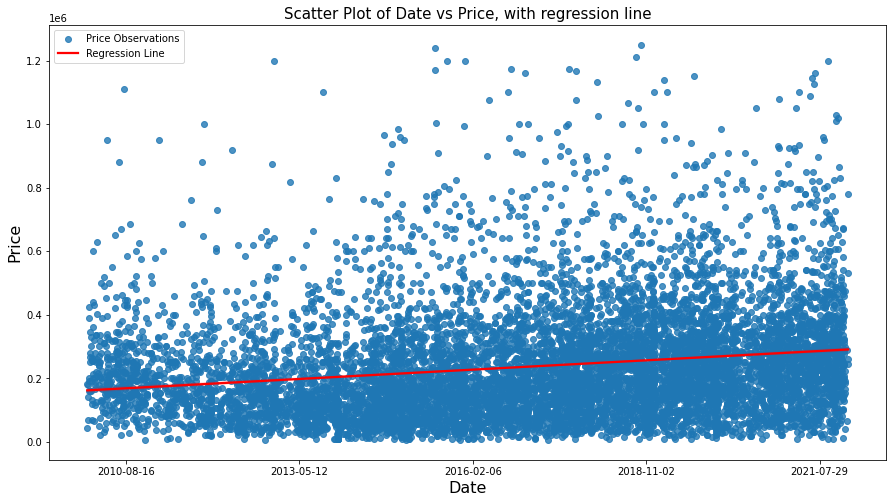

In [103]:
# code for the below inspired from https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis
plt.figure(figsize=(15,8))
ax = sns.regplot(
    x=pd.to_datetime(dffullyclean['DateofSale(yyyy-mm-dd)']).apply(lambda date: date.toordinal()),
    y=dffullyclean['CleanedPrice(€)'], line_kws={"color": "red"}
)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title("Scatter Plot of Date vs Price, with regression line", fontsize=15)
newlabels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(newlabels)
plt.legend(labels=["Price Observations","Regression Line"])
plt.show()


- Adding a regression increases the clarity of the trend
- Clearly, as time goes by, the average price is increasing, albeit quite slightly

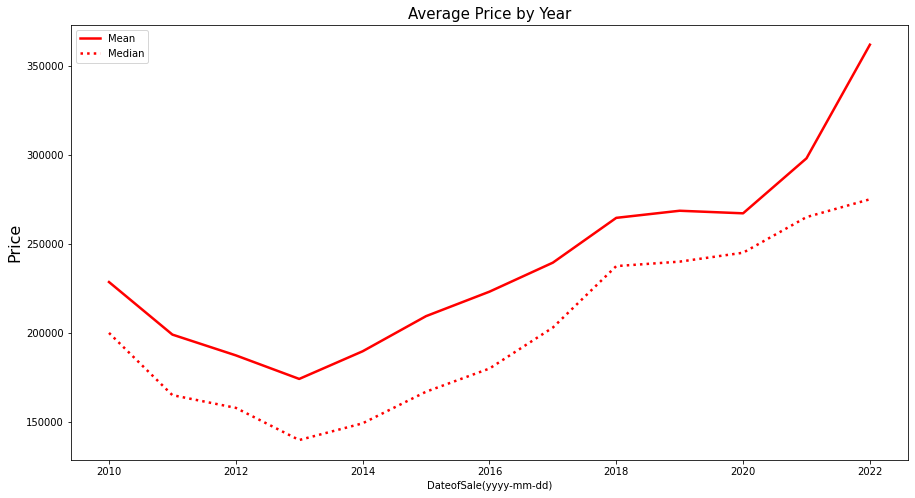

In [104]:
# create a list with the years
years = [x for x in range (2010,2023)]

# calculate means and medians for each year
means = dffullyclean["CleanedPrice(€)"].groupby(dffullyclean['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
medians = dffullyclean["CleanedPrice(€)"].groupby(dffullyclean['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()

plt.figure(figsize=(15,8))
plt.title("Average Price by Year", fontsize=15)
plt.ylabel('Price', fontsize=16)

means.plot(label="Mean", color="red", linewidth=2.5)

medians.plot(label="Median", color="red", linestyle='dotted', linewidth=2.5)
plt.legend()
plt.show()

- Looking at a plot of both the Mean and Median per year, again I note the general upward trend in prices.
- The Median is below the Mean, implying some distortion caused by large outliers. This is despite the cleaning in part 2, showing just how wide the variation is versus the middle values (i.e. the Median).

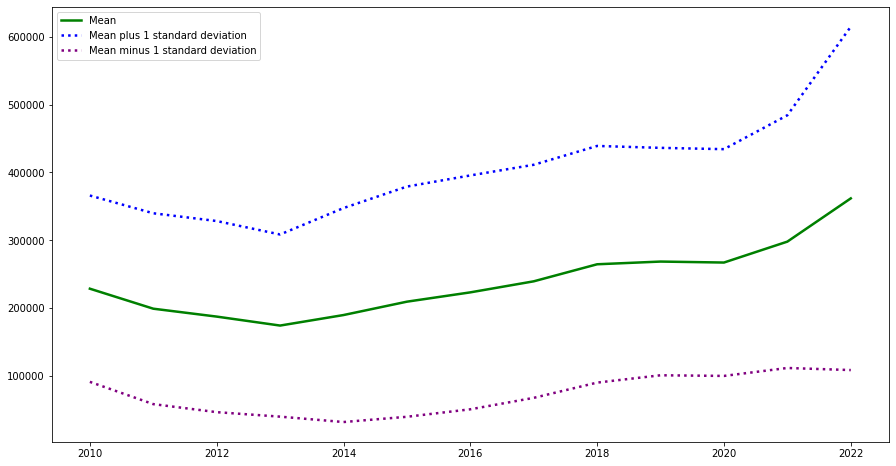

In [105]:
# calculate standard deviations per year
stds = dffullyclean["CleanedPrice(€)"].groupby(dffullyclean['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).std()
upperbound = []
lowerbound = []
# define a list of mean values plus and minus the standard deviation
for value in range(len(list(stds))):
    lowerbound.append(list(means)[value]-list(stds)[value])
    upperbound.append(list(stds)[value]+list(means)[value])

plt.figure(figsize=(15,8))
plt.plot(years, list(means), label="Mean", color="green", linewidth=2.5)
plt.plot(years, upperbound, label="Mean plus 1 standard deviation", color="blue", linestyle='dotted', linewidth=2.5)
plt.plot(years, lowerbound, label="Mean minus 1 standard deviation", color="purple", linestyle='dotted', linewidth=2.5)
plt.legend()
plt.show()

- Once again I note the general upward trend in average prices
- I further note that the range of values covered by the first standard deviation above and below the mean, generally seems to be increasing as time goes by.
- This implies a wider variation in prices (likely caused by more, quite expensive) properties being sold

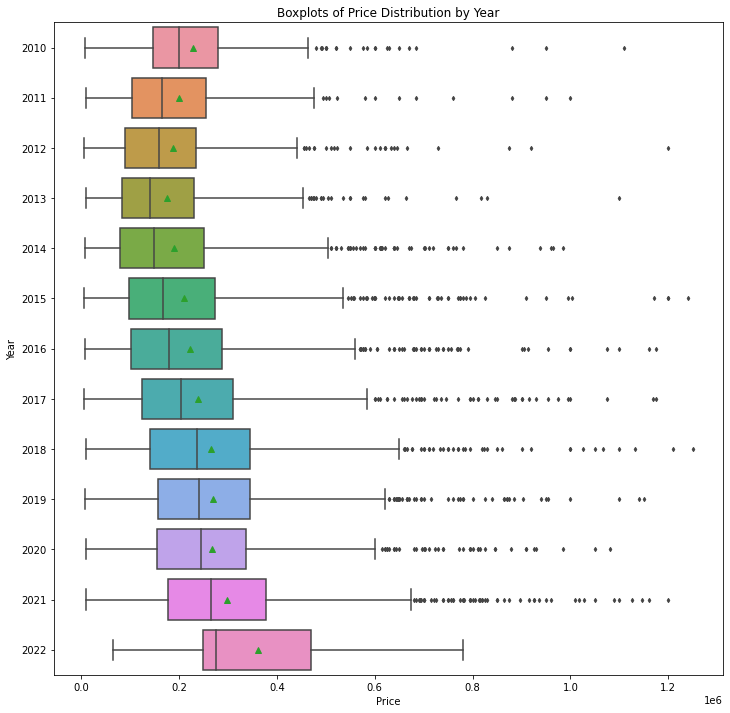

In [106]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x = dffullyclean['CleanedPrice(€)'], y=(dffullyclean['DateofSale(yyyy-mm-dd)'].dt.to_period('Y')).sort_values(), 
            fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('Year')
plt.title('Boxplots of Price Distribution by Year')
plt.show()

- The above boxplot for each year in our dataset is compelling in the story it depicts
- This is a clear indication of persistent, rising prices as time goes by
- Prices fell at the start of the period to a small extent, but since 2015 it looks as though that trend significantly reversed
- It also interesting to note the significant number of outliers on the right hand side of the chart. This shows that although we can define general relationships for the average behaviour there will still be numerous values outside our range (even after cleaning).
- Not only do the boxes generally move to the right as time goes by, it is interesting to note the movement of the middle black lines and the green triangles. This shows the same thing as the line graphs above.

<b>County vs Price</b>

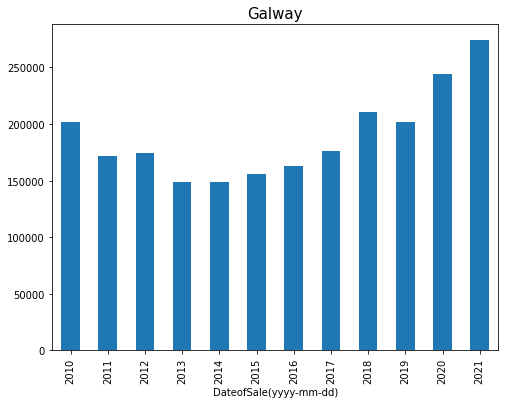

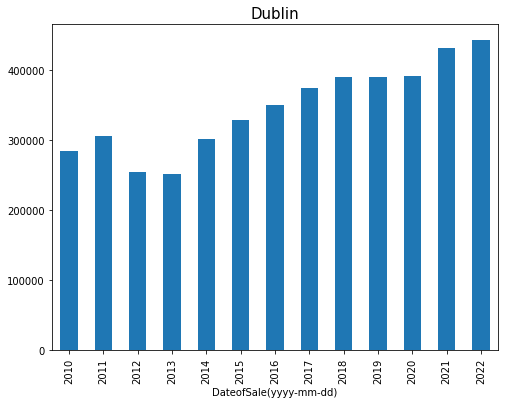

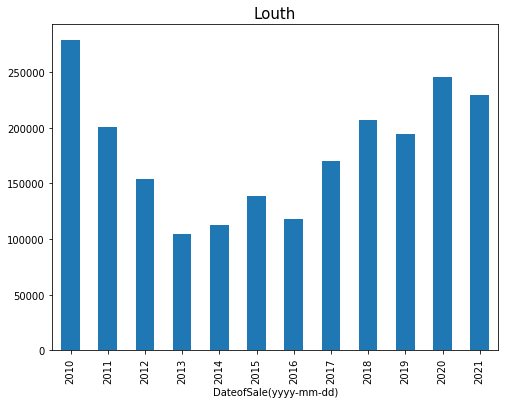

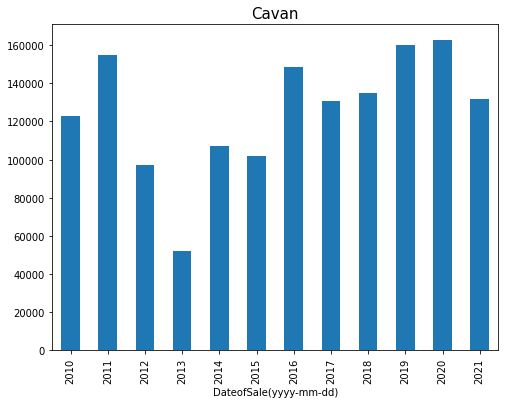

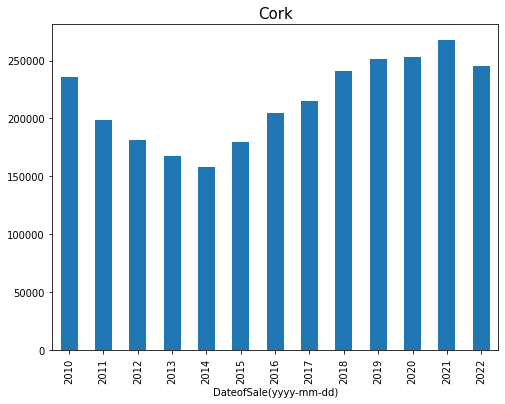

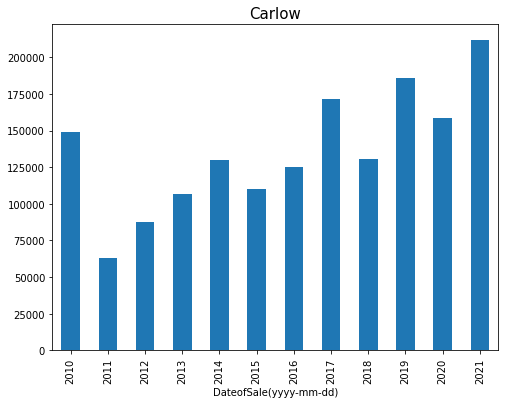

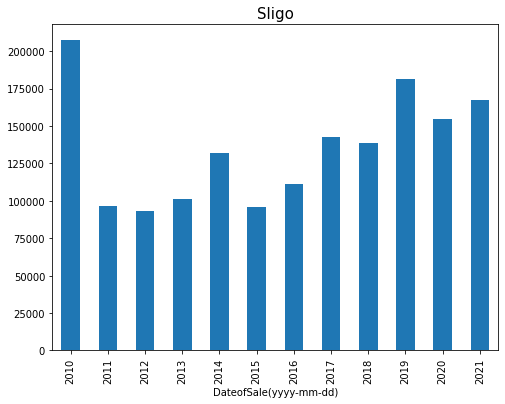

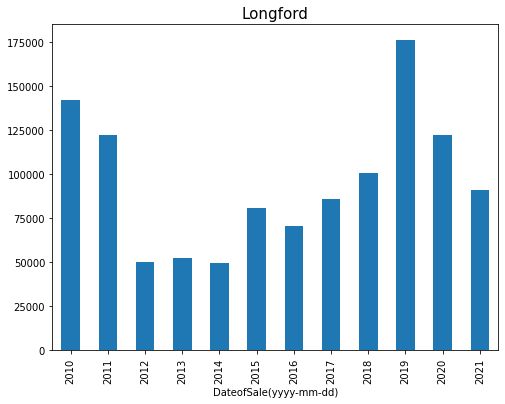

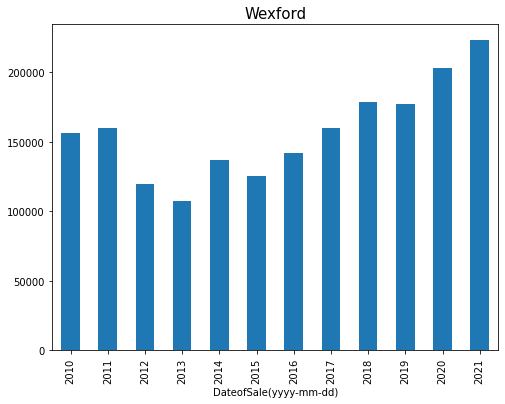

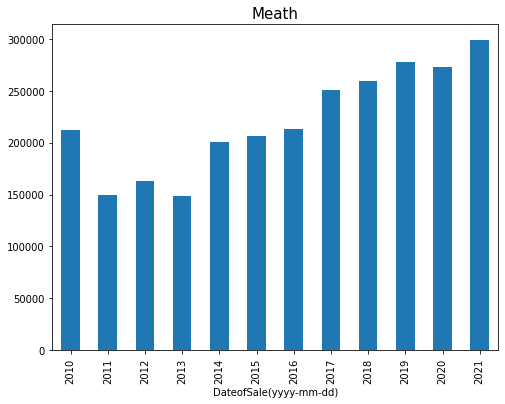

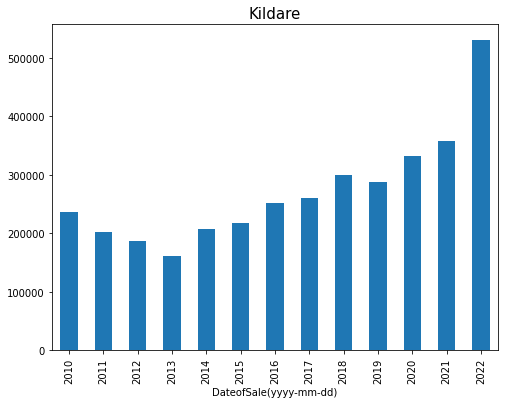

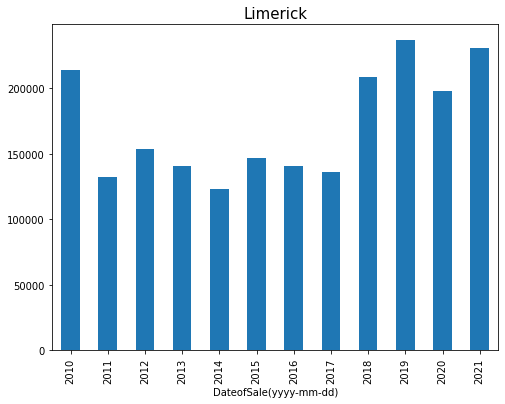

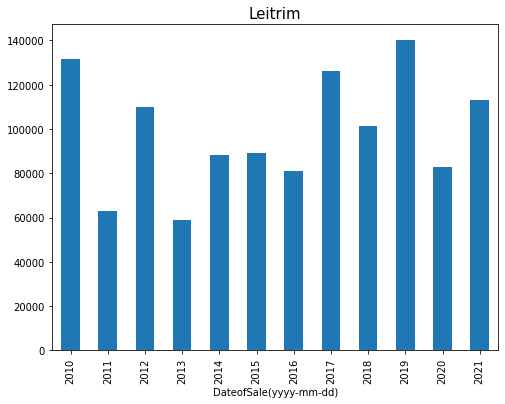

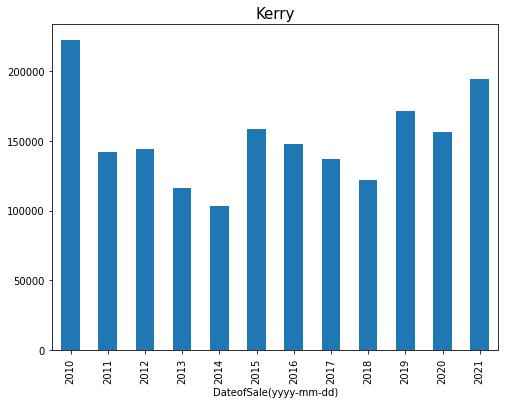

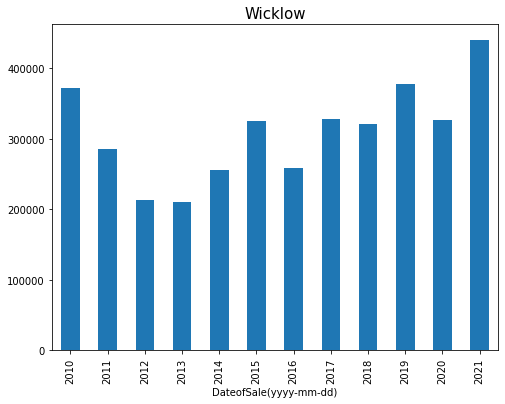

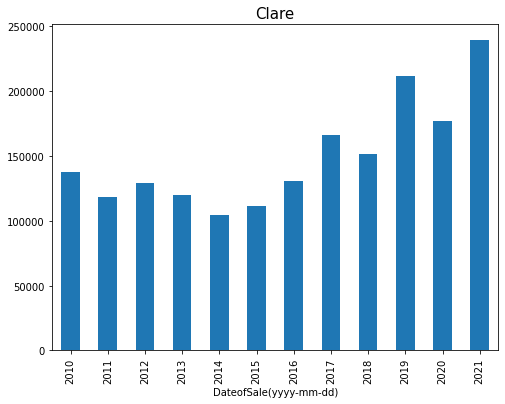

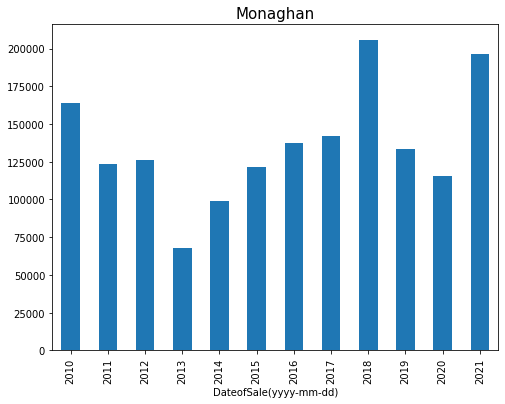

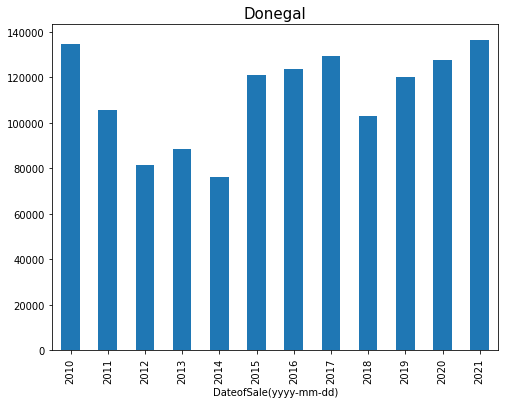

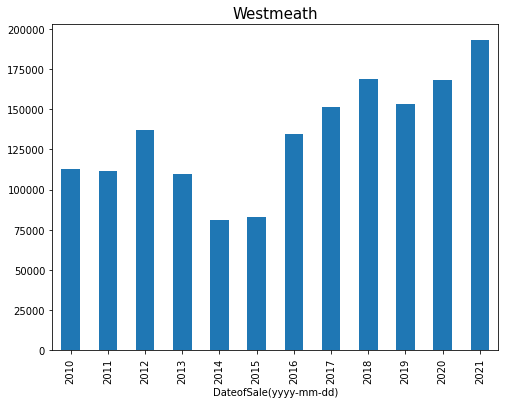

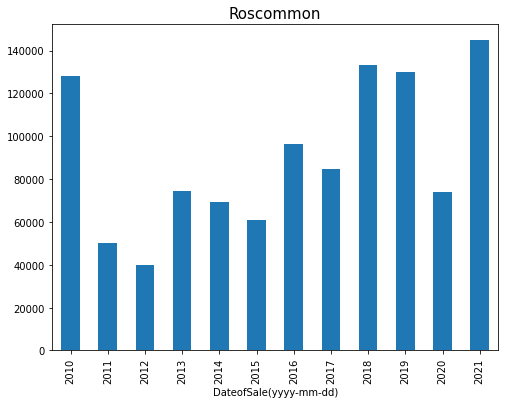

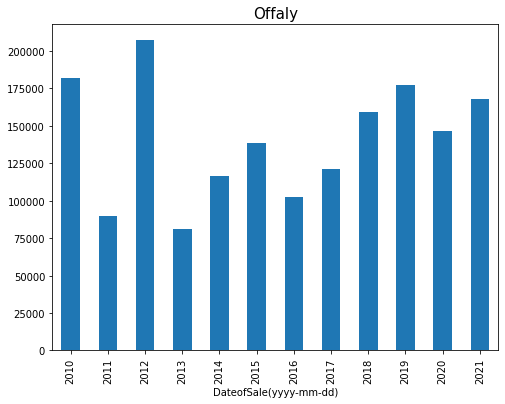

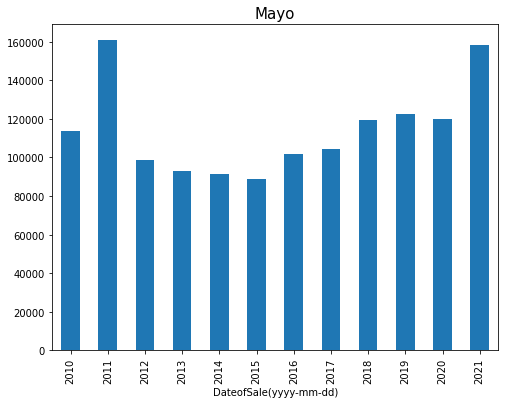

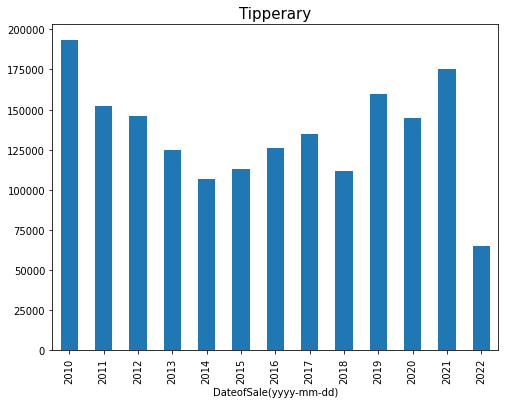

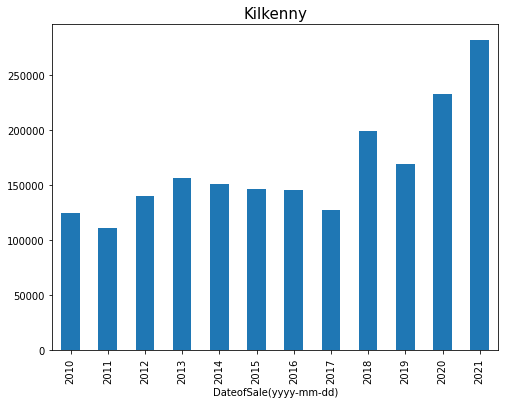

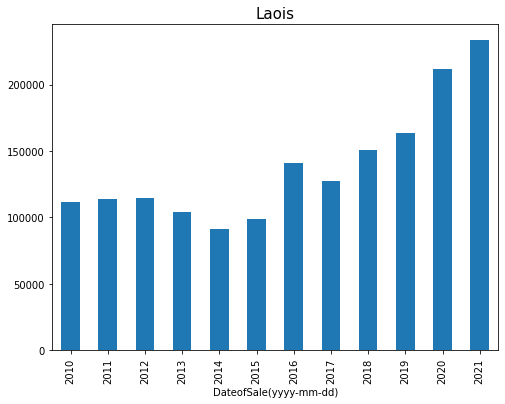

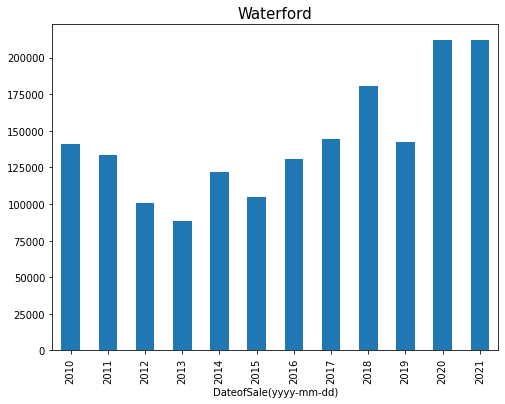

In [107]:
for county in allcounties:
    subdf = dffullyclean[dffullyclean['County'].isin([county])]
    countyMeans = subdf['CleanedPrice(€)'].groupby(subdf['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
    plt.figure(figsize=(8,6))
    plt.title(county, fontsize=15)
    countyMeans.plot(kind='bar')
    plt.show()

- It is interesting to note a somewhat less pronounced trend in the property prices over time by County, albeit one that is still present.
- This of course is not the same for each County. Some of the larger Counties have more pronounced upward trends.
- It would be interesting to explore the reasons for this. I would guess that this is due to increasing populations, general inflation, or supply constraints, or potentially other reasons.
- One caveat with this data is the small number of samples for some of the smaller counties by population. This means it is hard to extract meaningful observations.
- Another interesting point is how most Counties follow the same general trend, i.e. falling in 2013 or so, before rising. This implies the reasons for the fall was across the entire country, and not specific to any region.

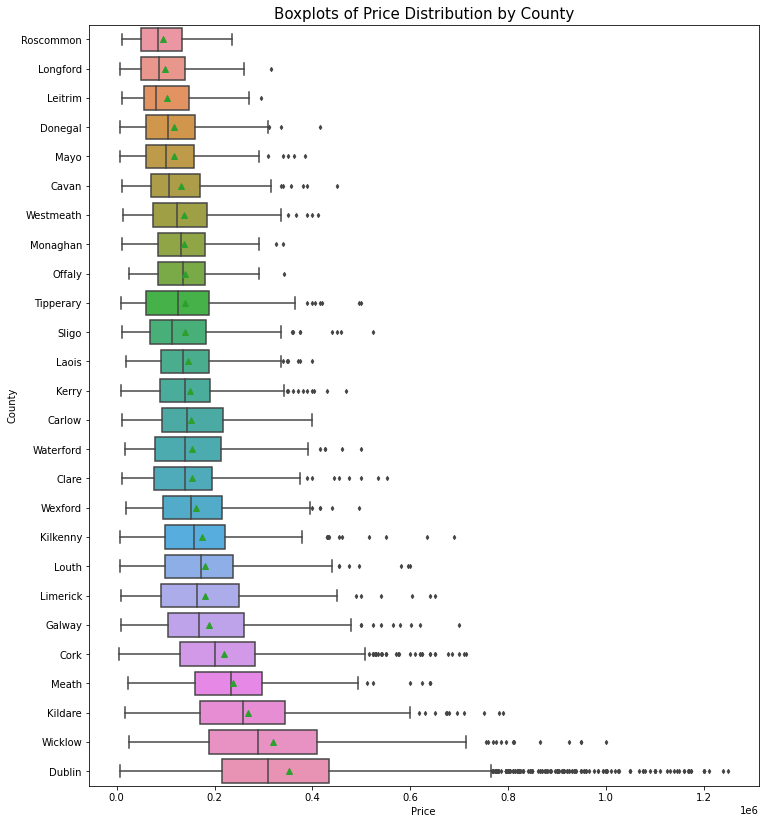

In [108]:
fig, ax = plt.subplots(figsize=(12,14))
means = dffullyclean['CleanedPrice(€)'].groupby(dffullyclean["County"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = dffullyclean['CleanedPrice(€)'], y=dffullyclean['County'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')

plt.title('Boxplots of Price Distribution by County')
plt.show()

- While the previous chart was useful for analysing the change in prices by County over time, the above boxplots show the magnitude in difference between each county average.
- Unsurprisingly, the larger counties, as well as those counties close to Dublin show a much higher average over time.
- Dublin has by the largest averages across both mean and median, while Roscommon has the lowest.
- It is interesting to observe that for every county the mean is greater than the median, the same trend we saw above. This implies a positive skew in the data, meaning there are large outliers increasing the mean.

<b>Postal Code vs Price</b>

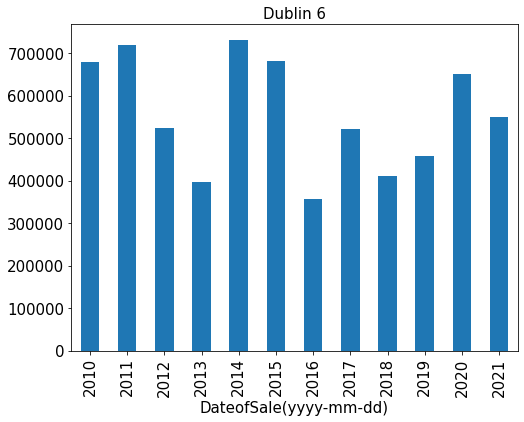

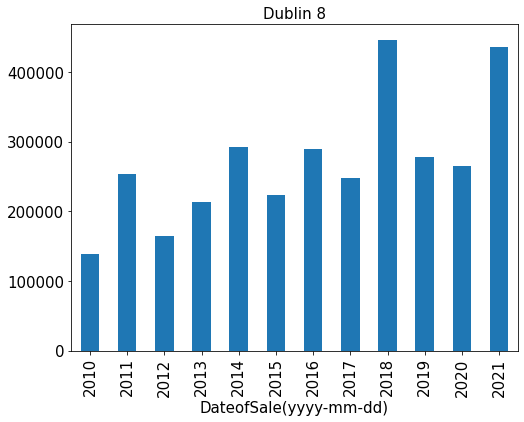

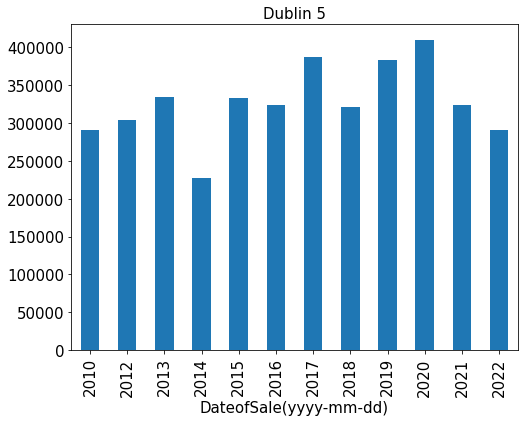

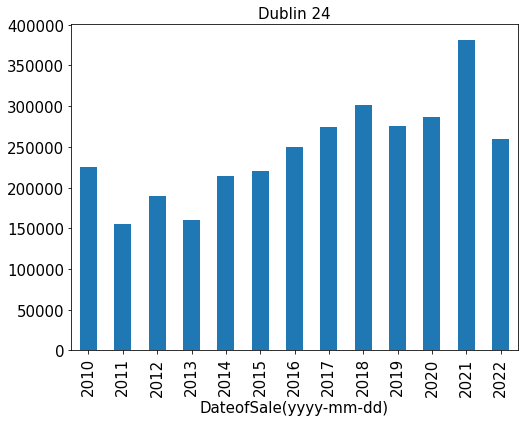

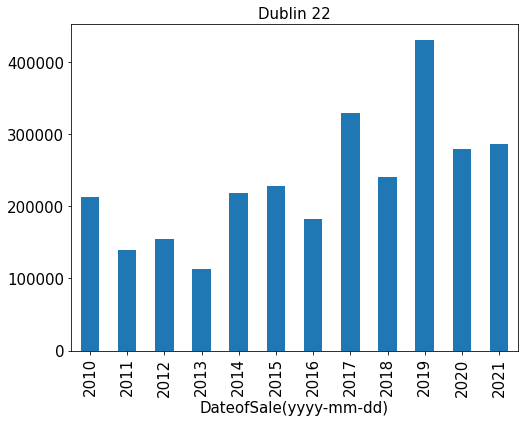

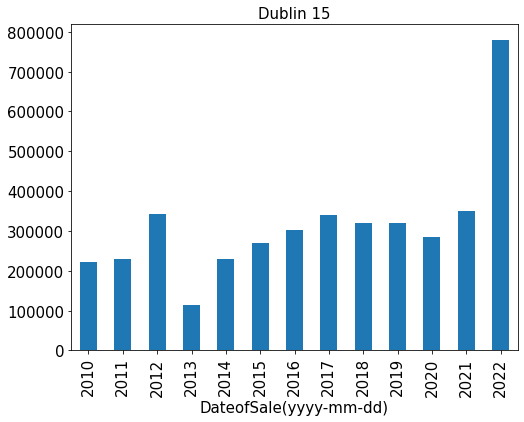

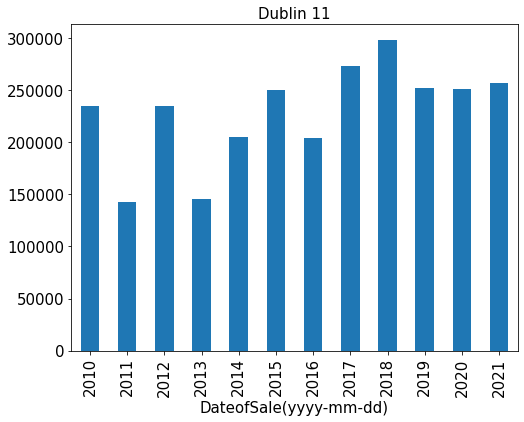

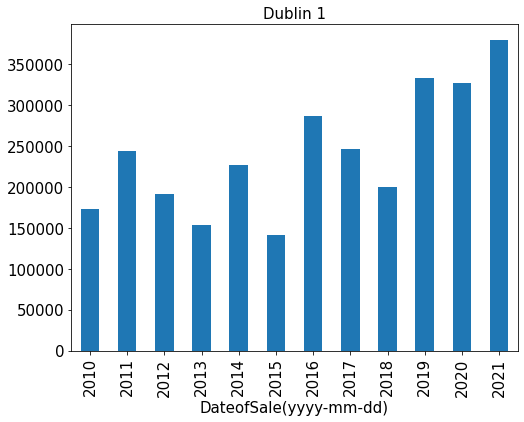

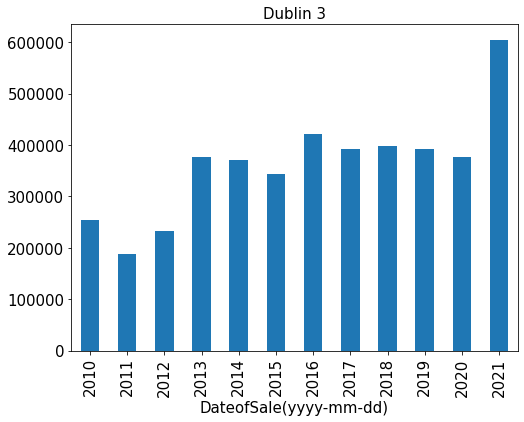

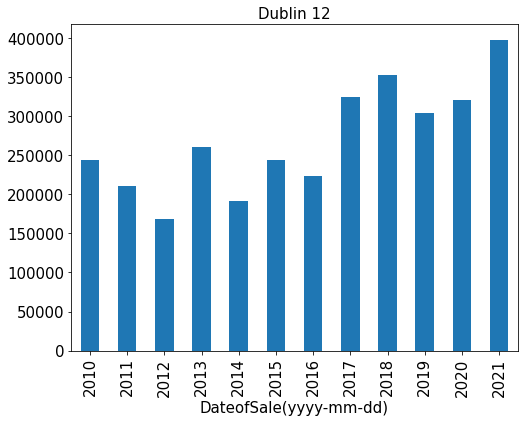

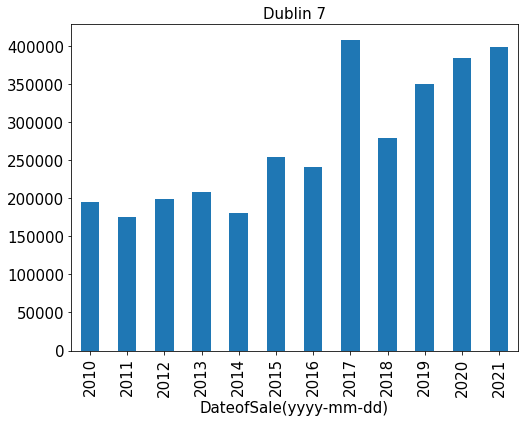

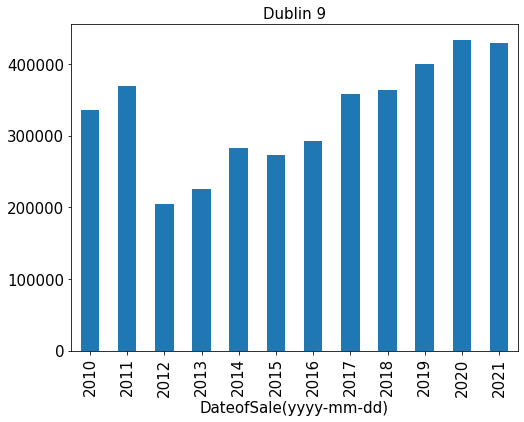

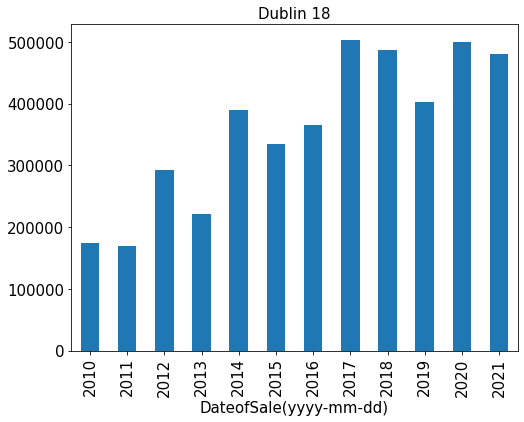

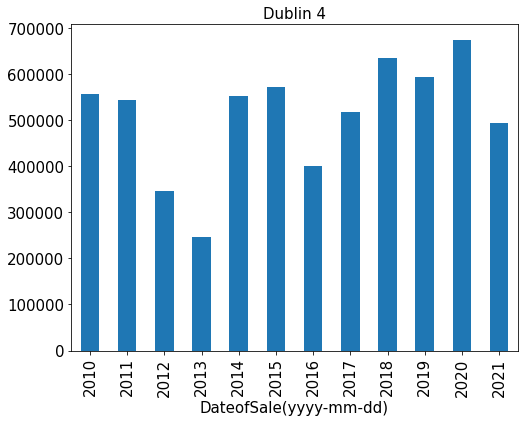

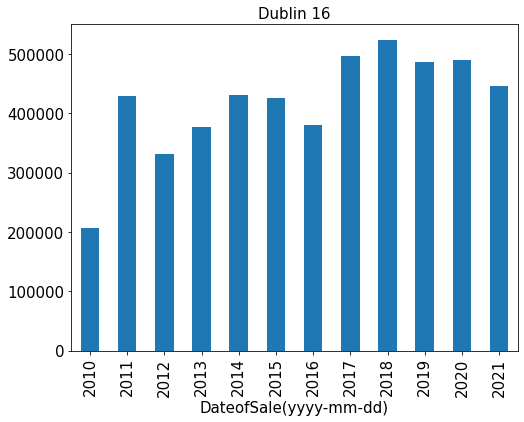

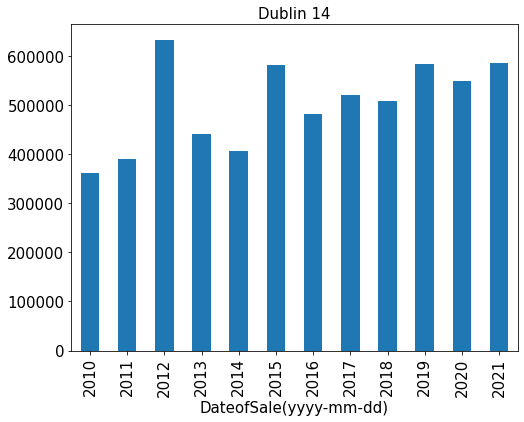

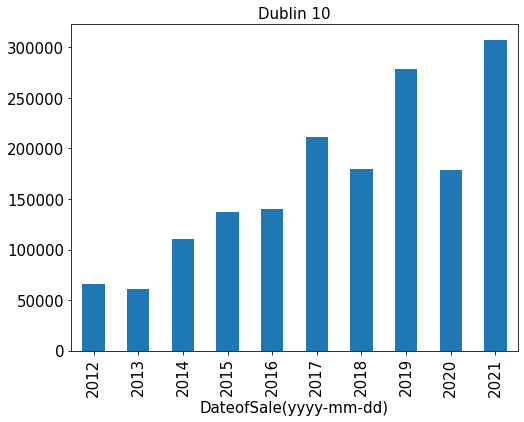

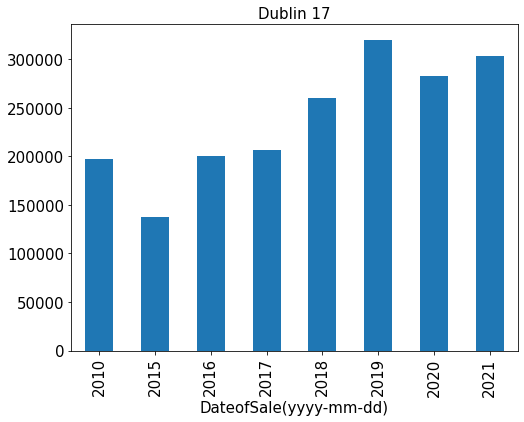

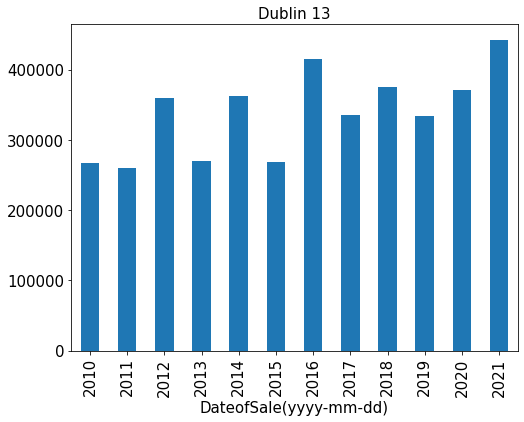

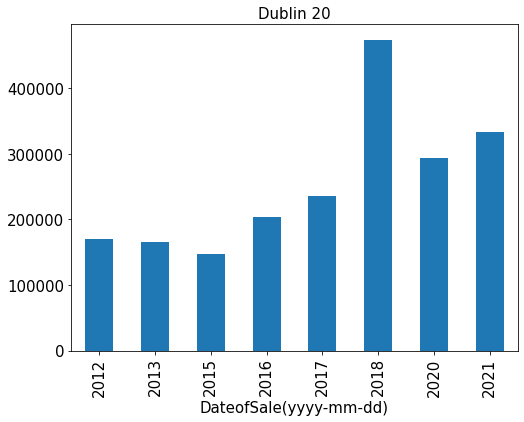

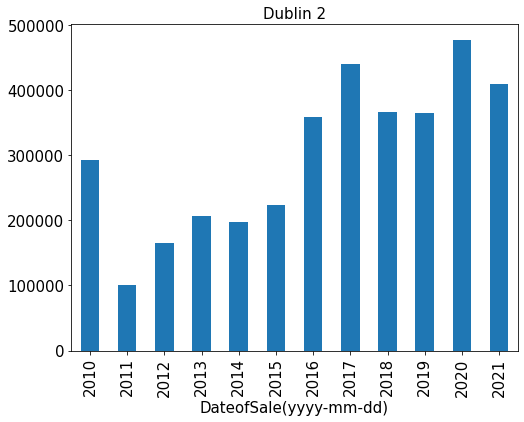

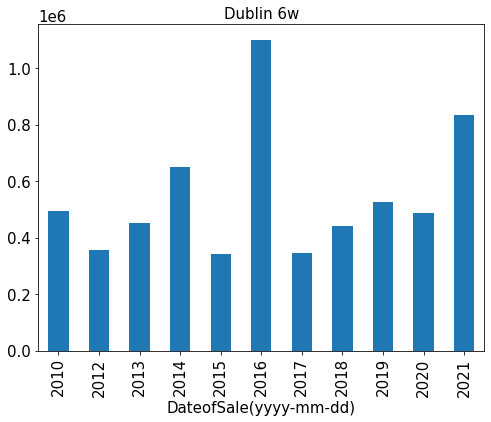

In [109]:
for code in postCodes:
    subdf = dffullyclean[dffullyclean['PostalCode'].isin([code])]
    postalMeans = subdf['CleanedPrice(€)'].groupby(subdf['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
    plt.figure(figsize=(8,6))
    plt.title(code, fontsize=15)
    postalMeans.plot(kind='bar')
    plt.show()

- It is interesting yet again to note a somewhat less pronounced trend in the property prices over time by Postal Code, albeit one that is broadly still present.
- Given the smaller sample size in the Postal Codes and the fact that each year has even fewer observations, it is unsurprising that there are large spikes in some of the charts. This is because outliers are not averaged out to the same extend as happens in large samples.
- Generally speaking however, I do observe a similar trend as before. Prices can generally be seen to rise over time in each Postal Code, following a small decline in c. 2013.
- It is particularly relevant in these charts to note that some of the postal codes have a very small number of observations. This means it is hard to extract meaningful insights.

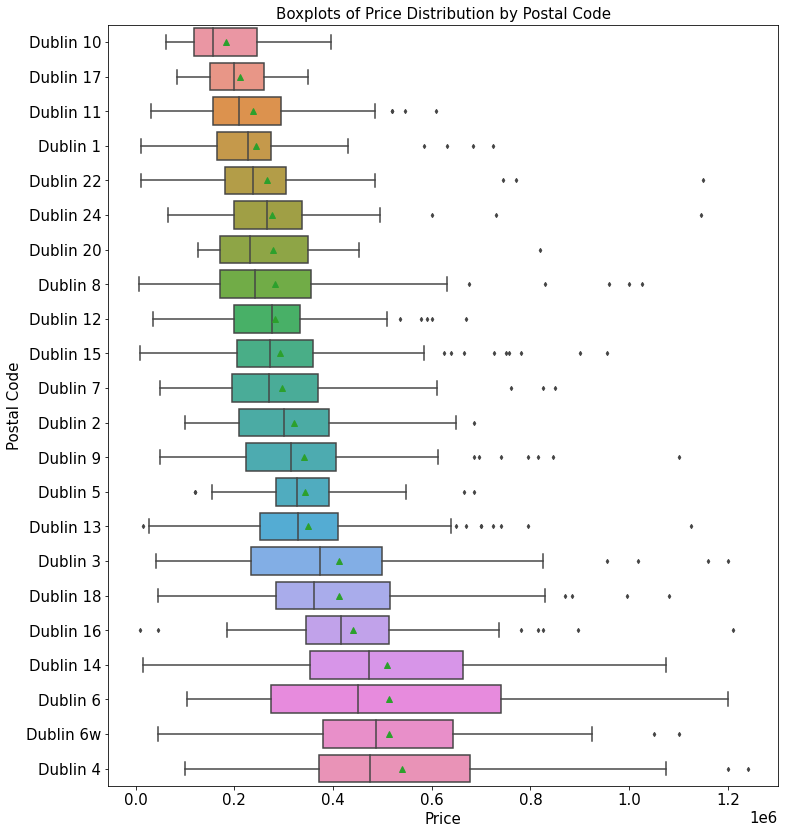

In [110]:
fig, ax = plt.subplots(figsize=(12,14))
means = dffullyclean['CleanedPrice(€)'].groupby(dffullyclean["PostalCode"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = dffullyclean['CleanedPrice(€)'], y=dffullyclean['PostalCode'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')
plt.ylabel('Postal Code')
plt.title('Boxplots of Price Distribution by Postal Code')
plt.show()

- While the previous chart was useful for analysing the change in prices by Postal Code over time, the above boxplots show the magnitude in difference between each Postal Code.
- A widely cited phenomenon is the increased prices consumers pay on the South Side of Dublin versus the North Side. Postal Codes in Dublin are split between odd for North Side areas, and even for South side. There it is striking to observe this trend play out in teh data - we can see that the last 6 counties (which are ordered by mean) are South side postal codes, confirming this trend over the last 12 years or so.
- Another interesting insight is the postal code with the highest average - Dublin 4. This is often cited as a very posh area in Dublin.
- Once again, it is interesting to observe that for every area the mean is greater than the median, the same trend we saw above. This implies a positive skew in the data, meaning there are large outliers increasing the mean.
- It would be interesting if we could get a larger dataset of properties in Dublin, or else somehow extract more missing postal codes for Dublin properties than I managed to above. This would lead to more statistically significant results.

<b>Property Description vs Price</b>

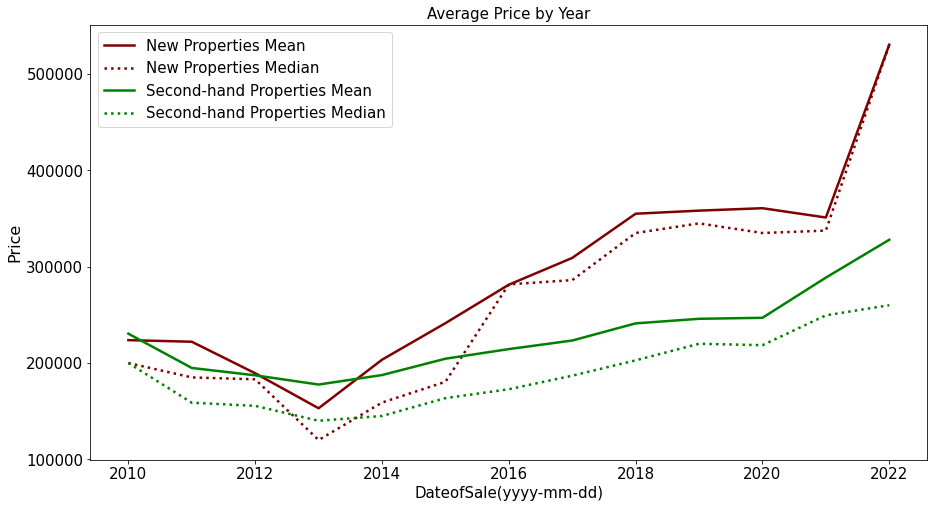

In [111]:
newprops = dffullyclean[dffullyclean['DescriptionofProperty'].isin(['New Dwelling house /Apartment'])]
oldprops = dffullyclean[dffullyclean['DescriptionofProperty'].isin(['Second-Hand Dwelling house /Apartment'])]
meansnew = newprops['CleanedPrice(€)'].groupby(newprops['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
meansold = oldprops['CleanedPrice(€)'].groupby(oldprops['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
mediannew = newprops['CleanedPrice(€)'].groupby(newprops['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()
mediansold = oldprops['CleanedPrice(€)'].groupby(oldprops['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()
plt.figure(figsize=(15,8))
plt.title("Average Price by Year", fontsize=15)
plt.ylabel('Price', fontsize=16)

meansnew.plot(label="New Properties Mean", color="maroon", linewidth=2.5)
mediannew.plot(label="New Properties Median", color="maroon", linestyle='dotted', linewidth=2.5)
meansold.plot(label="Second-hand Properties Mean", color="green", linewidth=2.5)
mediansold.plot(label="Second-hand Properties Median", color="green", linestyle='dotted', linewidth=2.5)
plt.legend()
plt.show()

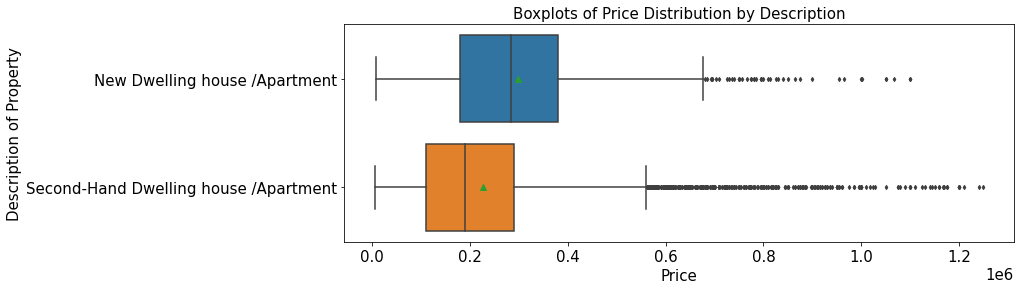

In [112]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = dffullyclean['CleanedPrice(€)'], y=dffullyclean['DescriptionofProperty'], fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('Description of Property')
plt.title('Boxplots of Price Distribution by Description')
plt.show()

In [113]:
populatedprice = dffullyclean[dffullyclean["CleanedPrice(€)"].notnull()]
r, p = stats.pearsonr(populatedprice['DescriptionofProperty'].map({'New Dwelling house /Apartment':True ,'Second-Hand Dwelling house /Apartment':False}), populatedprice['CleanedPrice(€)'])
print('Pearson\'s correlation r is %s with a p-value = %s' %(r,p))

Pearson's correlation r is 0.1571740984645874 with a p-value = 2.394795477095651e-55


- It is interesting to note once again, the persistent rising prices over time, shown in both new and second-hand prices. Again, I observe a dip in prices in c. 2013.
- More noteworthy still, is how the market for second-hand prices was more resilient in times of price declines. In 2013, the price of second hand-houses did not fall by close to the same extent that new properties fell by.
- It is interesting to note that new properties consistently sell for higher prices than second-hand prices in times of price increases. In 2013 the price of second-hand properties was above new properties.
- It would be interesting to explore if the trend prices of second-hand properties dropping slower than new properties was a once off in 2013, or is a consistent trend observed over time.
- Once again, it is interesting to observe that for every area the mean is greater than the median for both subsets, the same trend we saw above. This implies a positive skew in the data, meaning there are large outliers increasing the mean.
- It is also interesting to note the weak positive correlation in price and the property being new. Although small, we can be quite confident in this value given the really small p-value (small probability the relationship occured by chance).

<b>Not Full Market Price vs Price</b>

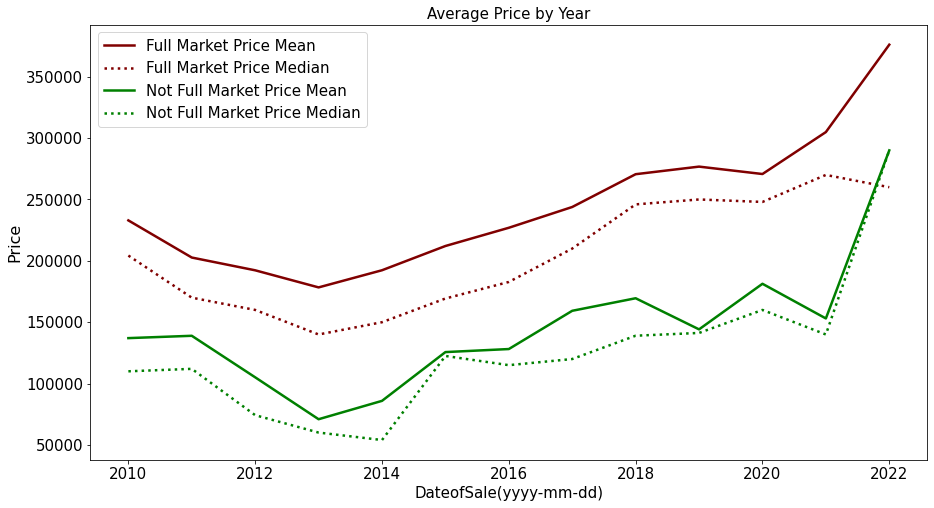

In [114]:
full = dffullyclean[dffullyclean['NotFullMarketPrice'].isin(['No'])]
notfull = dffullyclean[dffullyclean['NotFullMarketPrice'].isin(['Yes'])]
meansfull = full['CleanedPrice(€)'].groupby(full['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
meansnotfull = notfull['CleanedPrice(€)'].groupby(notfull['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
medianfull = full['CleanedPrice(€)'].groupby(full['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()
mediannotfull = notfull['CleanedPrice(€)'].groupby(notfull['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()
plt.figure(figsize=(15,8))
plt.title("Average Price by Year", fontsize=15)
plt.ylabel('Price', fontsize=16)

meansfull.plot(label="Full Market Price Mean", color="maroon", linewidth=2.5)
medianfull.plot(label="Full Market Price Median", color="maroon", linestyle='dotted', linewidth=2.5)
meansnotfull.plot(label="Not Full Market Price Mean", color="green", linewidth=2.5)
mediannotfull.plot(label="Not Full Market Price Median", color="green", linestyle='dotted', linewidth=2.5)
plt.legend()
plt.show()

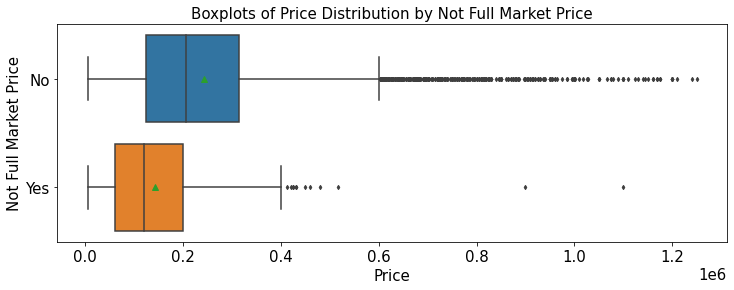

In [115]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = dffullyclean['CleanedPrice(€)'], y=dffullyclean['NotFullMarketPrice'], fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('Not Full Market Price')
plt.title('Boxplots of Price Distribution by Not Full Market Price')
plt.show()

In [116]:
populatedprice = dffullyclean[dffullyclean["CleanedPrice(€)"].notnull()]
r, p = stats.pearsonr(populatedprice['NotFullMarketPrice'].map({'No':True ,'Yes':False}), populatedprice['CleanedPrice(€)'])
print('Pearson\'s correlation r is %s with a p-value = %s' %(r,p))

Pearson's correlation r is 0.12369923584810354 with a p-value = 8.640346795974953e-35


- It is interesting to note once again, the persistent rising prices over time, shown in both categories. Again, I observe a dip in prices in c. 2013.
- I observe properties not being sold at full market price had a greater decline in prices in 2013. Perhaps this is due to the small sample size, but there may be some other reason.
- Unsurprisingly, the average price of properties being sold for full market price is greater than those not being sold for full market price. It shows the impact of including those not sold for full market price on overall statistics for property prices in Ireland. It would be interesting to learn if headline figures touted by the media are inclusive of these properties.
- Once again, it is interesting to observe that for every area the mean is greater than the median for both subsets, the same trend we saw above. This implies a positive skew in the data, meaning there are large outliers increasing the mean.
- It is also interesting to note the weak positive correlation in price and the property being sold for full market price. Although small, we can be quite confident in this value given the really small p-value (small probability the relationship occured by chance).

<b>Property Size Description vs Price</b>

It is worth recalling that the Property Size Description Field is only populated for new properties, and was not populated for recent entries in the dataframe.

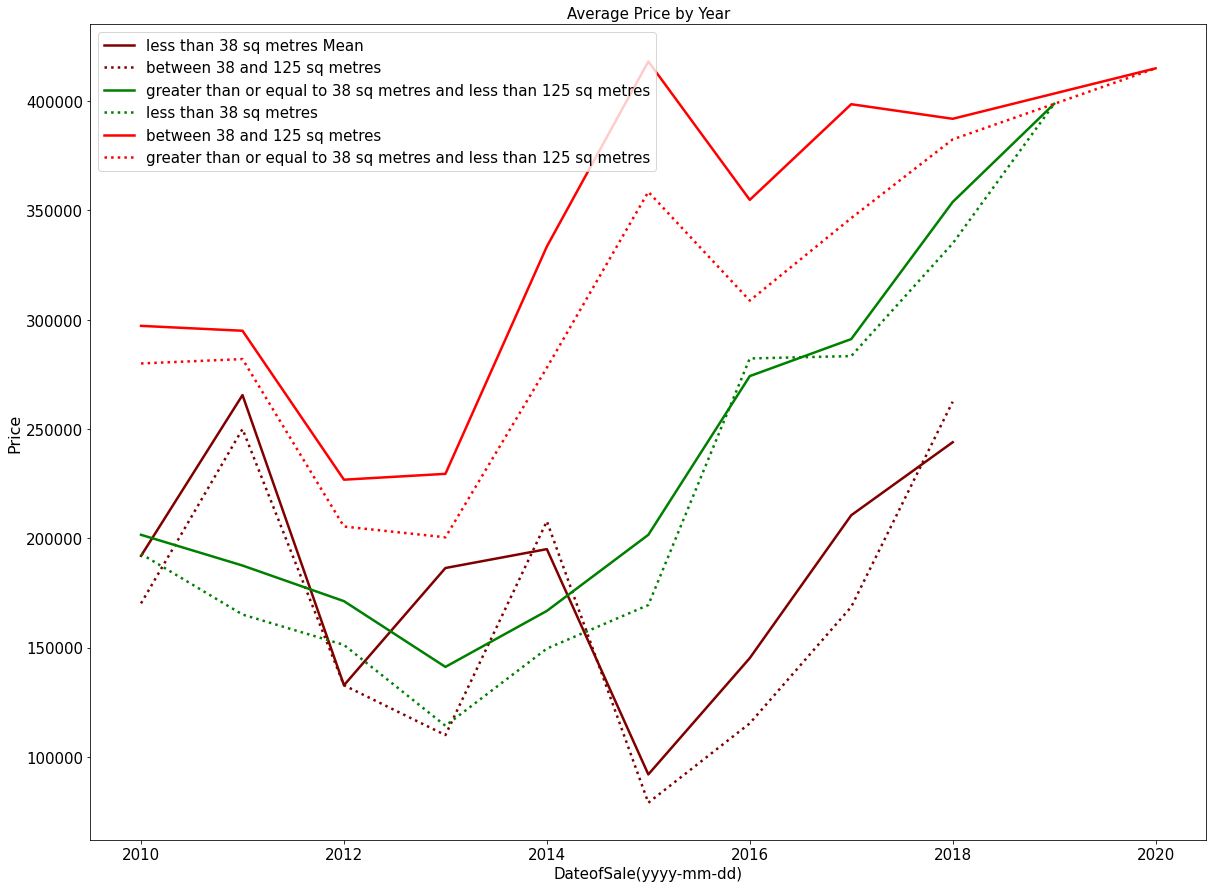

In [117]:
small = dffullyclean[dffullyclean['PropertySizeDescription'].isin(['less than 38 sq metres'])]
medium = dffullyclean[dffullyclean['PropertySizeDescription'].isin(['between 38 and 125 sq metres'])]
large = dffullyclean[dffullyclean['PropertySizeDescription'].isin(['greater than or equal to 125 sq metres'])]

meanssmall = small['CleanedPrice(€)'].groupby(small['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
meansmedium = medium['CleanedPrice(€)'].groupby(medium['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
meanslarge = large['CleanedPrice(€)'].groupby(large['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()

mediansmall = small['CleanedPrice(€)'].groupby(small['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()
medianmedium = medium['CleanedPrice(€)'].groupby(medium['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()
medianlarge = large['CleanedPrice(€)'].groupby(large['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).median()

plt.figure(figsize=(20,15))
plt.title("Average Price by Year", fontsize=15)
plt.ylabel('Price', fontsize=16)

meanssmall.plot(label="less than 38 sq metres Mean", color="maroon", linewidth=2.5)
mediansmall.plot(label="between 38 and 125 sq metres", color="maroon", linestyle='dotted', linewidth=2.5)
meansmedium.plot(label="greater than or equal to 38 sq metres and less than 125 sq metres", color="green", linewidth=2.5)
medianmedium.plot(label="less than 38 sq metres", color="green", linestyle='dotted', linewidth=2.5)
meanslarge.plot(label="between 38 and 125 sq metres", color="red", linewidth=2.5)
medianlarge.plot(label="greater than or equal to 38 sq metres and less than 125 sq metres", color="red", linestyle='dotted', linewidth=2.5)
plt.legend()
plt.show()

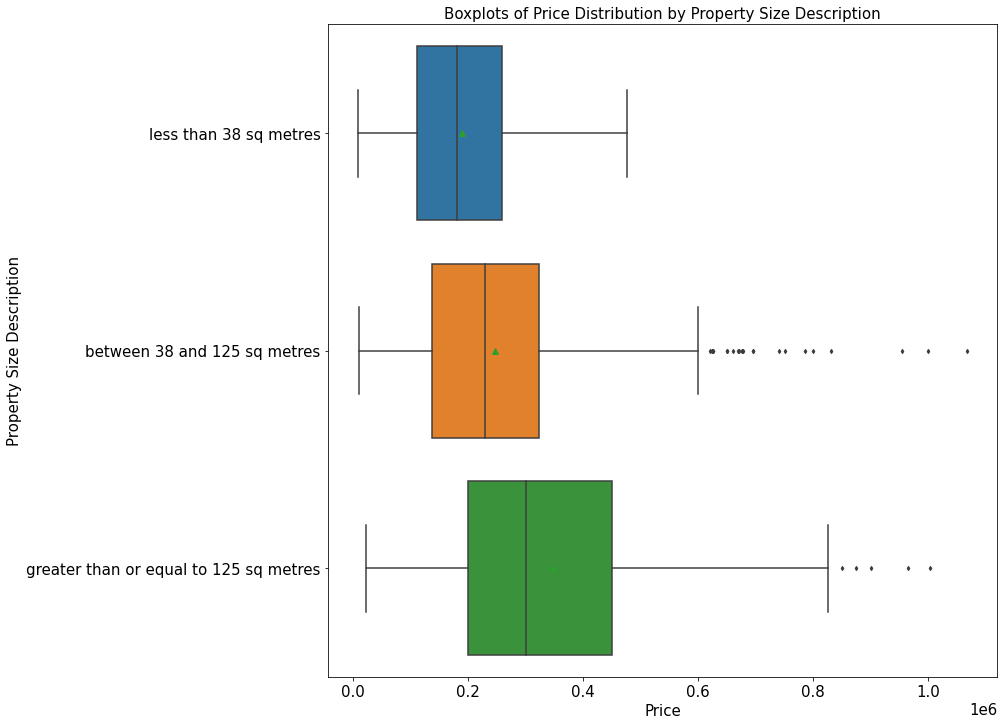

In [118]:
fig, ax = plt.subplots(figsize=(12,12))
means = dffullyclean['CleanedPrice(€)'].groupby(dffullyclean["PropertySizeDescription"]).mean().sort_values().index
sns.boxplot(y=dffullyclean['PropertySizeDescription'], x = dffullyclean['CleanedPrice(€)'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')
plt.ylabel('Property Size Description')
plt.title('Boxplots of Price Distribution by Property Size Description')
plt.show()

- Due to the small sample size (data only available for new properties) it is difficult to make insights over years. Outliers are impacting the mean and median. I note that the data stops early, due to the discontinued use of the feature.
- Generally speaking though we can clearly see that the larger the property the greater the selling price, on average.
- Again I note the greater mean than median in each category, indicating the presence of large outliers.

## Part 4

<b>Additional feature 1: towns</b><br>

As mentioned earlier, in their current format, the addresses pose little value. We can clearly see that the format applied is inconsistent. For example, some end with the county, some with the postal code. There will be no perfect solution to this problem. However, what may be of value is to extract the town names from each (if present - they won't all be of course, a further issue) and store these in a new column. This will allow for further analysis on each town. For this we will need a list of all target towns, and to iterate through the contents of each address list. To prevent incorrectly labelling some entries I will need to be careful, and in my attempts to do so this may add some different problems. To ensure that somewhere like 'Cork Road' in Waterford is not incorrectly classified as 'Cork City' I will cross check that the County of the town matches the County of the datapoint. In addition, to ensure that places in County Cork are not classified as Cork City, I ensure a match is a complete match (spaces and cases aside). This is why I used lists as opposed to RegEx.

csv file downloaded from https://www.downloadexcelfiles.com/wo_en/download-list-cities-boroughs-and-towns-ireland#google_vignette

In [119]:
towns = pd.read_csv('datasets/cities_towns.csv')
towns

,SNo,Name(s),Council,Core County,Other Counties,2011 Tot,�% change Tot,Tot area,Tot dens,2011 Mun,�% change Mun,Mun area,Mun dens,2009 elect,2011 Sub
0,1,Dublin,City,Dublin,"Dublin (D�n Laoghaire�Rathdown, Fingal, South ...","11,10,627",6.2,318,"3,493","5,27,612",4.2,116.58,"4,526","3,47,312","5,83,015"
1,2,Cork,City,Cork,NaN,"1,98,582",4.3,494,402,"1,19,230",?0.2,38.59,"3,090","82,896","79,352"
2,3,Limerick,City,Limerick,Clare,"91,454",0.8,57,"1,604","57,106",8.7,28.38,"2,012","40,358","34,348"
3,4,Galway,City,Galway,NaN,"76,778",5.6,53,"1,449","75,529",4.3,50.00,"1,511","46,164","1,249"
4,5,Waterford,City,Waterford,Kilkenny,"51,519",4.7,44,"1,171","46,732",2.2,38.35,"1,219","26,598","4,787"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,83,Lismore,Town Commissioners,Waterford,NaN,"1,369",10.4,�,�,732,?7.3,0.57,"1,284","1,138",637
83,84,Kilkee,Town Commissioners,Clare,NaN,"1,139",?14,�,�,"1,037",?21.7,5.25,198,"1,063",102
84,85,Granard,Town Commissioners,Longford,NaN,"1,021",9.4,�,�,"1,021",9.4,8.12,126,911,�
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# delete columns that are not needed
towns = towns.drop(towns.columns[[0,2,4,5,6,7,8,9,10,11,12,13,14]], axis=1)
towns = towns.dropna()
towns.columns = towns.columns.str.replace(' ', '')

In [121]:
towns

,Name(s),CoreCounty
0,Dublin,Dublin
1,Cork,Cork
2,Limerick,Limerick
3,Galway,Galway
4,Waterford,Waterford
...,...,...
80,Ballybay,Monaghan
81,Belturbet,Cavan
82,Lismore,Waterford
83,Kilkee,Clare


In [122]:
# replacing Irish names
towns = towns.replace(to_replace='Muine Bheag (Muinebeag, Bagenalstown)', value='Muine Bheag')
towns = towns.replace(to_replace='Navan (An Uaimh)', value='Navan')
towns = towns.replace(to_replace='Kells (Ceannanus M�r)', value='Kells')
towns = towns.replace(to_replace='Newbridge (Droichead Nua)', value='Newbridge')
towns = towns.replace(to_replace='Port Laoise (Portlaoise)', value='Port Laoise')

In [123]:
# list of both to iterate through
townList = towns['Name(s)'].tolist()
countyList = towns['CoreCounty'].tolist()

In [124]:
for index, row in dfclean.iterrows():
    # loop through contents of address field
    for i in row['Address']:
        # loop through towns
        for town in range(len(townList)):
            
            # check if town mentioned in address
            if townList[town].lower().replace(" ", "") == i.lower().replace(" ", ""):
                
                # the town must also match the county
                if row["County"] == countyList[town]:
                    
                    dffullyclean.loc[index,'Town'] = townList[town]

The above attempt to categorise those datapoints from Irish towns resulted in a large number of different towns being assigned to the database - the cardinality is too high for proper analysis. We now need to bucket the smaller towns (i.e. the ones that did not have a high number of properties into a 'Small Towns' category

In [125]:
# list of small towns - add if lest than 50 rows
smalltowns = []
for location, count in dffullyclean['Town'].value_counts().items():
    print(location, count)
    if count < 50:
        smalltowns.append(location)

Dublin 356
Cork 354
Galway 209
Limerick 157
Waterford 132
Wexford 102
Dundalk 94
Wicklow 89
Mullingar 83
Drogheda 82
Navan 79
Naas 79
Kilkenny 78
Letterkenny 74
Sligo 69
Gorey 69
Tralee 67
Ennis 65
Port Laoise 61
Carlow 60
Newbridge 59
Tipperary 56
Cavan 53
Killarney 52
Athlone 50
Nenagh 46
Tullamore 43
Ballina 43
Mallow 42
Bray 42
Monaghan 41
Longford 40
Enniscorthy 39
Greystones 37
Castlebar 36
Tuam 36
Clonmel 35
Westport 34
Athy 32
Leixlip 32
New Ross 30
Kells 27
Balbriggan 27
Midleton 27
Ballinasloe 26
Loughrea 22
Thurles 22
Dungarvan 22
Arklow 22
Ardee 21
Bandon 21
Cobh 21
Kilkee 20
Youghal 20
Trim 18
Edenderry 18
Tramore 17
Bantry 17
Boyle 15
Listowel 15
Macroom 15
Birr 14
Mountmellick 14
Carrickmacross 13
Buncrana 12
Ballyshannon 12
Bundoran 12
Kilrush 10
Fermoy 10
Shannon 8
Belturbet 8
Kinsale 8
Cashel 7
Passage West 5
Templemore 5
Clonakilty 4
Granard 3
Skibbereen 3
Castleblaney 3
Lismore 3
Cootehill 2
Clones 1
Carrick-on-Suir 1


In [126]:
# assign changes to Town column in dataframe
for index, row in dffullyclean.iterrows():
    if row['Town'] in smalltowns:
        dffullyclean.loc[index,'Town'] = 'Small Towns'

We can now convert town to a category.

In [127]:
dffullyclean['Town'] = dffullyclean['Town'].astype('category')

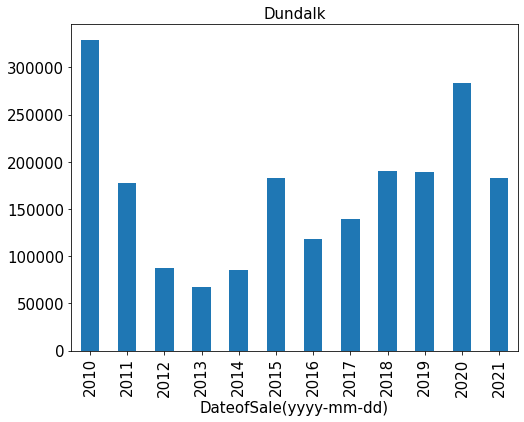

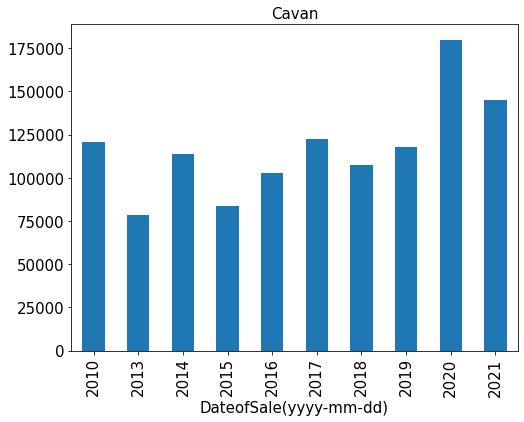

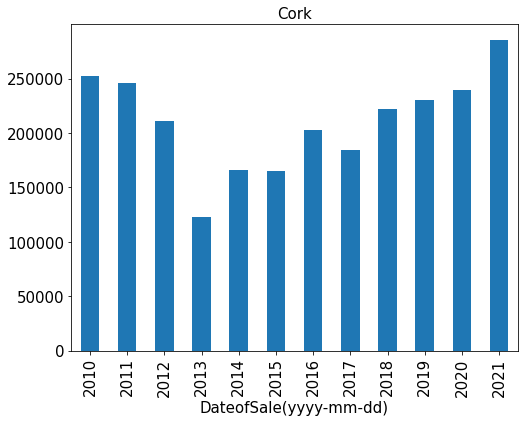

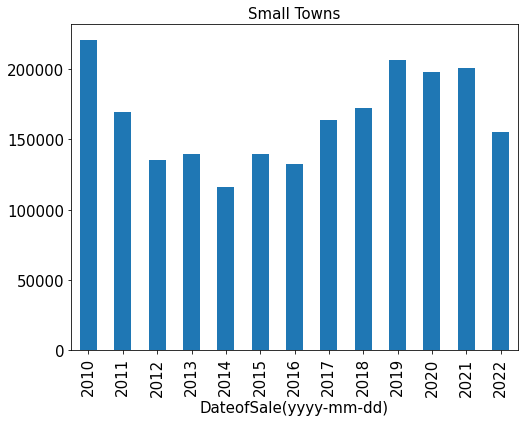

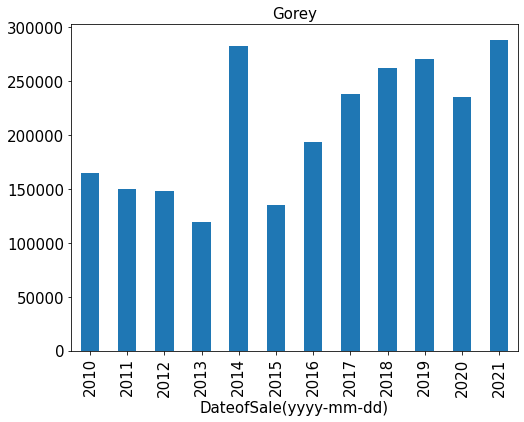

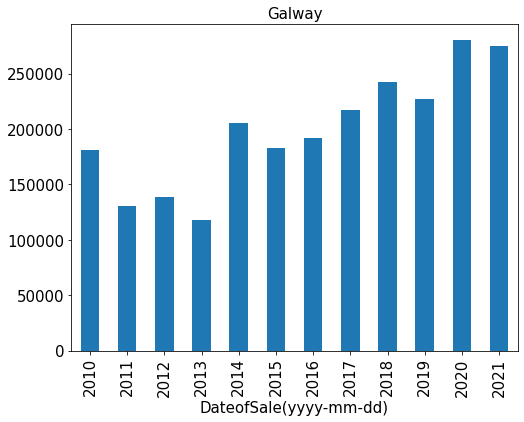

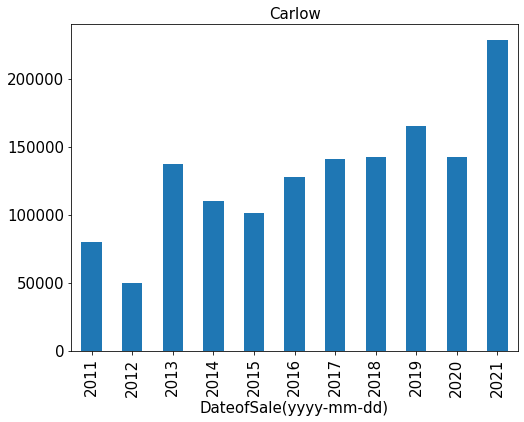

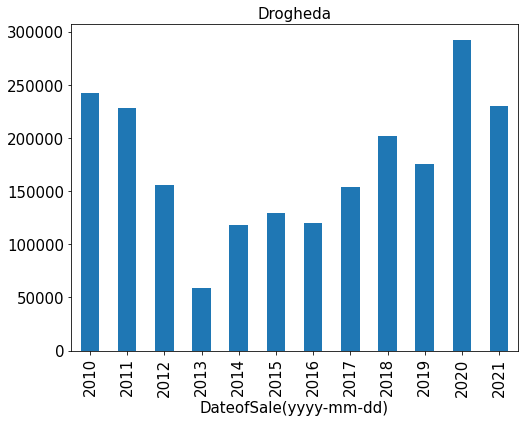

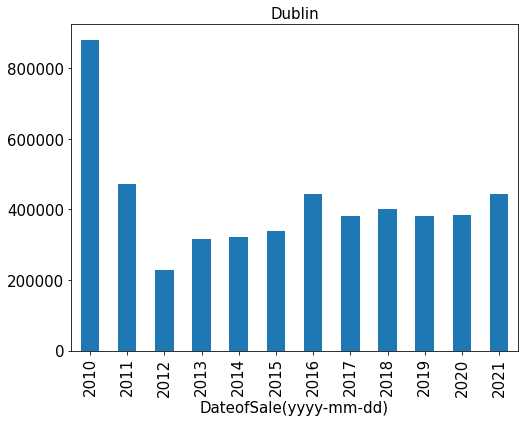

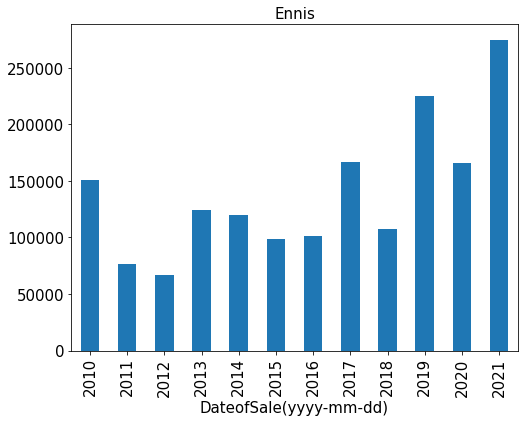

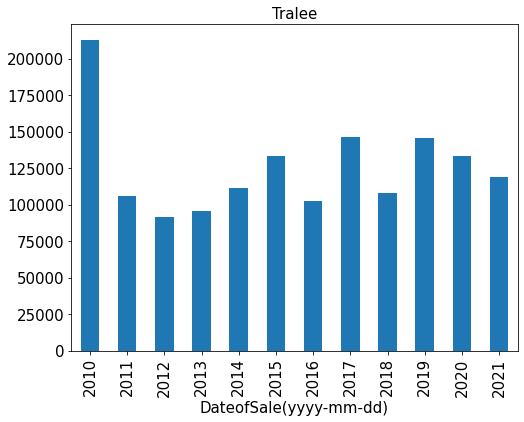

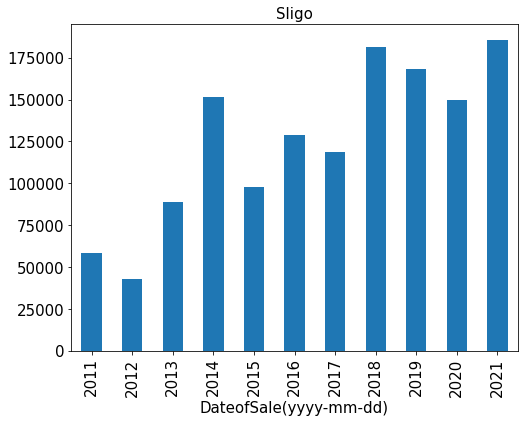

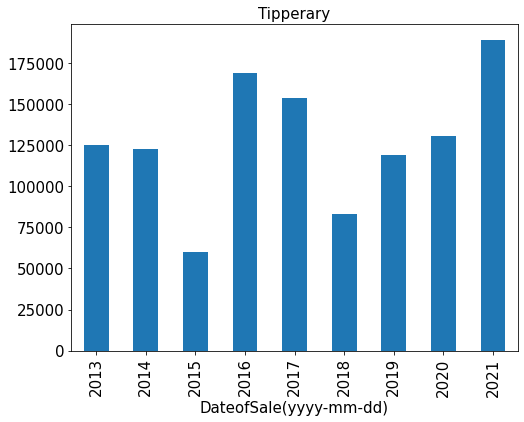

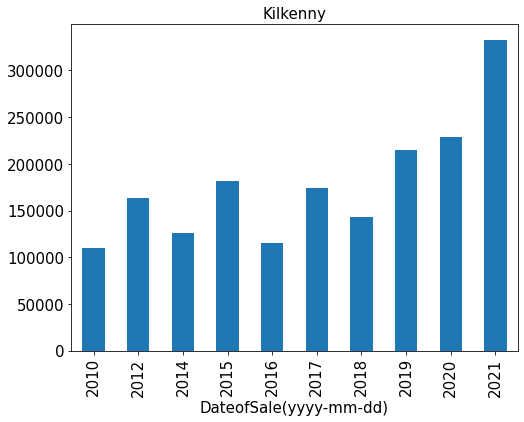

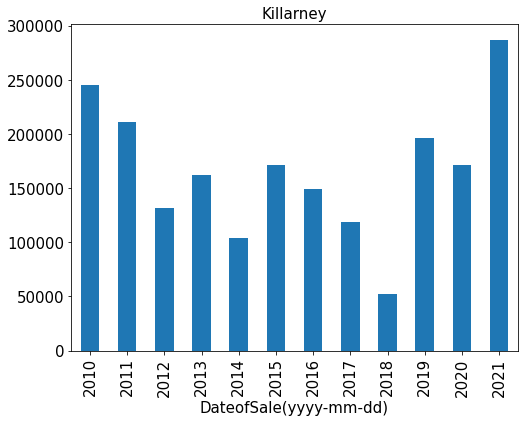

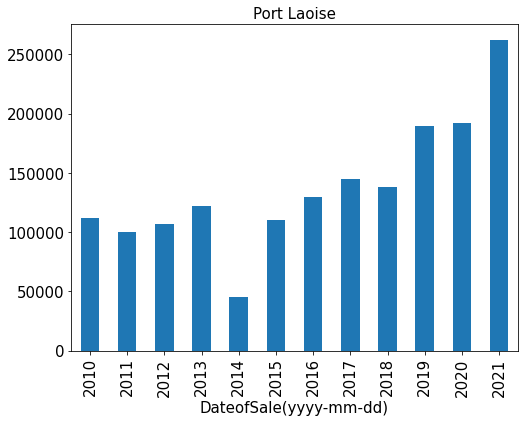

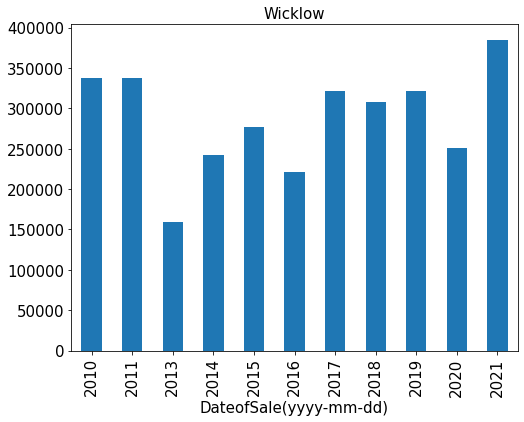

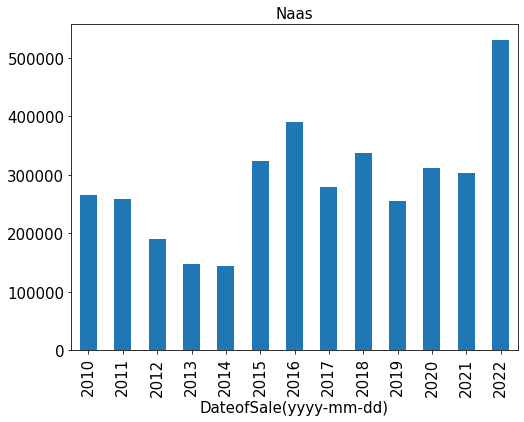

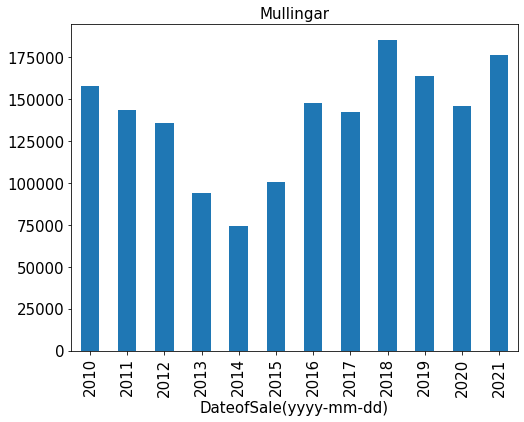

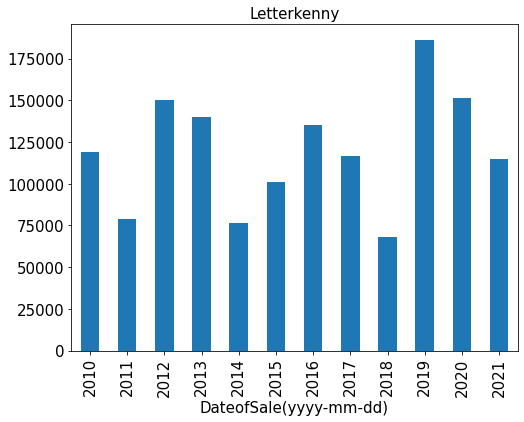

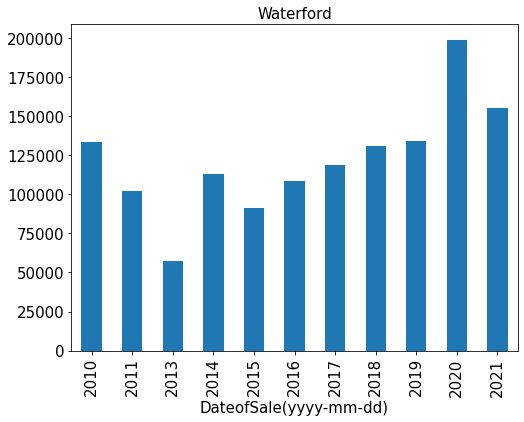

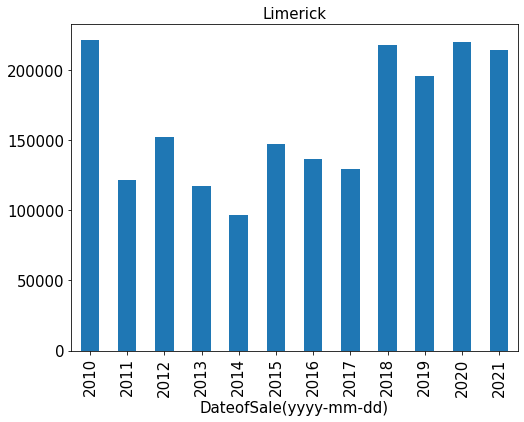

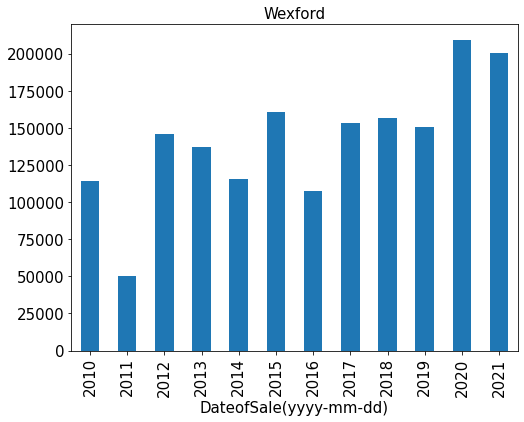

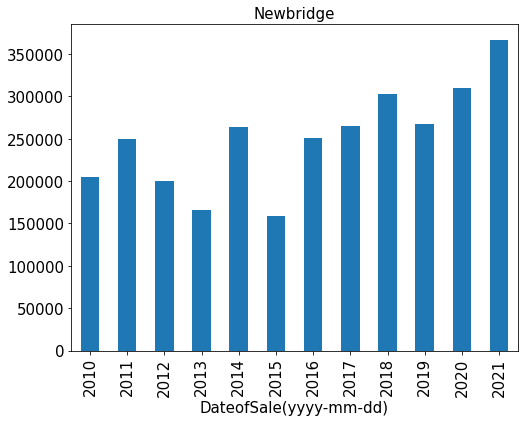

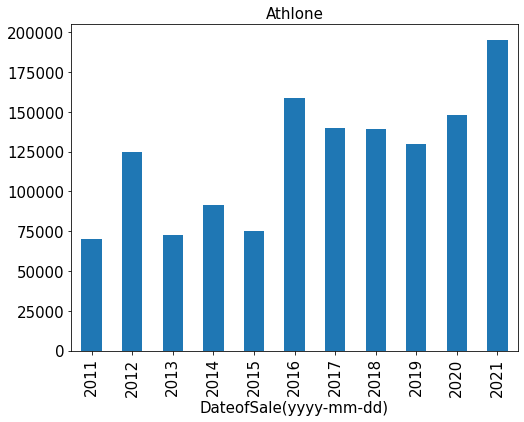

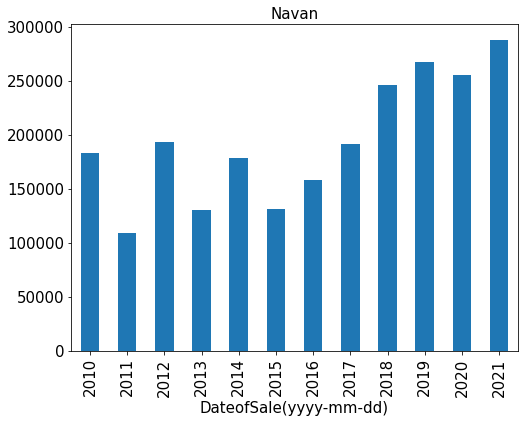

In [128]:
towns = dffullyclean['Town'].unique().tolist()
# not graphing nan
for town in towns[1:]:
    subdf = dffullyclean[dffullyclean['Town'].isin([town])]
    townMeans = subdf['CleanedPrice(€)'].groupby(subdf['DateofSale(yyyy-mm-dd)'].map(lambda x: x.year)).mean()
    plt.figure(figsize=(8,6))
    plt.title(town, fontsize=15)
    townMeans.plot(kind='bar')
    plt.show()

- It is interesting to note a somewhat less pronounced trend in the property prices over time by Town, albeit one that is still present.
- This of course is not the same for each Town. Some of the larger Towns have more pronounced upward trends.
- It would be interesting to explore the reasons for this. I would guess that this is due to increasing populations, general inflation, or supply constraints, or potentially other reasons.
- One caveat with this data is the small number of samples for some of the smaller towns by population. This means it is hard to extract meaningful observations.
- Another interesting point is how most Towns follow the same general trend, i.e. falling in 2013 or so, before rising. This implies the reasons for the fall was across the entire country, and not specific to any region.

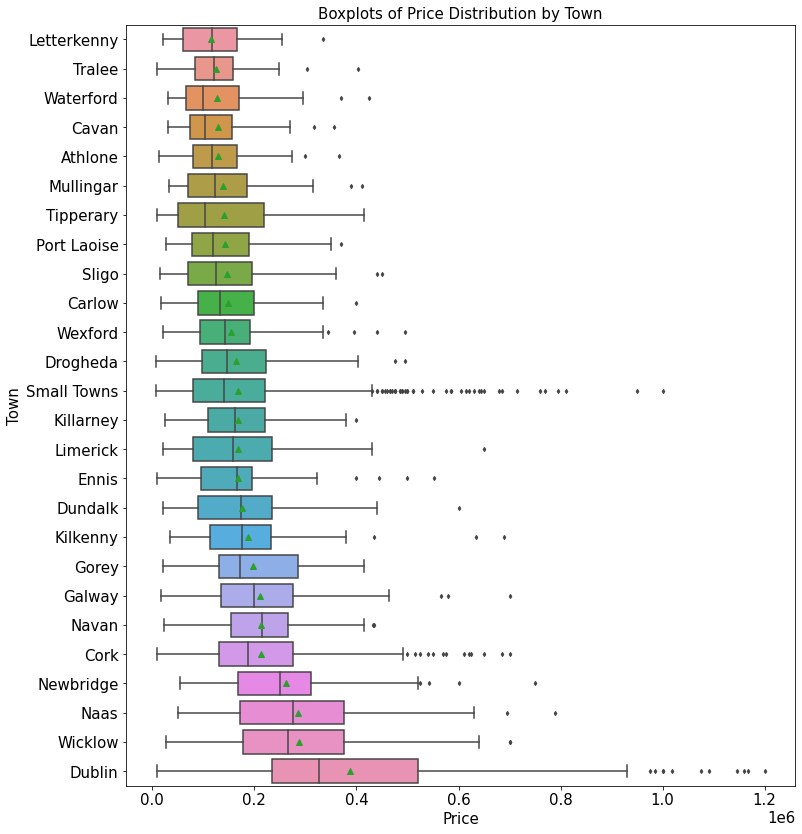

In [129]:
fig, ax = plt.subplots(figsize=(12,14))
means = dffullyclean['CleanedPrice(€)'].groupby(dffullyclean["Town"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = dffullyclean['CleanedPrice(€)'], y=dffullyclean['Town'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')
plt.title('Boxplots of Price Distribution by Town')
plt.show()

- While the previous chart was useful for analysing the change in prices by Town over time, the above boxplots show the magnitude in difference between each town average. It is very similar to the trend with the Counties, with areas closer to Dublin exhibiting higher averages.
- Unsurprisingly, the larger counties, as well as those counties close to Dublin show a much higher average over time.
- Dublin has by the largest averages across both mean and median, while Letterkenny has the lowest.
- It is interesting to observe that for almost every town the mean is greater than the median, the same trend we saw in part 3. This implies a positive skew in the data, meaning there are large outliers increasing the mean.

<b>Additional feature 2: Stock Price on Date of Sale</b><br>

The stock market is regarded as a good indicator of the wider economy. Therefore, I have used a dateset of the closing price of the S&P500 since 2010, and added this to the dataset for each property on the day it was sold. As the stock price is not every day, I first had to ensure that there was a sensible entry on each calendar day. To do this I used the pandas pad() feature to map a price from the closest day to the each created day. Although the property dataset is Irish and the stock prices are from the US, the S&P500 is typically regarded as a good proxy for the global economy.

I then investigate if there is a relationship between the price paid for the property and the price of the stock market.

Prices from https://finance.yahoo.com/quote/%5EGSPC/history/

In [130]:
# read in the csv of prices
sp500 = pd.read_csv('datasets/S&P500HistoricalData.csv')
sp500

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 10, 2022","4,259.52","4,252.55","4,268.28","4,209.80",-,-0.43%
1,"Mar 09, 2022","4,277.88","4,223.10","4,299.40","4,223.10",-,2.57%
2,"Mar 08, 2022","4,170.62","4,202.66","4,276.94","4,157.87",-,-0.73%
3,"Mar 07, 2022","4,201.09","4,327.01","4,327.01","4,199.85",-,-2.95%
4,"Mar 04, 2022","4,328.87","4,342.12","4,342.12","4,284.98",-,-0.79%
...,...,...,...,...,...,...,...
3063,"Jan 08, 2010","1,144.98","1,140.52","1,145.39","1,136.22",-,0.29%
3064,"Jan 07, 2010","1,141.69","1,136.27","1,142.46","1,131.32",-,0.40%
3065,"Jan 06, 2010","1,137.14","1,135.71","1,139.19","1,133.95",-,0.05%
3066,"Jan 05, 2010","1,136.52","1,132.66","1,136.63","1,129.66",-,0.31%


In [131]:
# drop unnecessary rows
sp500 = sp500.drop(sp500.columns[[2,3,4,5,6]], axis=1)

In [132]:
# set Date to datetime pandas datatype
sp500['Date'] = pd.to_datetime(sp500['Date'])

# set date as index
sp500.set_index('Date', inplace=True)

# Resampling + filling missing values
sp500 = sp500.resample('1D').pad()


In [133]:
# merge the two datasets by the date columns
dffullyclean = dffullyclean.merge(sp500, left_on=['DateofSale(yyyy-mm-dd)'],right_on=['Date'], how='left')
# rename the column in dffullyclean
dffullyclean = dffullyclean.rename(columns={'Price': 'StockPrice'})

In [134]:
# convert to float after removing the commas
dffullyclean['StockPrice'] = dffullyclean['StockPrice'].str.replace(',', '').astype(float)

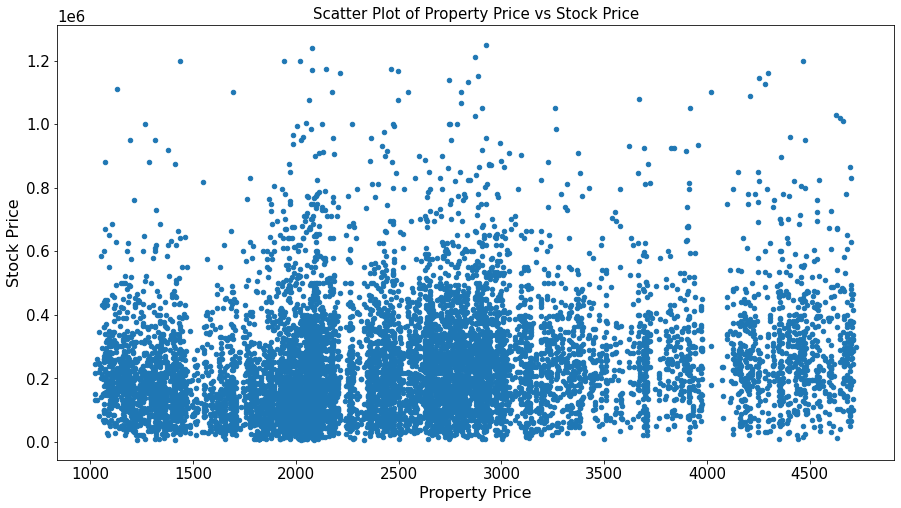

In [135]:
# plot
dffullyclean.plot(kind='scatter', x='StockPrice', y='CleanedPrice(€)', figsize=(15,8))
plt.ylabel('Stock Price', fontsize=16)
plt.xlabel('Property Price', fontsize=16)
plt.title("Scatter Plot of Property Price vs Stock Price", fontsize=15)
plt.show()

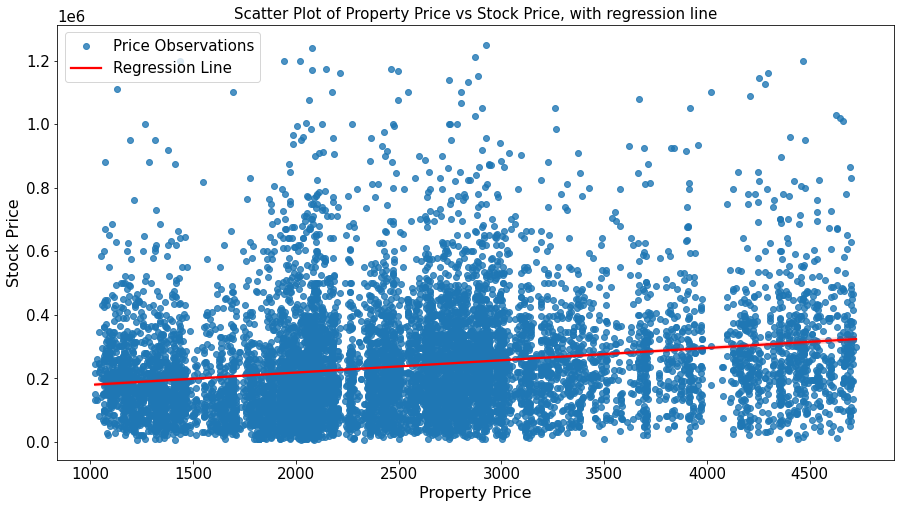

In [136]:
# code for the below inspired from https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis
plt.figure(figsize=(15,8))
ax = sns.regplot(
    x=dffullyclean['StockPrice'],
    y=dffullyclean['CleanedPrice(€)'], line_kws={"color": "red"}
)
plt.ylabel('Stock Price', fontsize=16)
plt.xlabel('Property Price', fontsize=16)
plt.title("Scatter Plot of Property Price vs Stock Price, with regression line", fontsize=15)

plt.legend(labels=["Price Observations","Regression Line"])
plt.show()

In [137]:
# calculate correlation coefficient
# need to define the section of the dataframe that does not have null values for cleanedprice to calculate it
populatedprice = dffullyclean[dffullyclean["CleanedPrice(€)"].notnull()]
r, p = stats.pearsonr(populatedprice['StockPrice'], populatedprice['CleanedPrice(€)'])
print('Pearson\'s correlation r is %s with a p-value = %s' %(r,p))

Pearson's correlation r is 0.19686669982191776 with a p-value = 2.1872594603832997e-86


- Initially it is quite difficult to see an overall trend, however it seems as though higher stock prices do result in higher prices
- Adding a regression line makes it clear to see that there is indeed a correlaion between property price and the stock market
- In addition, the correlation coeffecient of close to 0.2, implies a relatively weak positive correlation, with high confidence (low p-score). This hints at the fact that as the price of the stock market rises we should see some rise in property prices, although the relationship is not that well established.
- It would be interesting to observe this relationship over a longer time horizon, as well as for property prices in other countries to see if others follow a similar trend.

<b>Additional feature 3: Town Population Data</b><br>

Using the towns that were created in the first feature, I will now analyse the impact of population on Property Price. To do this I will need a CSV of all towns and their counties. I will then need to merge both datasets, ensuring that the match is made by both town and county so that no town is matched to a different one of the same name. I also had to check the names of the towns in the new dataset to ensure they matched those in the original. 

The natural expectation would be to observe larger towns with higher prices, given that with more people there is an upwards pressure on prices.

Population data from https://data.cso.ie/table/E2052

In [138]:
# read in population data
population = pd.read_csv('datasets/population.csv')
population

,Statistic,CensusYear,Alphabetical List of Towns,UNIT,VALUE
0,Total Population (Number),2016,"Abbeydorney, Kerry",Number,418.0
1,Total Population (Number),2016,"Abbeyfeale, Limerick",Number,2023.0
2,Total Population (Number),2016,"Abbeyknockmoy, Galway",Number,262.0
3,Total Population (Number),2016,"Abbeyleix, Laois",Number,1770.0
4,Total Population (Number),2016,"Adamstown, Wexford",Number,293.0
...,...,...,...,...,...
6113,Birthplace - Outside Ireland (%),2016,"Wicklow, Wicklow",%,16.1
6114,Birthplace - Outside Ireland (%),2016,"Williamstown, Galway",%,17.6
6115,Birthplace - Outside Ireland (%),2016,"Woodford, Galway",%,13.8
6116,Birthplace - Outside Ireland (%),2016,"Youghal, Cork",%,17.4


In [139]:
# only interested in population
popdata = population[population["Statistic"].isin(["Total Population (Number)"])]

# drop unused columns
popdata = popdata.drop(popdata.columns[[0,1,3]], axis=1)

# town list split into town name and county - need these separated into two columns - split by comma
popdata[['Town','County']] = popdata['Alphabetical List of Towns'].str.split(',',expand=True)
# drop unused column created
popdata = popdata.drop(popdata.columns[[0]], axis=1)
# rename the column in population
popdata = popdata.rename(columns={'VALUE': 'Population'})

# remove space in County
popdata["County"] = popdata["County"].str.replace(' ', '').astype('category')
popdata["Town"] = popdata["Town"].astype('category')

In [140]:
# list of all towns needed
newtownList = dffullyclean['Town'].unique().tolist()
# remove any row not containing a town from the main dataframe
for index, row in popdata.iterrows():
    # removing nan from newtownList
    if not (any(map(row['Town'].__contains__, newtownList[1:]))):
        popdata = popdata.drop(index)

In [141]:
# check whats left - lots with strange names
poptowns = popdata['Town'].unique().tolist()
for i in range(len(poptowns)):
    print(i, poptowns[i])

0 Athlone
1 Ballineen/Enniskean
2 Carlow
3 Cavan
4 Cork city and suburbs
5 Drogheda
6 Droichead Nua (Newbridge)
7 Dublin city and suburbs
8 Dundalk
9 Ennis
10 Enniscorthy
11 Enniskerry
12 Ennistymon
13 Galway City and Suburbs
14 Gorey
15 Kilkenny
16 Killarney
17 Letterkenny
18 Limerick city and suburbs
19 Mullingar
20 Naas
21 Navan (An Uaimh)
22 Sligo
23 Tipperary
24 Tralee
25 Waterford city and suburbs
26 Wexford
27 Wicklow


In [142]:
# rename towns to match towns already in dataframe
popdata = popdata.replace(to_replace='Droichead Nua (Newbridge)', value='Newbridge')
popdata = popdata.replace(to_replace='Navan (An Uaimh)', value='Navan')
popdata = popdata.replace(to_replace='Cork city and suburbs', value='Cork')
popdata = popdata.replace(to_replace='Galway City and Suburbs', value='Galway')
popdata = popdata.replace(to_replace='Limerick city and suburbs', value='Limerick')
popdata = popdata.replace(to_replace='Waterford city and suburbs', value='Waterford')
popdata = popdata.replace(to_replace='Dublin city and suburbs', value='Dublin')

In [143]:
# merge the population data into the main dataframe, make sure that Town and County match
dffullyclean = dffullyclean.merge(popdata, on=['County', 'Town'], how='left')

In [144]:
# calculate average town Price
populationfull = dffullyclean[dffullyclean["Population"].notnull()]
allpoptowns = populationfull['Town'].unique().tolist()
townmeans = []
townmedians = []
populations = []
for town in allpoptowns:
    sublisttown = populationfull[populationfull["Town"].isin([town])]
    townmean = sublisttown["CleanedPrice(€)"].mean()
    townmedian = sublisttown["CleanedPrice(€)"].median()
    # add average price to list
    townmeans.append(townmean)
    townmedians.append(townmedian)
    # add corresponding population to separate list at same index
    populations.append(popdata.loc[popdata['Town'] == town, 'Population'].item())

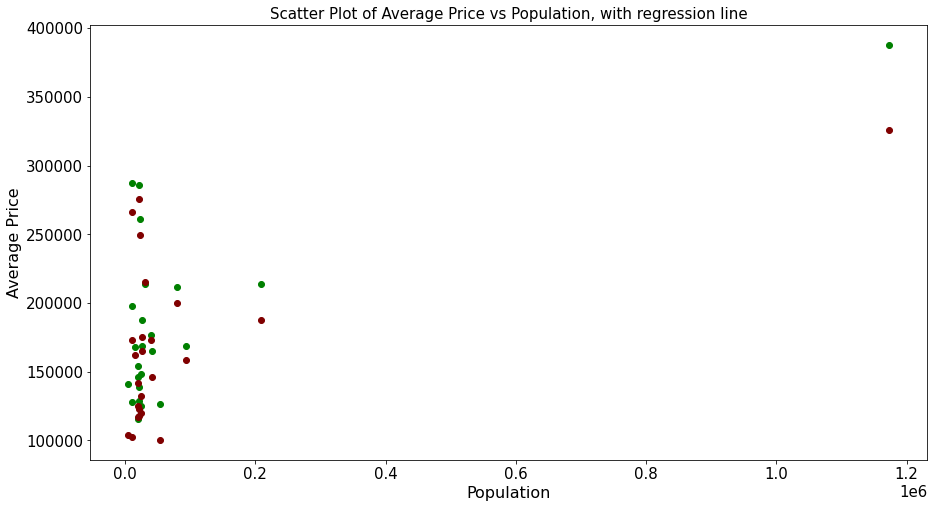

In [145]:
# list of dates and prices
dates = list(dffullyclean['DateofSale(yyyy-mm-dd)'])
prices = list(dffullyclean['CleanedPrice(€)'])
plt.figure(figsize=(15,8))
plt.title("Scatter Plot of Average Price vs Population, with regression line", fontsize=15)
plt.ylabel('Average Price', fontsize=16)
plt.xlabel('Population', fontsize=16)
plt.scatter(populations, townmeans, color="green")
plt.scatter(populations, townmedians, color="maroon")
plt.show()

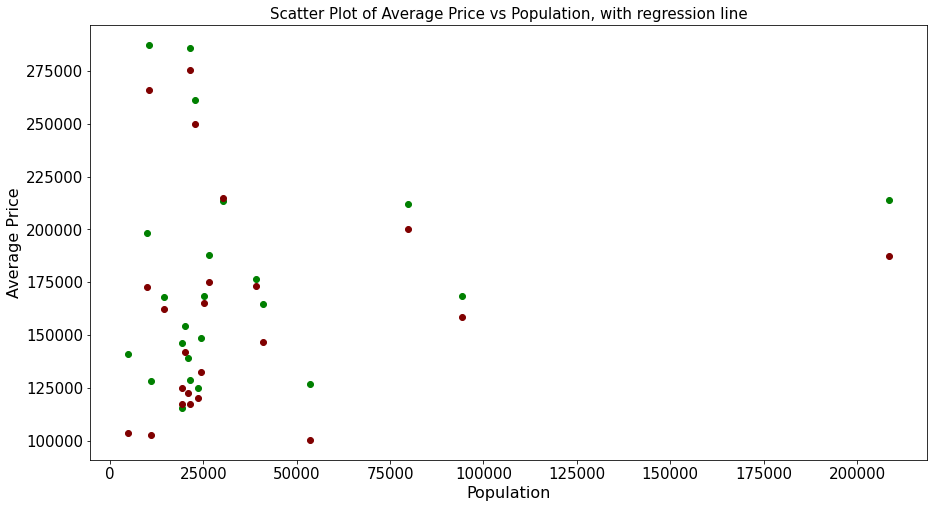

In [146]:
# remove Dublin as it is an outlier
townmeans1 = [x for x in townmeans if x < 300000]
townmedians1 = [x for x in townmedians if x < 300000]
populations1 = [x for x in populations if x < 1000000]
dates = list(dffullyclean['DateofSale(yyyy-mm-dd)'])
prices = list(dffullyclean['CleanedPrice(€)'])
plt.figure(figsize=(15,8))
plt.title("Scatter Plot of Average Price vs Population, with regression line", fontsize=15)
plt.ylabel('Average Price', fontsize=16)
plt.xlabel('Population', fontsize=16)
plt.scatter(populations1, townmeans1, color="green")
plt.scatter(populations1, townmedians1, color="maroon")
plt.show()

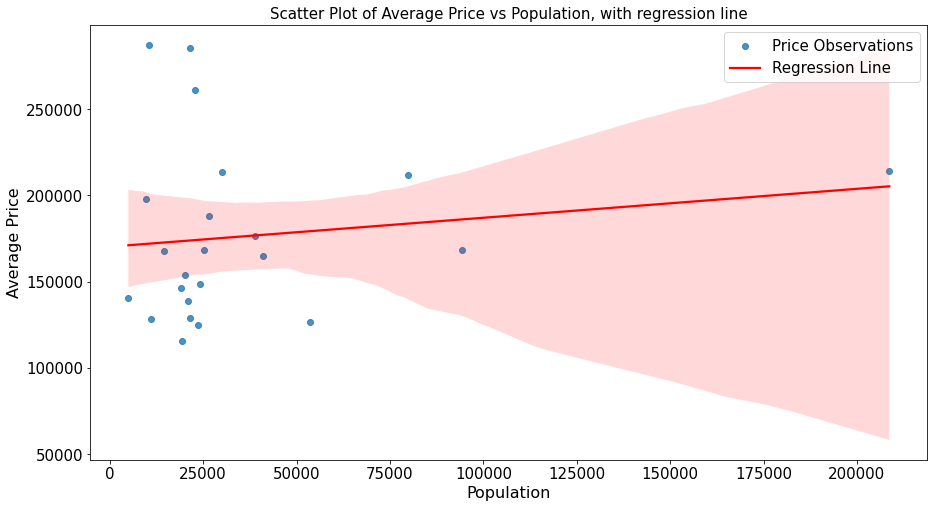

In [147]:
# code for the below inspired from https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis
plt.figure(figsize=(15,8))
ax = sns.regplot(
    x=populations1,
    y=townmeans1, line_kws={"color": "red"}
)
plt.title("Scatter Plot of Average Price vs Population, with regression line", fontsize=15)
plt.ylabel('Average Price', fontsize=16)
plt.xlabel('Population', fontsize=16)

plt.legend(labels=["Price Observations","Regression Line"])
plt.show()

In [148]:
# calculate correlation coefficient
# need to define the section of the dataframe that does not have null values for cleanedprice to calculate it
populatedprice = dffullyclean[dffullyclean["CleanedPrice(€)"].notnull()]
populatedPop = populatedprice[populatedprice["Population"].notnull()]
r, p = stats.pearsonr(populatedPop['Population'], populatedPop['CleanedPrice(€)'])
print('Pearson\'s correlation r is %s with a p-value = %s' %(r,p))

Pearson's correlation r is 0.4704311524498156 with a p-value = 9.95056638167042e-140


- We can see that there is an observable relationship between average price in an area and its population
- I do not have a huge number of samples to test this, however it is clear that there is a relationship nonetheless
- The correlation coefficient is quite high. However, this is likely due to the number of datapoints for properties in Dublin.
- It would be interesting to look at similar relationships, such as GDP output per town, population density, crime, or property vacancy rates.

<b>Additional feature 4: Quarters</b><br>

Typical reports on property sales focus on sales by quarter. We have dates per day and so it would be nice to have these grouped into quarters, to observe any relationships that may be there. It is often cited that property sales are larger at the end of the year as people try to close sales so it would be interesting if we could observe this. As I already plotted the quarters in an earlier section, in which it appearted there is a slightly noticeable trend of Q4 sales being greater, this part will focus on the quarter number. I will also see if increased sales lead to higher prices paid.

In [149]:
dffullyclean['quarter'] = dffullyclean['DateofSale(yyyy-mm-dd)'].dt.to_period('Q')

In [150]:
for index, row in dffullyclean.iterrows():
    if 'Q1' in str(row['quarter']):
        dffullyclean.loc[index,'QuarterNumber'] = 1
    elif 'Q2' in str(row['quarter']):
        dffullyclean.loc[index,'QuarterNumber'] = 2
    elif 'Q3' in str(row['quarter']):
        dffullyclean.loc[index,'QuarterNumber'] = 3
    elif 'Q4' in str(row['quarter']):
        dffullyclean.loc[index,'QuarterNumber'] = 4

dffullyclean['QuarterNumber'] = dffullyclean['QuarterNumber'].astype('category')

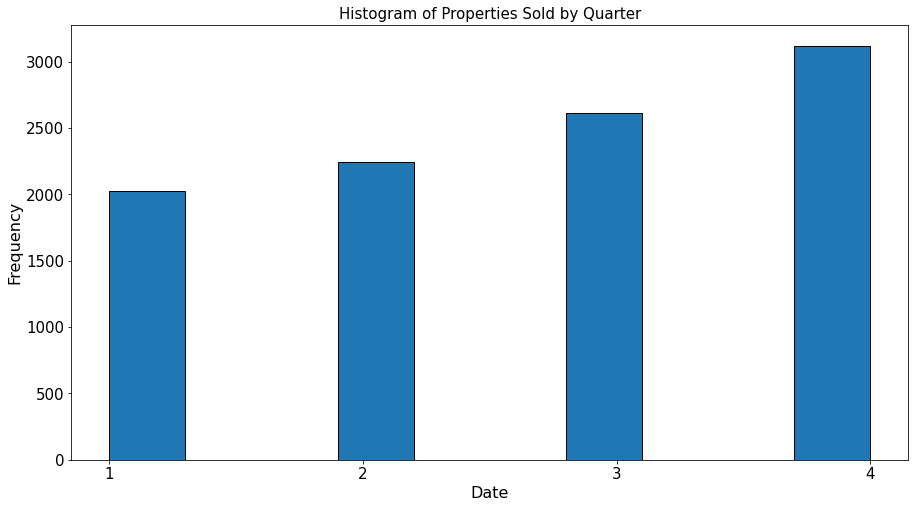

In [151]:
plt.figure(figsize=(15,8))
plt.title("Histogram of Properties Sold by Quarter", fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.hist(dffullyclean['QuarterNumber'], edgecolor="black")
plt.xticks(np.arange(1, 5, 1))
plt.show()

/Users/Kevin/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


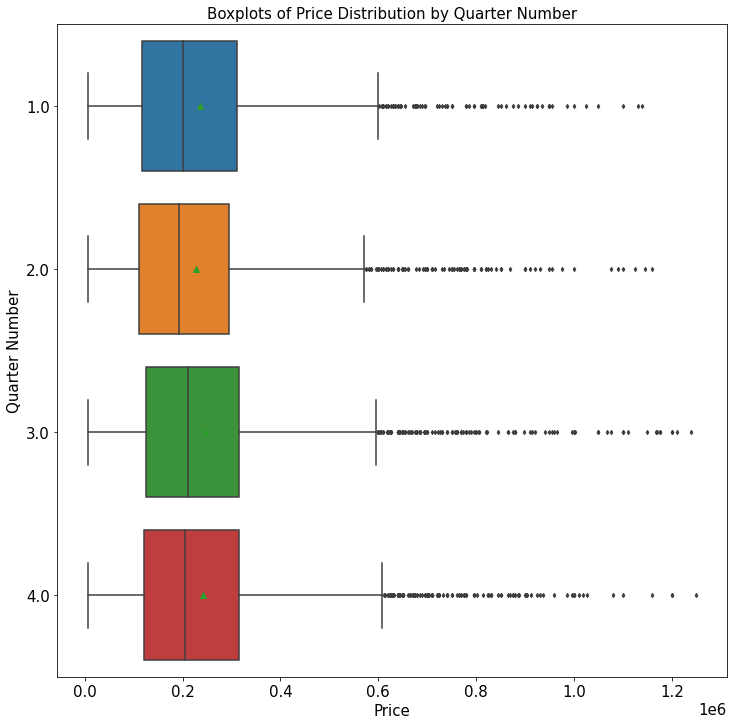

In [152]:
fig, ax = plt.subplots(figsize=(12,12))
sns.boxplot(y=dffullyclean['QuarterNumber'], x = dffullyclean['CleanedPrice(€)'], fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('Quarter Number')
plt.title('Boxplots of Price Distribution by Quarter Number')
plt.show()

In [153]:
# calculate correlation coefficient
# need to define the section of the dataframe that does not have null values for cleanedprice to calculate it
populatedprice = dffullyclean[dffullyclean["CleanedPrice(€)"].notnull()]
r, p = stats.pearsonr(populatedprice['QuarterNumber'], populatedprice['CleanedPrice(€)'])
print('Pearson\'s correlation r is %s with a p-value = %s' %(r,p))

Pearson's correlation r is 0.022418197735626283 with a p-value = 0.026313857794136735


- Unsurprisingly, there is a clear uptick in the volume of sales in Q4
- It seems as though every quarter has more sales than the next
- I did not remove the sales from Q1 2022 from the data which artifically increases the count for Q1. Even still, it is by the smallest.
- Interestingly, the increased number of sales does not correspond with a greater average price. We can see in the box plot above that there is only a very marginal difference between each quarter. In addition the correlation coefficient is extremely low, implying little to no relationship in the quarter and the price.

In [154]:
# export data frame to a csv
dffullyclean.to_csv('datasets/PPRFileFinalVersion.csv', index=False)

In [155]:
dffullyclean.dtypes

DateofSale(yyyy-mm-dd)     datetime64[ns]
Address                            object
PostalCode                       category
County                             object
Price(€)                          float64
NotFullMarketPrice               category
VATExclusive                     category
DescriptionofProperty            category
PropertySizeDescription          category
CleanedPrice(€)                   float64
Town                               object
StockPrice                        float64
Population                        float64
quarter                     period[Q-DEC]
QuarterNumber                    category
dtype: object

In [156]:
dffullyclean

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,CleanedPrice(€),Town,StockPrice,Population,quarter,QuarterNumber
0,2017-08-01,"[apartment 27, galway bay sea view apts, sal...",NaN,Galway,90575.00,No,No,New Dwelling house /Apartment,between 38 and 125 sq metres,90575.00,NaN,2476.35,NaN,2017Q3,3.0
1,2017-08-28,"[38a lr beechwood ave, ranelagh, dublin 6]",Dublin 6,Dublin,515000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,515000.00,NaN,2444.24,NaN,2017Q3,3.0
2,2010-06-17,"[4 ard na greine, lis na dara, dundalk]",NaN,Louth,347066.11,No,Yes,New Dwelling house /Apartment,greater than or equal to 125 sq metres,347066.11,Dundalk,1116.04,39004.0,2010Q2,2.0
3,2020-12-18,"[1 cathedral view court, off new st, dublin 8]",Dublin 8,Dublin,345000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,345000.00,NaN,3709.41,NaN,2020Q4,4.0
4,2019-02-08,"[190 ardmore dr, artane, dublin 5]",Dublin 5,Dublin,390000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,390000.00,NaN,2707.88,NaN,2019Q1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,2019-11-15,"[23 oak park avenue, oak park, craddockstown]",NaN,Kildare,327499.99,No,Yes,New Dwelling house /Apartment,NaN,327499.99,NaN,3120.46,NaN,2019Q4,4.0
9994,2017-04-27,"[porridgetown, roscahill, co galway]",NaN,Galway,250000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,250000.00,NaN,2388.77,NaN,2017Q2,2.0
9995,2018-03-27,"[34 corbawn close, shankill, dublin]",Dublin 18,Dublin,485000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,485000.00,Dublin,2612.62,1173179.0,2018Q1,1.0
9996,2019-02-26,"[177 robertshill, circular rd, kilkenny]",NaN,Kilkenny,170000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,170000.00,Kilkenny,2793.90,26512.0,2019Q1,1.0


In [ ]:
for index, row in trips.iterrows():
    # if 24 then change to 1am and increase day by 1
    if row['HOUR_DEPARTURE'] == 24:
        trips.loc[index,'HOUR_DEPARTUREMERGE'] = 1
        trips.loc[index,'DAYOFSERVICEMERGE']= row['DAYOFSERVICE'] + dt.timedelta(days=1)